# TRABAJO 1: ENSEMBLE LEARNING | MACHINE LEARNING II
## Feb 2023
--- 

### GRUPO: G9
- Carlota Monedero Herranz
- José Manuel Vega Gradit
- Jorge Ayuso Martínez
- Javier Gisbert Gil
- Diego Sanz-Gadea Sánchez

--- 

**IMPORTANTE:**
- Asegúrate, fijando la semilla de los nº aleatorios según proceda, que si se vuelve a ejecutar el cuaderno los resultados son idénticos
- Responde a las preguntas planteadas utilizando instrucciones "print" que permitan leer cómodamente como resultado de la ejecución de la celda el texto explicativo junto a las figuras o tablas a las que haga referencia (mira el ejemplo en la primera gráfica que se representa). También puedes usar markdown para responder.
- No escribas líneas de código muy largas, tienes una regla para ayudarte a no hacerlo
- No cambies la estructura del documento, respeta las secciones que ya existen


In [4]:
# !pip install plotly
# !pip install imbalanced-learn
# !pip install threadpoolctl==3.1.0
# !pip install patsy
# !pip install nbformat
# !pip install lightgbm
# !pip install bayesian-optimization
# !pip install jinja2
# !pip install statsmodels

---
Importamos todos los paquetes aquí por comodidad

In [5]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

# Libreríasc clásicas de Data Science
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px

#Own Libraries/Modules
from src.outlier_detection import OutlierManager
from src.bayesian_optimizer import ModelOptimizer
from src.utils import *

#avoid warnings
import warnings
warnings.filterwarnings('ignore')

# Scikit-Learns modules
# Preprocessing
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score, accuracy_score
import xgboost
from xgboost import XGBClassifier
#import random grid search
from sklearn.model_selection import RandomizedSearchCV
import shap

# Modelling
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier

# Metrics
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import StackingClassifier
import lightgbm as lgb

# mltools
from mltools import classification_tools as CT
from mltools import model_tools as MT
from sklearn.decomposition import PCA

Para mejorar la estética de las gráficas, hacemos uso de `seaborn`:

In [6]:
sns.set()

Con el siguiente comando podemos calibrar el número de columnas del DataFrame que se muestran:

In [7]:
pd.set_option('display.max_columns', None)

## 1. AJUSTE DE LOS MODELOS CON EL DATASET `AJU_DATOS_DEM_C3.csv`

Se trata de estimar la variable FESTIVO (1: el día es festivo) a partir de las variables disponibles en el dataset que se consideren oportunas. NO se pueden utilizar como variables de entrada: FECHA, DIA ni AÑO. La FECHA es interesante manejarla simplemente como ayuda para entender lo que esté pasando.

Se deben ajustar diferentes modelos, buscando un buen compromiso entre la complejidad y el error en cada uno de ellos. El objetivo es conseguir un buen modelo con una gran capacidad de acierto en el futuro. Modelos que deben crearse, analizando los resultados de cada uno de ellos (errores e importancias de las variables):
- Simple tree
- Bagged  tree
- Random Forest
- Gradient boosting
- Stacking

#### Carga de datos:

In [8]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

df_aju = pd.read_csv('data/input/AJU_DATOS_DEM_C3.csv')

# Parseamos la fecha (cadena) para que sea un datetime con formato dd/mm/yyyy 
# Nota: esta variable NO se puede utilizar como entrada en los modelos
df_aju.FECHA = pd.to_datetime(df_aju.FECHA, format="%d/%m/%Y") 
s = df_aju.loc[:, 'FECHA']
df_aju['FECHA'] =  s.dt.date

# Eliminamos las variables que no se pueden usar como entradas en los modelos
del df_aju['ANNO']
del df_aju['DIA']

print('Tamaño de df_orig con los datos cargados:', df_aju.shape)
print('Dataframe con todos los datos leidos (filas: días, columnas: variables):')
df_aju.head()

Tamaño de df_orig con los datos cargados: (2879, 30)
Dataframe con todos los datos leidos (filas: días, columnas: variables):


FECHA      CR00      CR01      CR02      CR03      CR04      CR05  \
0  2014-01-01  0.040942  0.038985  0.036382  0.034416  0.033409  0.033420   
1  2014-01-02  0.033950  0.030996  0.029517  0.028966  0.029165  0.030150   
2  2014-01-03  0.035463  0.032112  0.030292  0.029521  0.029450  0.030515   
3  2014-01-04  0.035959  0.032772  0.031034  0.030178  0.030135  0.030782   
4  2014-01-05  0.037506  0.034148  0.031878  0.031126  0.030930  0.031604   

       CR06      CR07      CR08      CR09      CR10      CR11      CR12  \
0  0.034054  0.034229  0.035889  0.039427  0.041801  0.042122  0.042366   
1  0.032944  0.036510  0.041196  0.045132  0.046170  0.045324  0.044659   
2  0.033188  0.036656  0.041052  0.046046  0.047047  0.044796  0.044318   
3  0.032598  0.034982  0.039299  0.044597  0.046754  0.046050  0.044611   
4  0.033066  0.034803  0.038758  0.043760  0.045930  0.045478  0.044804   

       CR13      CR14      CR15      CR16      CR17      CR18      CR19  \
0  0.043396  0.042980  0.040835  0.041026  0.044652  0.051983  0.055197   
1  0.045434  0.045281  0.043589  0.043362  0.045939  0.052936  0.055820   
2  0.044846  0.044694  0.043458  0.043363  0.045908  0.052802  0.055230   
3  0.045670  0.045926  0.044732  0.044316  0.046249  0.051650  0.053757   
4  0.045645  0.045275  0.043290  0.043349  0.046256  0.051721  0.052902   

       CR20      CR21      CR22      CR23  MES  DIASEM  FESTIVO  TMIN  TMAX  
0  0.054185  0.051063  0.046240  0.041000    1       3        1  12.3  20.2  
1  0.054451  0.051482  0.046145  0.040880    1       4        0  12.0  20.1  
2  0.053520  0.050286  0.045412  0.040025    1       5        0  13.2  21.0  
3  0.052620  0.049973  0.044970  0.040386    1       6        0  14.4  23.4  
4  0.051481  0.049655  0.045730  0.040905    1       7        0  12.8  23.1

#### Visión general de las series:

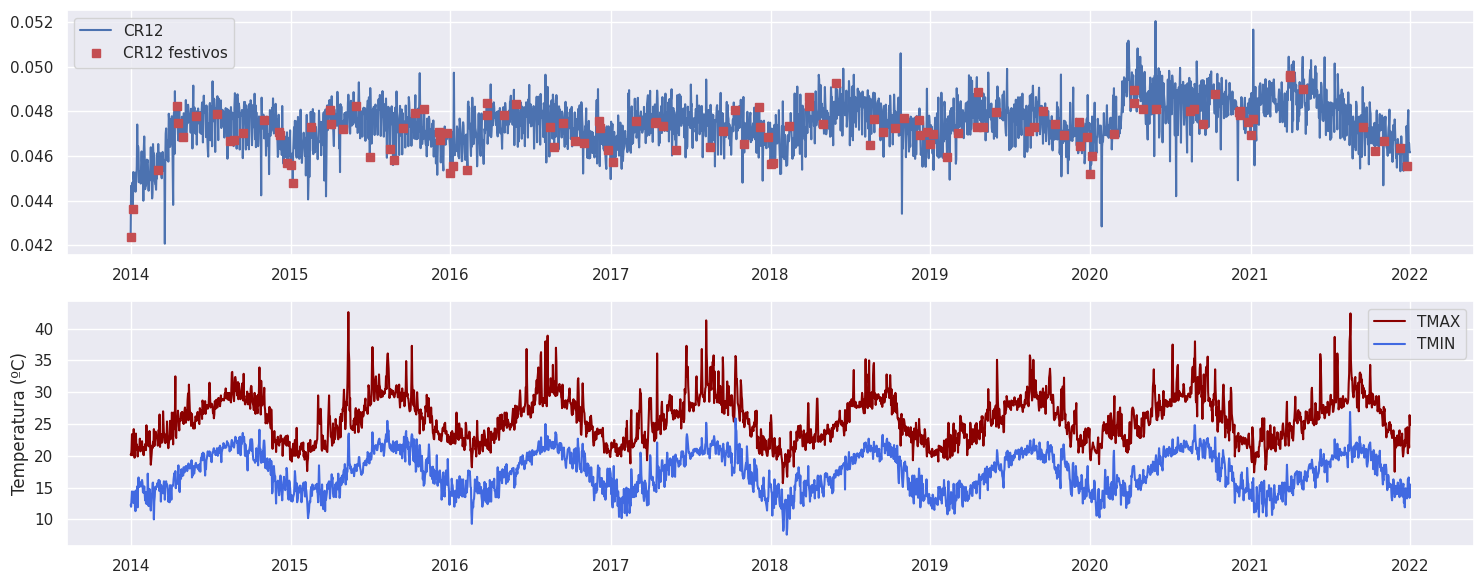

Se observa que el nº de festivos (115) es claramente inferior al nº de laborables (2764)
En concreto, el porcentaje de festivos en el conjunto de ajuste es 3.99444251476207 %


In [9]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
fig = plt.figure(1, figsize=(15,6))

ax1 = plt.subplot(2, 1, 1)
ind_festivo = df_aju.FESTIVO == 1
plt.plot(df_aju.FECHA, df_aju.CR12, label='CR12')
plt.plot(df_aju.FECHA[ind_festivo], df_aju.CR12[ind_festivo], 'sr', label='CR12 festivos')
plt.legend()

plt.subplot(2, 1, 2,sharex = ax1)
plt.plot(df_aju.FECHA, df_aju.TMAX, label='TMAX', color="darkred")
plt.plot(df_aju.FECHA, df_aju.TMIN, label='TMIN', color="royalblue")
plt.ylabel("Temperatura (ºC)")
plt.tight_layout()
plt.legend()

plt.show()

num_festivos = np.count_nonzero(df_aju.FESTIVO)
num_laborables = df_aju.shape[0] - num_festivos
print(f'Se observa que el nº de festivos ({num_festivos}) es claramente inferior al nº de laborables ({num_laborables})')
print(f'En concreto, el porcentaje de festivos en el conjunto de ajuste es {100*num_festivos /  df_aju.shape[0]} %')
# fig.savefig('figura1.pdf')

---
### 1.1 Análisis exploratorio básico del problema

- Incluye un análisis que te permita comprender la naturaleza del problema, cómo son las variables de entrada, su interrelación, así como su relación con la variable de salida
- Comenta todo lo que parezca relevante para el tema tratado, incluyendo todas las gráficas que consideres oportunas
- Estudia cómo se reparten los festivos según el día de la semana y los meses

Vemos en primer lugar los tipos de datos de cada variable, así como la posible existencia de valores nulos:

In [10]:
# Ver datatypes
df_aju.dtypes

FECHA       object
CR00       float64
CR01       float64
CR02       float64
CR03       float64
CR04       float64
CR05       float64
CR06       float64
CR07       float64
CR08       float64
CR09       float64
CR10       float64
CR11       float64
CR12       float64
CR13       float64
CR14       float64
CR15       float64
CR16       float64
CR17       float64
CR18       float64
CR19       float64
CR20       float64
CR21       float64
CR22       float64
CR23       float64
MES          int64
DIASEM       int64
FESTIVO      int64
TMIN       float64
TMAX       float64
dtype: object

In [11]:
# Revisamos que columnas tienen valores nulos
null_values = df_aju.isnull().sum()
null_values[null_values>0].index.tolist()

[]

In [12]:
#Añadimos la fecha como datetime
df_aju['FECHA'] = pd.to_datetime(df_aju['FECHA'], format='%Y-%m-%d')
df_aju.set_index('FECHA', inplace=True)

Podemos observar que ninguna columna tiene valores nulos. Adicionalmente, los tipos de datos son los correctos, de forma que no es necesario realizar ningún cambio al respecto.

A continuación vamos a analizar los datos que tenemos desde un punto de vista estadístico:

In [13]:
df_aju.describe()

CR00         CR01         CR02         CR03         CR04  \
count  2879.000000  2879.000000  2879.000000  2879.000000  2879.000000   
mean      0.034957     0.032494     0.030964     0.030305     0.030266   
std       0.001606     0.002285     0.001341     0.001227     0.001107   
min       0.030414     0.027836     0.026304     0.026362     0.027067   
25%       0.033770     0.031340     0.029996     0.029424     0.029463   
50%       0.034726     0.032124     0.030687     0.030060     0.030074   
75%       0.035922     0.033320     0.031802     0.031081     0.030968   
max       0.040942     0.067164     0.036382     0.035336     0.034789   

              CR05         CR06         CR07         CR08         CR09  \
count  2879.000000  2879.000000  2879.000000  2879.000000  2879.000000   
mean      0.031063     0.033603     0.037270     0.041366     0.045223   
std       0.000955     0.000871     0.002104     0.002057     0.001498   
min       0.027963     0.028263     0.030260     0.017153     0.028013   
25%       0.030361     0.033031     0.035427     0.039913     0.044453   
50%       0.030938     0.033557     0.037093     0.041499     0.045344   
75%       0.031709     0.034129     0.039217     0.043018     0.046244   
max       0.034929     0.037046     0.041914     0.045876     0.048957   

              CR10         CR11         CR12         CR13         CR14  \
count  2879.000000  2879.000000  2879.000000  2879.000000  2879.000000   
mean      0.047050     0.046984     0.047507     0.048261     0.047648   
std       0.000995     0.000910     0.001037     0.001222     0.001100   
min       0.041063     0.041689     0.042062     0.043123     0.042364   
25%       0.046573     0.046431     0.046872     0.047506     0.046980   
50%       0.047134     0.047041     0.047549     0.048249     0.047667   
75%       0.047669     0.047585     0.048188     0.049009     0.048352   
max       0.050939     0.049904     0.052055     0.054524     0.053118   

              CR15         CR16         CR17         CR18         CR19  \
count  2879.000000  2879.000000  2879.000000  2879.000000  2879.000000   
mean      0.045344     0.044218     0.045380     0.047876     0.049790   
std       0.001059     0.001060     0.001242     0.002294     0.002797   
min       0.040525     0.038784     0.039004     0.040209     0.041802   
25%       0.044656     0.043499     0.044684     0.046561     0.047863   
50%       0.045364     0.044224     0.045475     0.047744     0.049314   
75%       0.046078     0.044959     0.046270     0.049166     0.052280   
max       0.048681     0.047659     0.048516     0.054592     0.057206   

              CR20         CR21         CR22         CR23          MES  \
count  2879.000000  2879.000000  2879.000000  2879.000000  2879.000000   
mean      0.050401     0.049120     0.043973     0.038937     6.526224   
std       0.002089     0.001359     0.001388     0.001344     3.444273   
min       0.043542     0.043666     0.038585     0.033029     1.000000   
25%       0.048883     0.048259     0.043005     0.037990     4.000000   
50%       0.050434     0.049143     0.043962     0.038882     7.000000   
75%       0.051931     0.050033     0.044932     0.039817    10.000000   
max       0.056826     0.053625     0.049216     0.043856    12.000000   

            DIASEM      FESTIVO         TMIN         TMAX  
count  2879.000000  2879.000000  2879.000000  2879.000000  
mean      4.006600     0.039944    17.460056    25.821639  
std       1.994683     0.195863     3.081945     3.677193  
min       1.000000     0.000000     7.600000    15.700000  
25%       2.000000     0.000000    15.000000    22.900000  
50%       4.000000     0.000000    17.500000    25.600000  
75%       6.000000     0.000000    20.200000    28.500000  
max       7.000000     1.000000    26.900000    42.600000

Podemos observar como los coeficientes de reparto de va aumentando en promedio su valor a partir de las 7 de la mañana, superando el valor de $0.04$ a las 10 de la mañana, y manteniendo un valor relativamente constante durante gran parte del día, lo cual tiene sentido dado que es el momento del día donde hay una mayor actividad. El máximo valor se alcanza a las 20:00, y a partir de ese momento empieza a decrecer según va entrando la noche. 

Adicionalmente, se observa que la temperatura mínima media es de aproximadamente $17,5$ºC y medio, mientras que la temperatura máxima media es cercana a los $26$ºC.

### Visualización

En primer lugar se muestra una matriz de correlación que nos permite entender mejor que variables están correlacionadas linealmente entre sí:

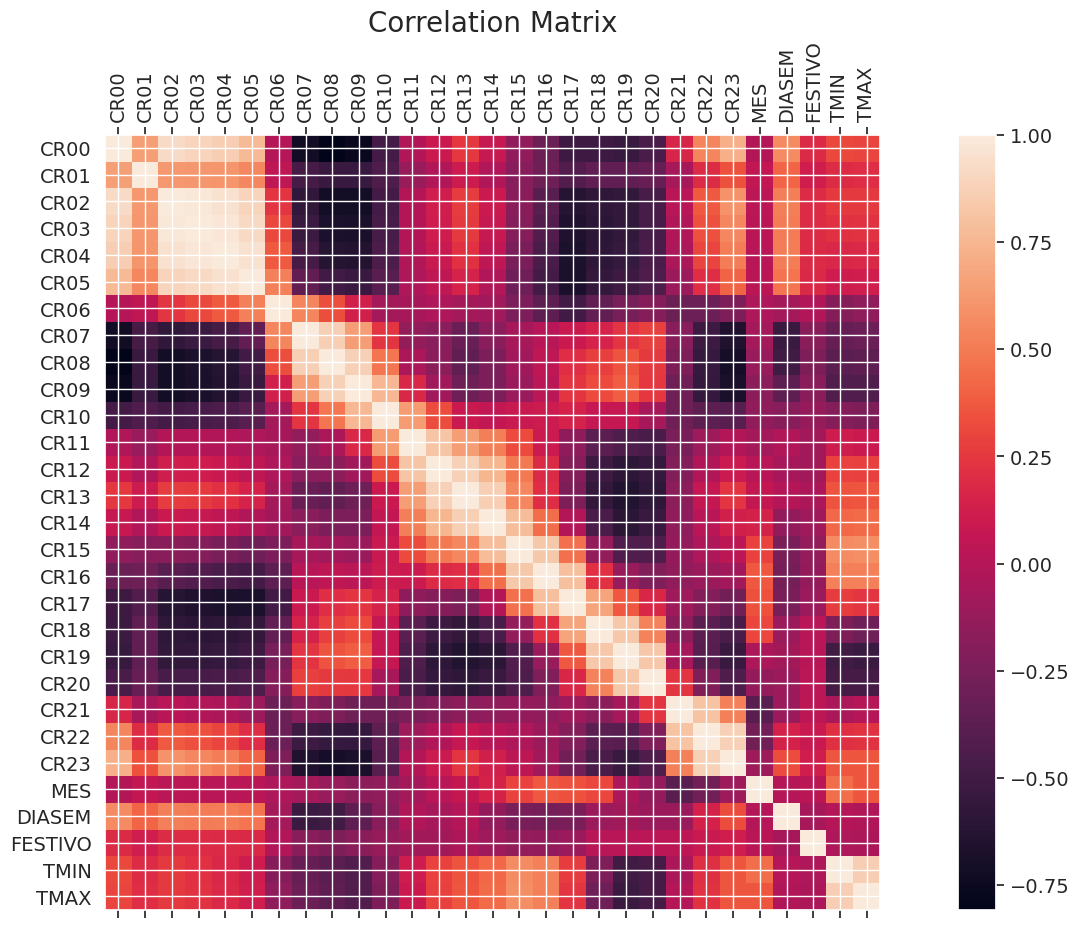

In [14]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
# Correlation plot of numeric variables
f = plt.figure(figsize=(20,10))
plt.matshow(df_aju.select_dtypes(include=['int64','float64']).corr(), fignum=f.number)

plt.xticks(range(df_aju.select_dtypes(include=['int64','float64']).shape[1]), 
           df_aju.select_dtypes(include=['int64','float64']).columns, fontsize=14, rotation=90)

plt.yticks(range(df_aju.select_dtypes(include=['int64','float64']).shape[1]), 
           df_aju.select_dtypes(include=['int64','float64']).columns, fontsize=14)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=20)
plt.show()

Se pueden apreciar correlaciones muy importantes entre algunos pares de variables. Sin especificar en detalle todas estas correlaciones debido a la existencia de un gran número de ellas, concuerdan con el perfil de demanda dado por lor periodos horarios de $\text{Valle}$, $\text{Llano}$ y $\text{Punta}$. Podemos apreciar que algunas de las más relevantes son:

- Correlación muy positiva entre los coeficientes de reparto del $CR00$ al $CR05$. Correspondientes a las horas $\text{Valle}$.
- Correlación muy negativa entre los coeficientes de reparto $CR00...CR05$ y los coeficientes de reparto $CR07...CR10$. Entre el $\text{Valle}$ y la $\text{Primera Punta}$.
- Correlación muy negativa entre los coeficientes de reparto $CR00...CR05$ y los coeficientes de reparto $CR16...CR20$. Entre el $\text{Valle}$ y la $\text{Segunda Punta}$.
- Correlación muy negativa entre los coeficientes de reparto $CR12...CR15$ y los coeficientes de reparto $CR18...CR20$. Entre el $\text{Llano}$ y la $\text{Segunda Punta}$.
- En general parece haber una correlación positiva entre coeficientes de reparto consecutivos, como $CR21$ y $CR22$, lo cual tiene cierto sentido desde un punto de vista lógico. Obviamente esta correlación es más clara en algunos casos que en otros.
- Correlación bastante positiva entre $T_{min}$ y $T_{max}$. También se observa que las temperaturas están correlacionadas con las horas de más y menos sol.

Hay que tener en cuenta que con este gráfico solamente somos capaces de detectar correlaciones lineales entre los datos, de forma que pueden existir otras correlaciones existentes que no sigan una relación estrictamente lineal, y que habrá que estudiar, si existen, más en detalle en siguientes puntos.

En la siguiente gráfica se muestra un gráfico interactivo que permite entender más en detalle como evoluciona la demanda en función de la hora. Se muestra en detalle el perfil de demanda dado por lor periodos horarios de $\text{Valle}$, $\text{Llano}$ y $\text{Punta}$:

In [15]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
df = pd.melt(df_aju.reset_index(), id_vars=["FECHA",'MES', 'DIASEM','FESTIVO', 'TMIN', 'TMAX'], value_vars=['CR00', 'CR01',
    'CR02', 'CR03', 'CR04', 'CR05', 'CR06', 'CR07', 'CR08', 'CR09', 'CR10', 'CR11', 'CR12', 'CR13', 'CR14', 'CR15', 'CR16', 
    'CR17', 'CR18', 'CR19', 'CR20', 'CR21', 'CR22', 'CR23'], var_name='HORA', value_name='DEMANDA')
df['FECHA'] = df['FECHA'].astype(str) + ' ' + df['HORA'].astype(str).str[2:]
df['FECHA'] = pd.to_datetime(df['FECHA'], format='%Y-%m-%d %H')
df = df.set_index('FECHA')
df.drop(columns=['HORA'],inplace=True)
df = df.sort_index()
festivo_mask=df.FESTIVO==1
fig = px.line(df, x=df.index, y="DEMANDA", title=f'Demanda horaria {df.index[0].year} - {df.index[-1].year}')
fig.add_scatter(x=df[festivo_mask].index, y=df[festivo_mask].DEMANDA, mode='markers', marker=dict(color='red', size=5),
    name='Festivos')
fig.update_xaxes(
    rangeslider_visible=True)
fig.update_xaxes(range=["2019-01-05", "2019-01-10"])
fig.add_vrect(x0="2019-01-07 00:00", x1="2019-01-07 08:00", annotation_text="Valle", annotation_position="top left", 
    fillcolor="green", opacity=0.25, line_width=0)
fig.add_vrect(x0="2019-01-07 08:00", x1="2019-01-07 13:00", annotation_text="Punta", annotation_position="top left",
    fillcolor="red", opacity=0.25, line_width=0)
fig.add_vrect(x0="2019-01-07 13:00", x1="2019-01-07 17:00", annotation_text="Llano", annotation_position="top left",
    fillcolor="blue", opacity=0.25, line_width=0)
fig.add_vrect(x0="2019-01-07 17:00", x1="2019-01-07 23:00", annotation_text="Punta", annotation_position="top left", 
    fillcolor="red", opacity=0.25, line_width=0)
fig.show()

#### Variables cuantitativas discretas

Con el uso de la función que se muestra abajo procedemos a estudiar si existe alguna relación entre la variable de salida y las variables cuantitativas discretas de nuestro dataset, que son concretamente:

- Día de la semana.
- Mes.

In [16]:
target = "FESTIVO"

In [17]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
def discrete_graph(df0, df1, input):
    plt.figure(figsize=(7, 3), dpi=150)
    plt.bar(x=df0[input].value_counts().sort_index().index, height=df0[input].value_counts(normalize=True).sort_index(), 
            align='edge', width=-0.4, color="royalblue", label="0")
    plt.bar(x=df1[input].value_counts().sort_index().index, height=df1[input].value_counts(normalize=True).sort_index(), 
            align='edge', width=0.4, color="midnightblue", label="1")
    plt.legend()
    title = input + ' distribution'
    plt.title(title)
    plt.ylabel('Relative Frequency')
    plt.xticks([i for i in range(df0[input].max()+1)])
    plt.show()

In [18]:
# This will helps us with the visualization
df_aju_0 = df_aju.loc[df_aju[target]==0]
df_aju_1 = df_aju.loc[df_aju[target]==1]
festivos=df_aju_1.index

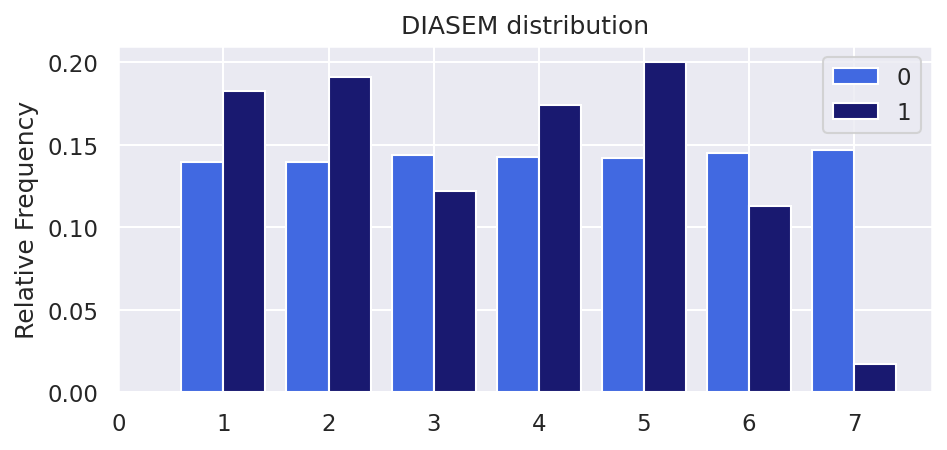

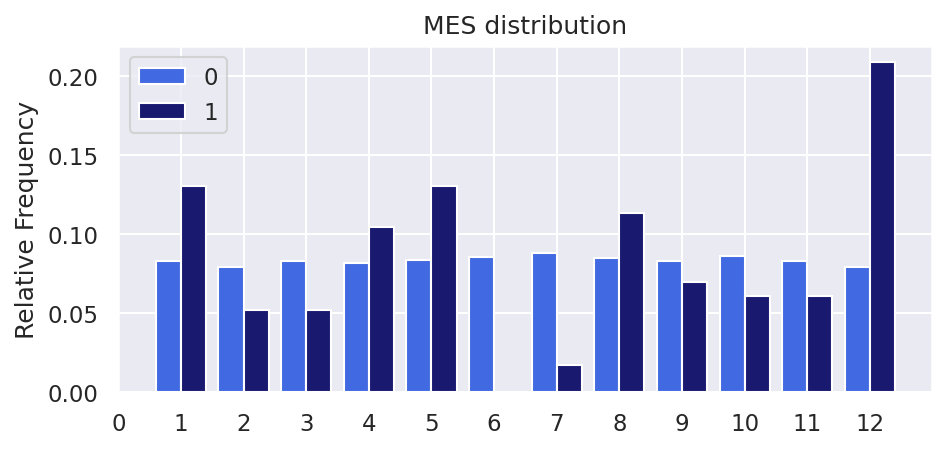

In [19]:
discrete = ["DIASEM", "MES"]
for variable in discrete:
    discrete_graph(df_aju_0, df_aju_1, variable)

Vemos que tanto el mes como el día de la semana parecen variables relevantes para predecir si un día es festivo o no.

**Respecto al día de la semana**:

Podríamos pensar que la relación existente entre el día de la semana se debe a que tenemos una muestra finita de datos, dado que cada año un día en concreto (por ejemplo el día de Navidad) se encuentra en el siguiente día de la semana (es decir, un año cae en lunes, al siguiente en martes, al siguiente en miércoles, etc). Sin embargo, si analizamos la cantidad de datos de los que disponemos:

In [20]:
len(df_aju)/365

7.887671232876713

Vemos que tenemos datos de prácticamente 8 años, por lo que esa diferencia entre días festivo por día de la semana no se debe a que tenemos datos de pocos años, sino a que realmente existe una relación. Por ejemplo, podemos ver que generalmente los festivos no caen en domingo, por que se suelen aplazar a otro día de la semana (típicamente los el viernes anterior y el lunes siguiente).

**Respecto al mes**:

Vemos que claramente hay meses que tienen más días festivos que otros, siendo Diciembre el mes con más días festivos del año, y Junio el que menos.

#### Variables cuantitativas continuas

Con el uso de la función que se muestra abajo procedemos a estudiar si existe alguna relación entre la variable de salida y las variables cuantitativas continuas de nuestro dataset. Concretamente, se muestra la distribución de la variable explicativa en cuestión, segmentando los datos por los valores de la variable de salida, ayudándonos a entender que variables pueden tener una mayor importancia a la hora de segmentar las observaciones correspondientes a la clase positiva y las observaciones correspondientes a la clase negativa. Adicionalmente, se muestra un boxplot de cada una de las variables de forma que se puede observar mejor la diferencia en media de ambas distribuciones o la presencia de outliers, entre otras cosas.

In [21]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
def continous_graph(df, input, target): 
    sns.set(rc={'figure.figsize':(16,5)})
    fig, axs = plt.subplots(ncols=2)
    
    dens_plot = sns.histplot(data = df, x = input, hue=target, kde = True, palette=['royalblue', 'midnightblue'], ax=axs[0])
    axs[0].set_title('Distribution of the variable', fontdict={'fontsize':15})
    axs[0].axvline(x=df.loc[df[target] == 0][input].mean(), color='royalblue', ls='--')
    axs[0].axvline(x=df.loc[df[target] == 1][input].mean(), color='midnightblue', ls='--')

    boxplot = sns.boxplot(data=df , y=input, x=target, palette=['#6E91FF', '#00175F'], 
                          width=0.3, ax=axs[1], **{'medianprops':{'color':'gray'}})
    axs[1].set_ylabel(input, fontdict={'fontsize':15})   
    axs[1].set_title('Boxplot for each value of the target variable', fontdict={'fontsize':15})
    plt.show()
    return(dens_plot, boxplot)

In [22]:
#set categories
df_aju=df_aju.astype({'DIASEM': 'category', 'MES': 'category', 'FESTIVO': 'category'})

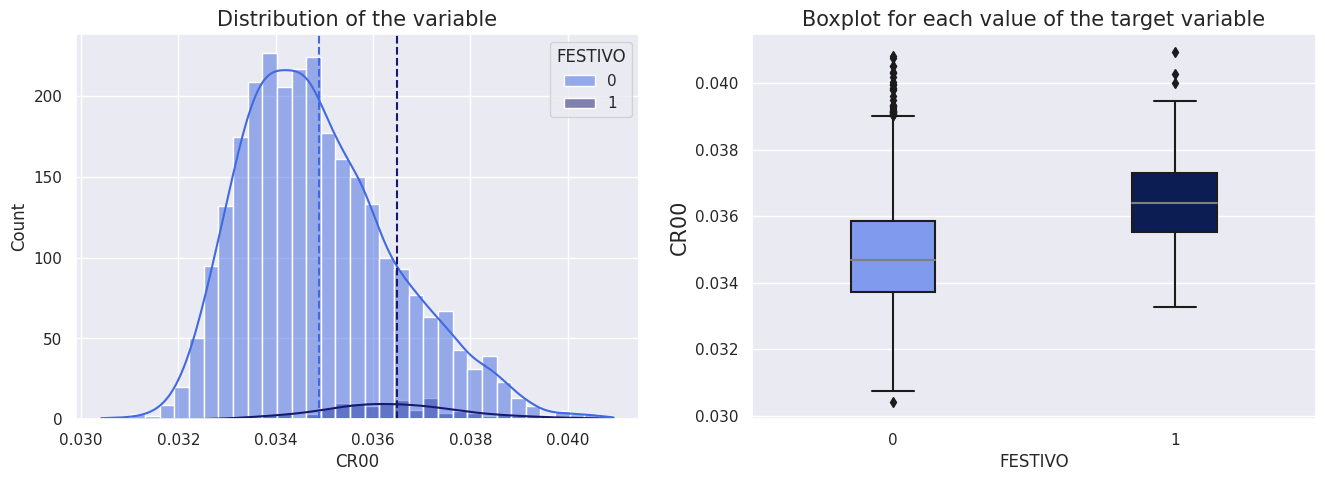

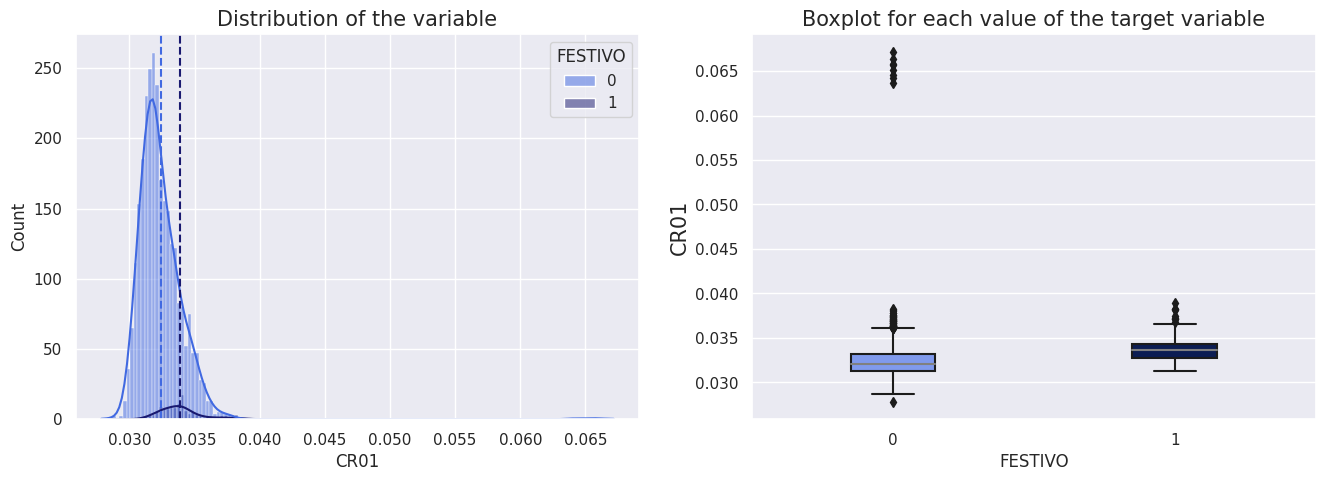

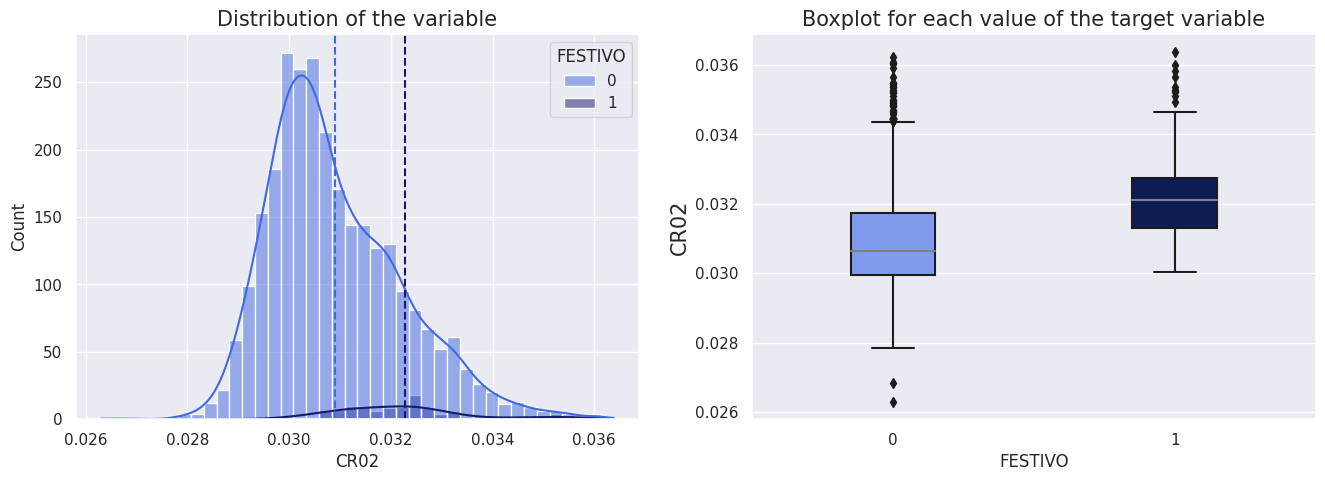

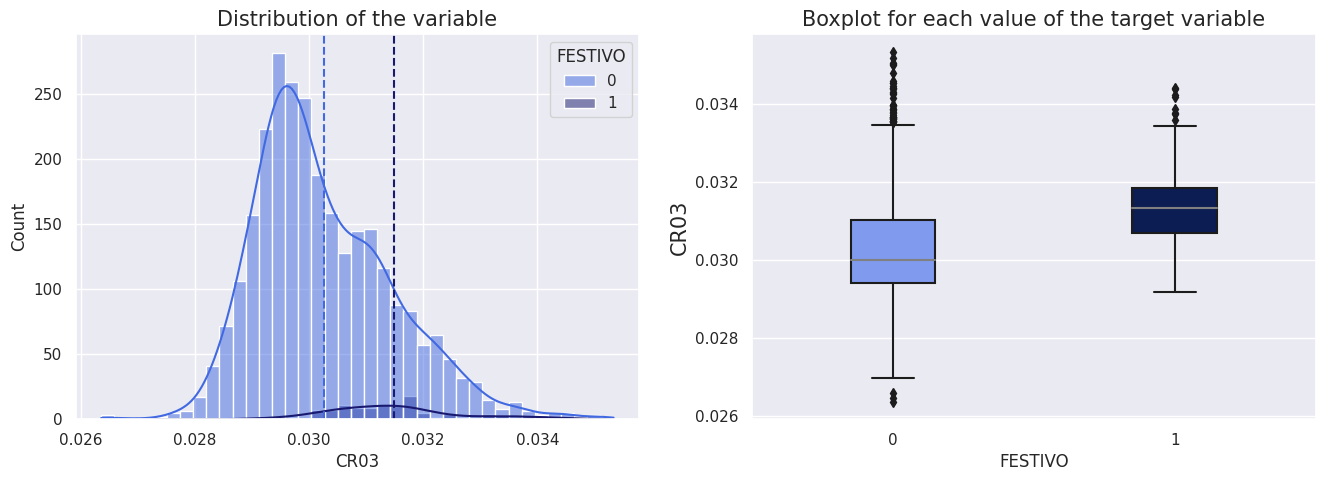

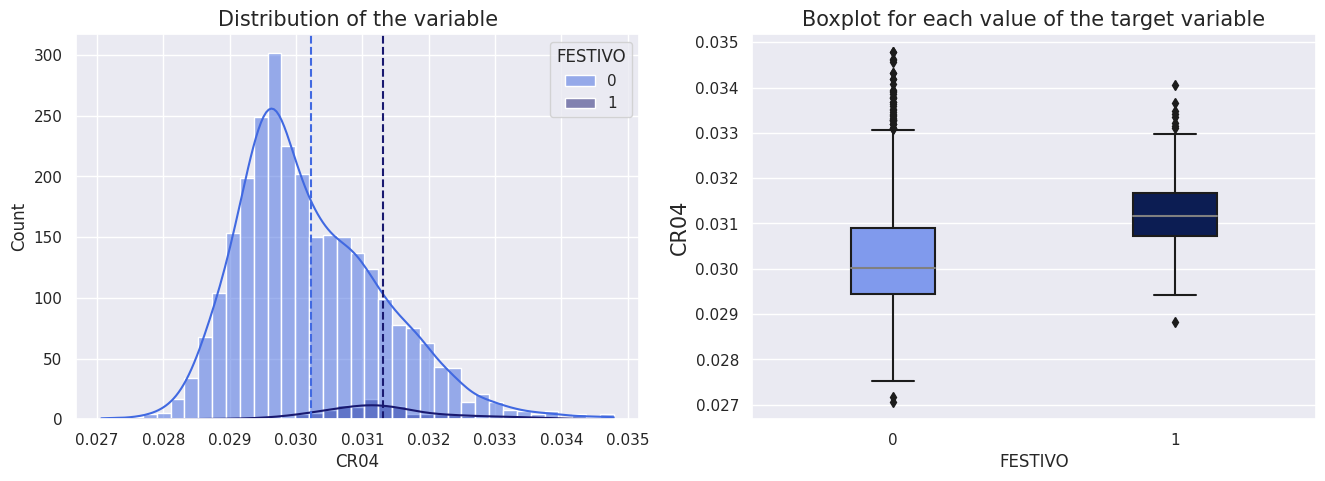

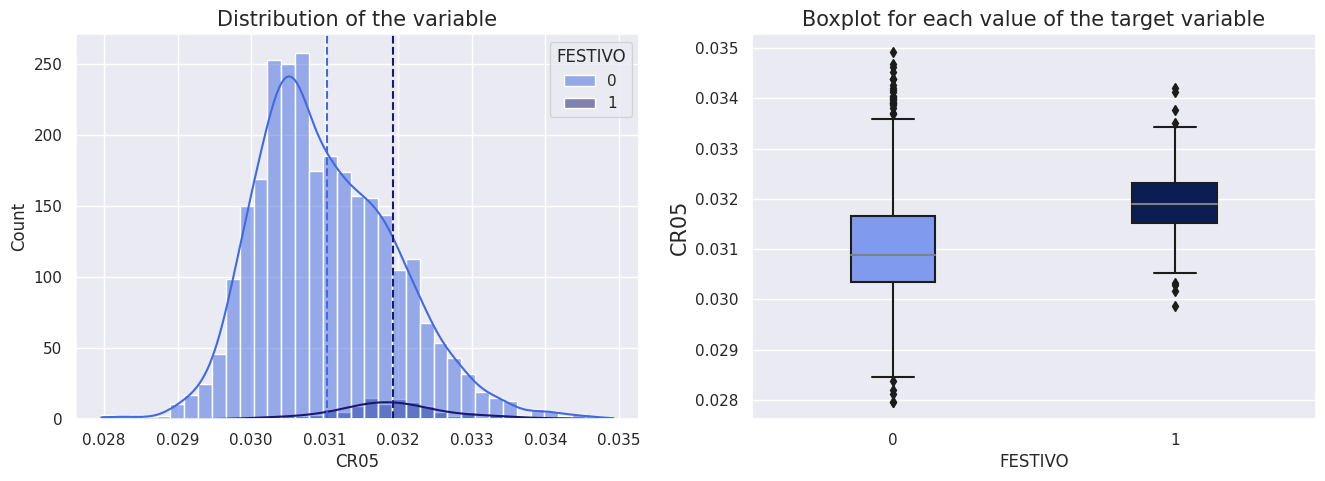

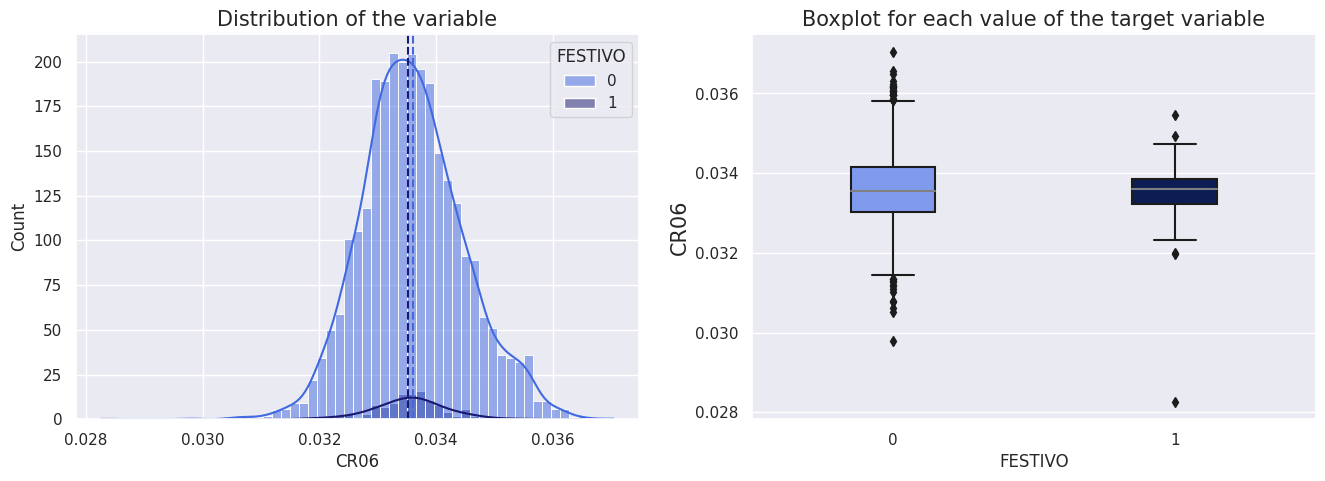

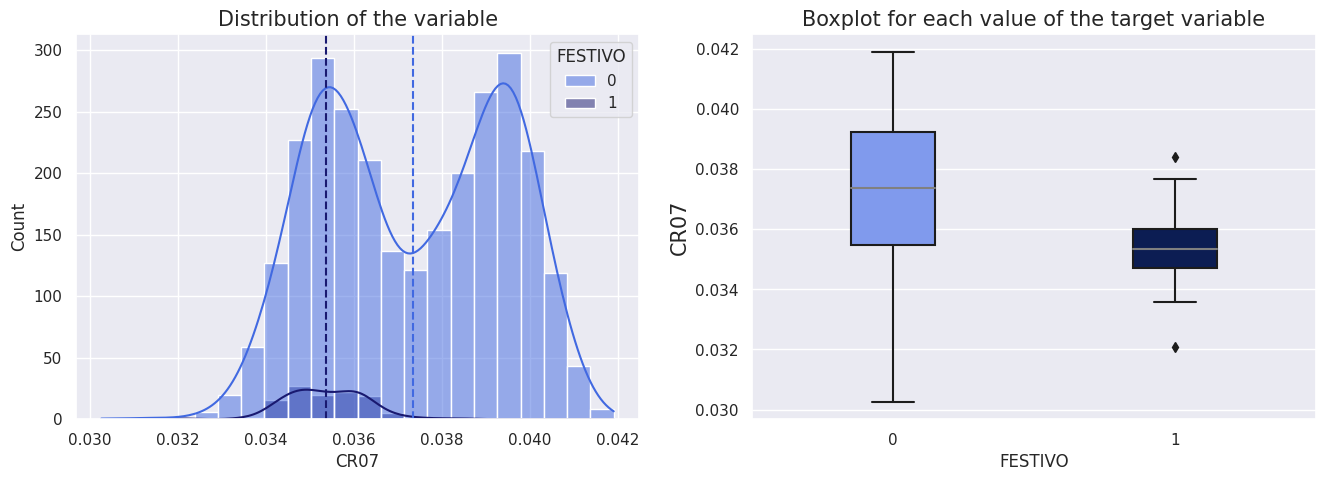

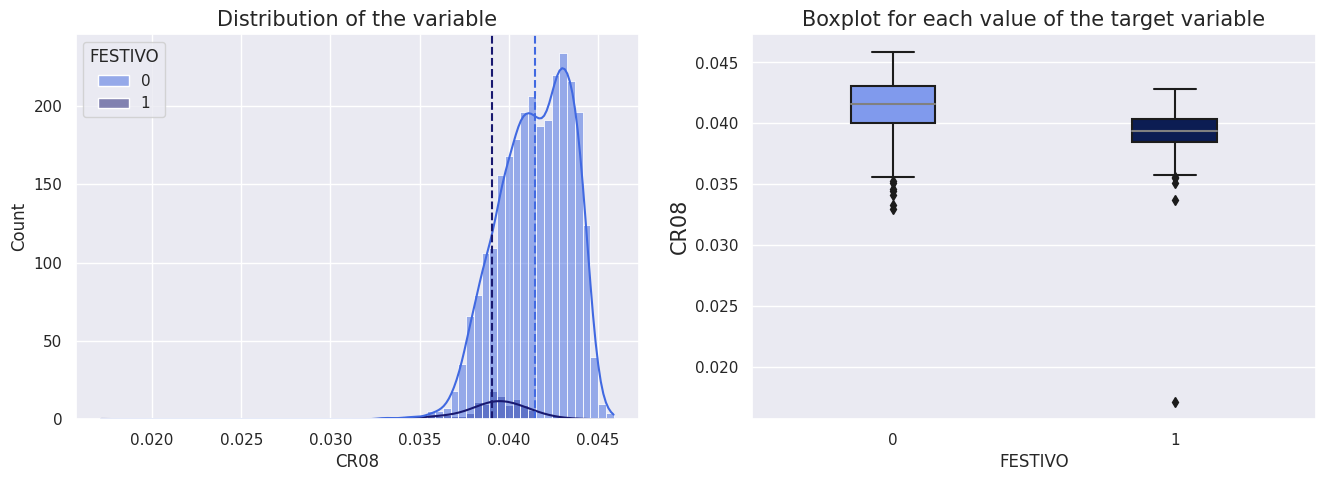

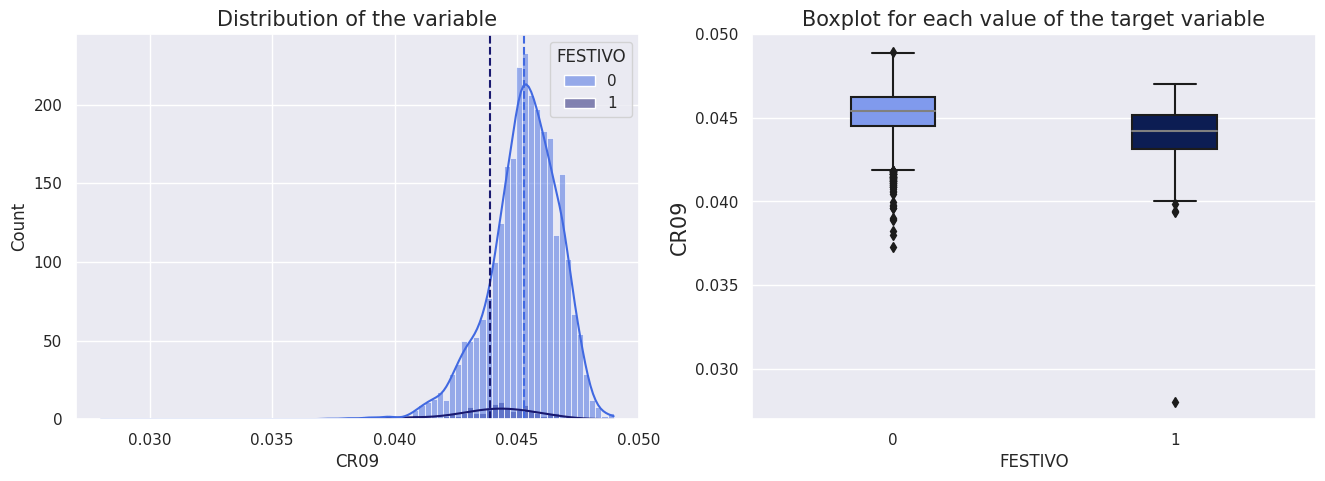

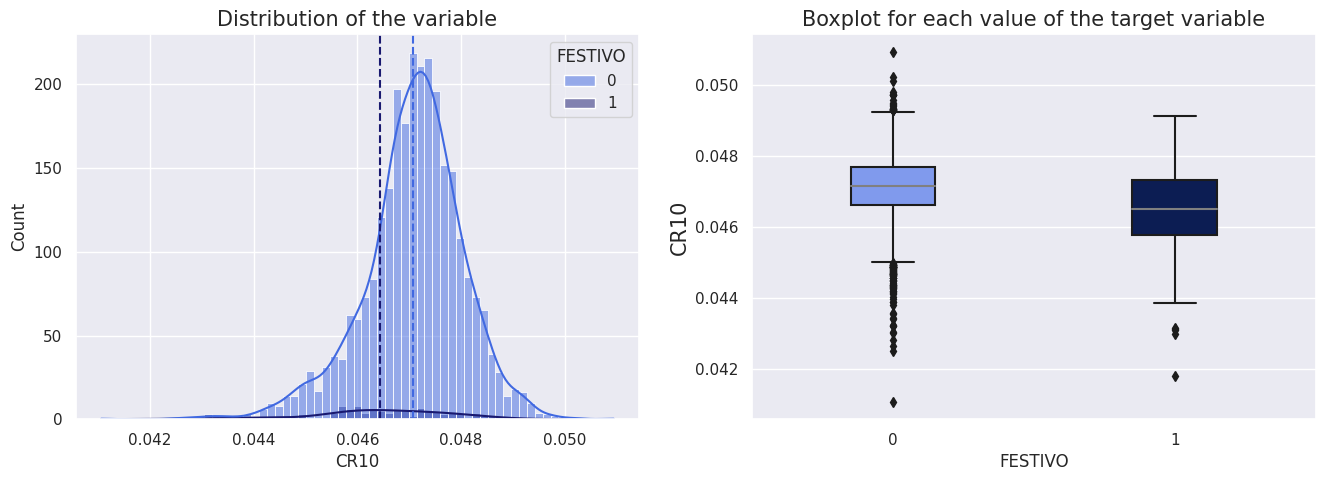

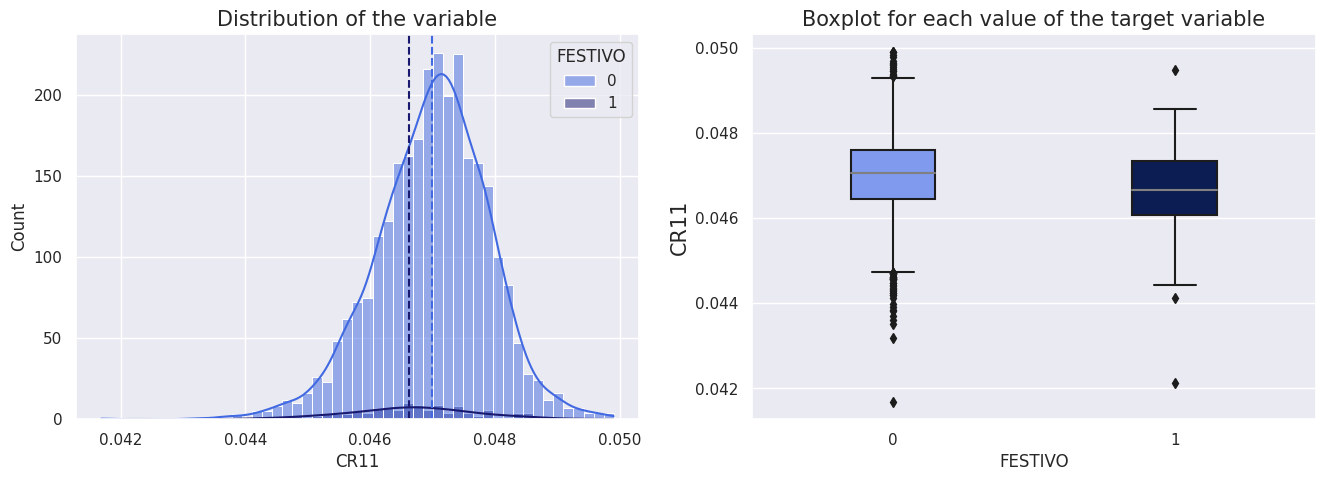

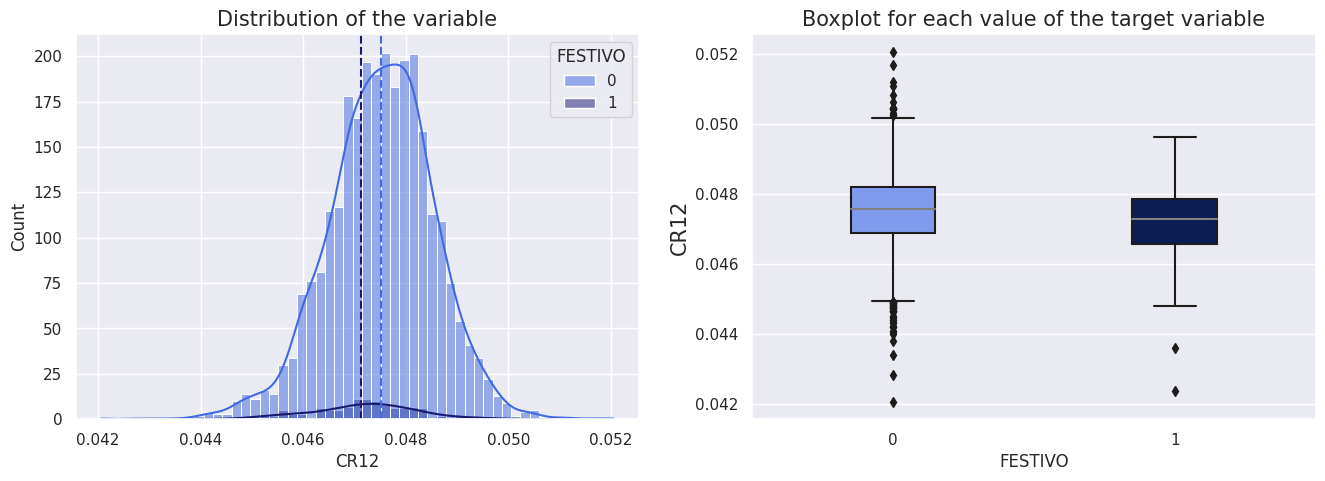

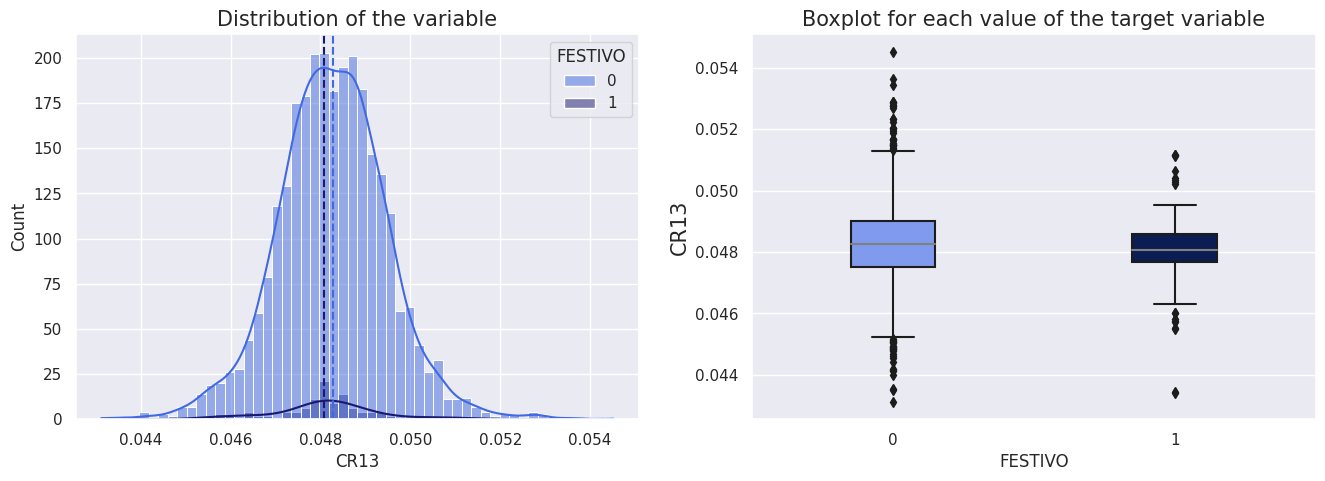

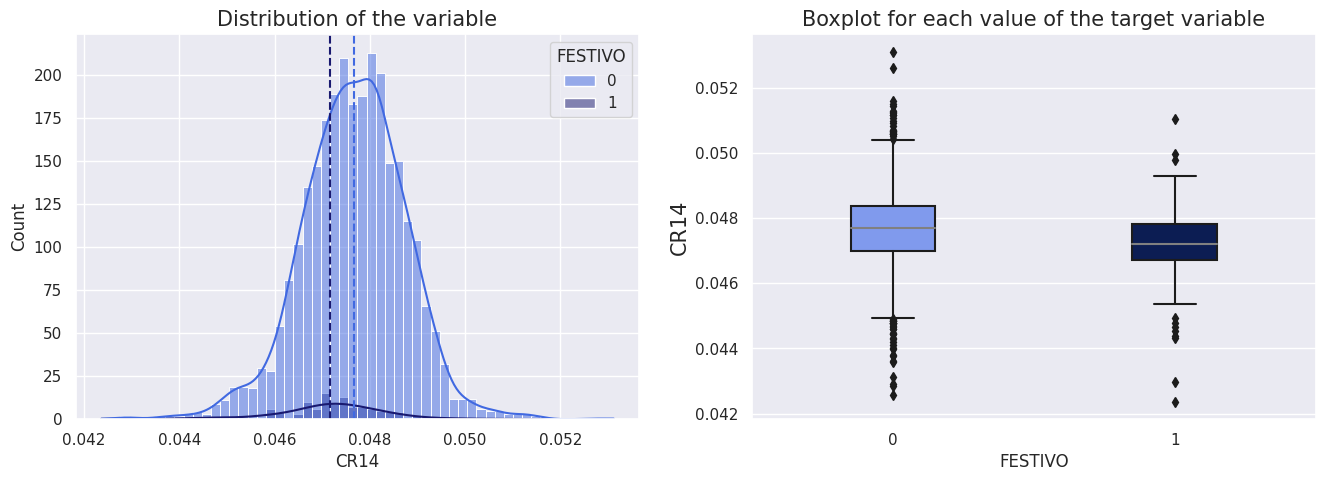

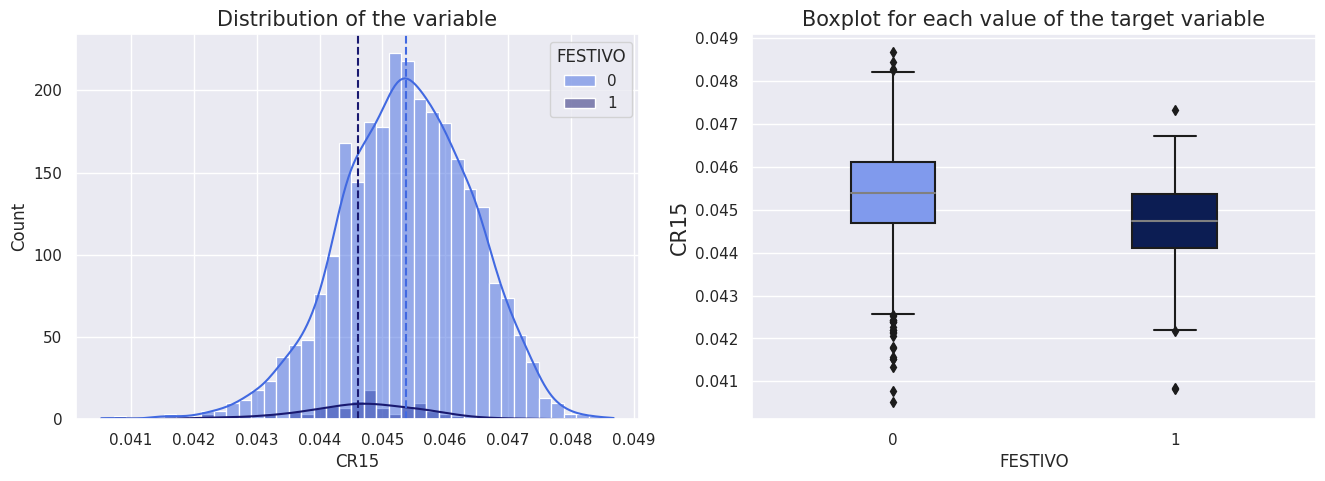

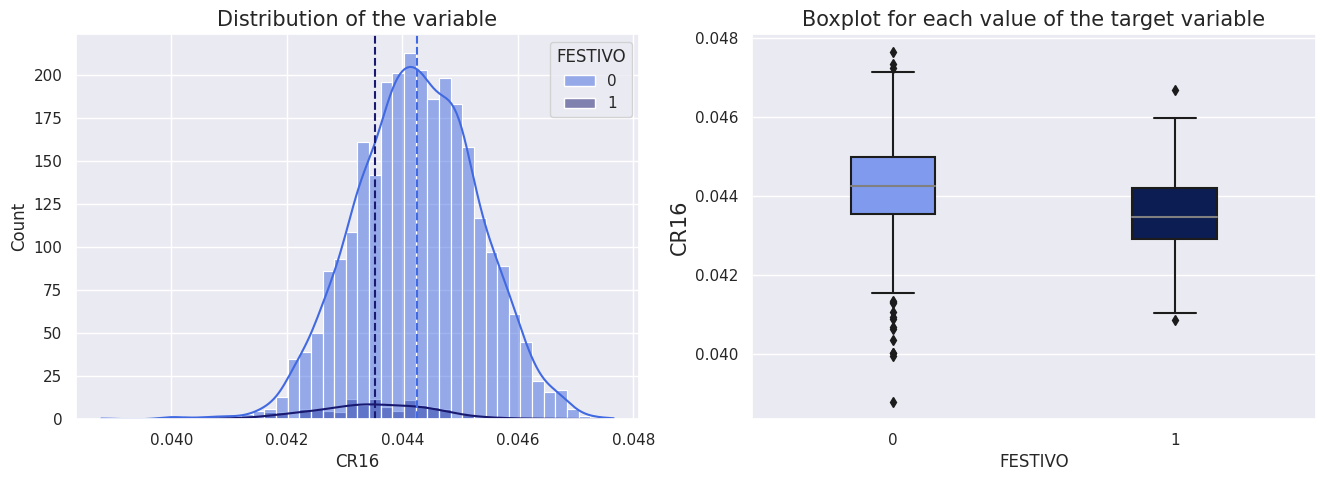

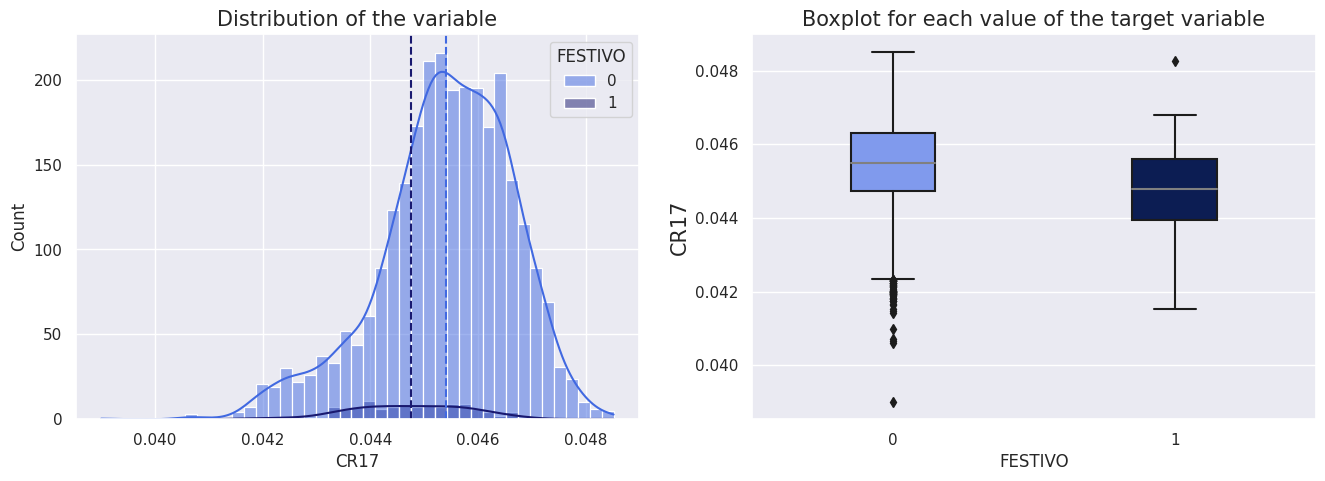

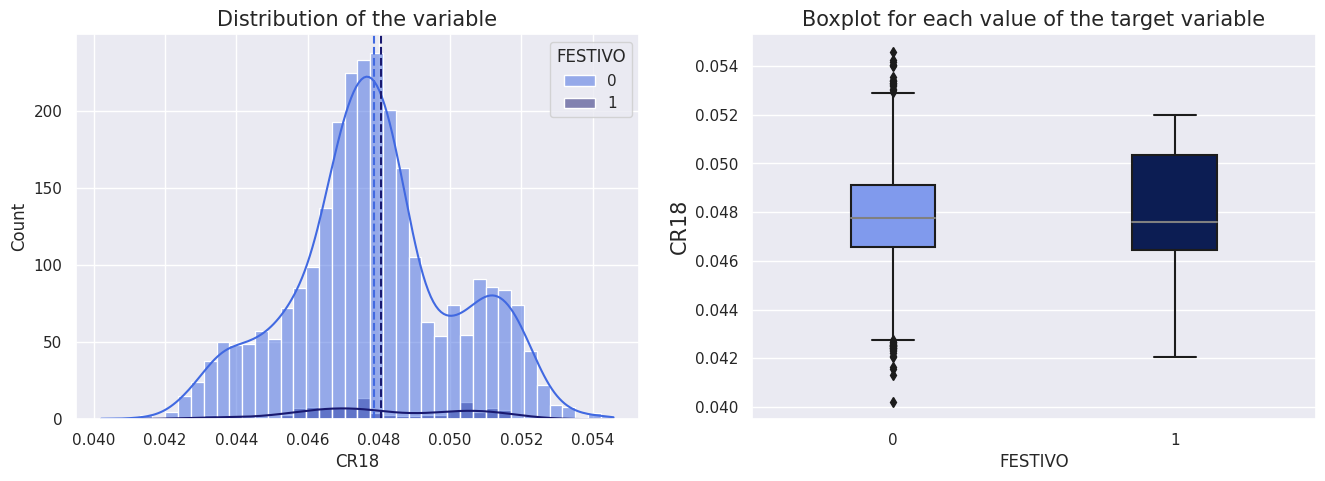

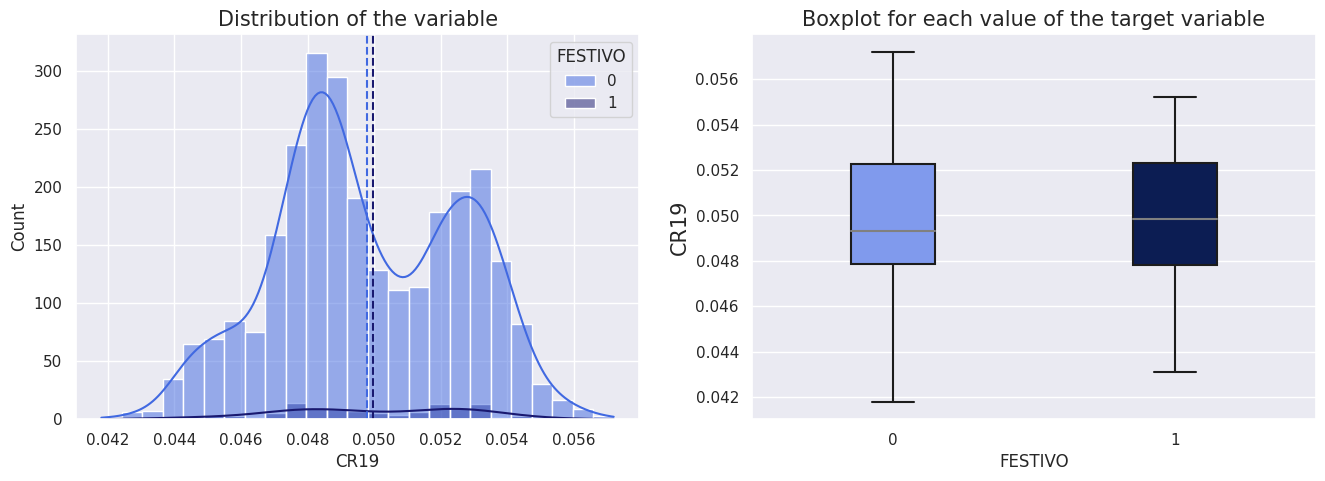

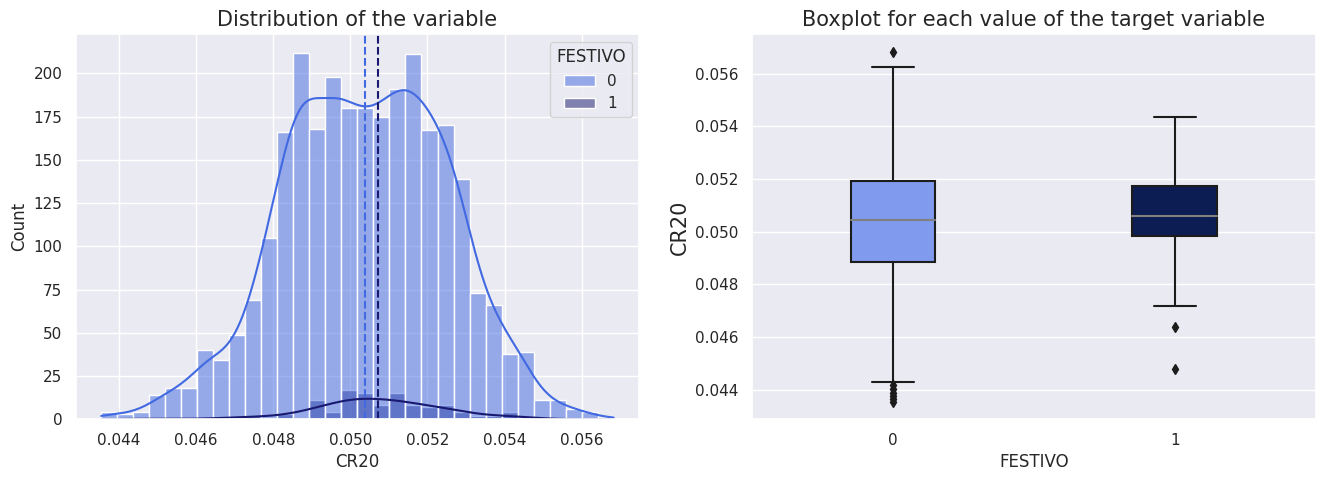

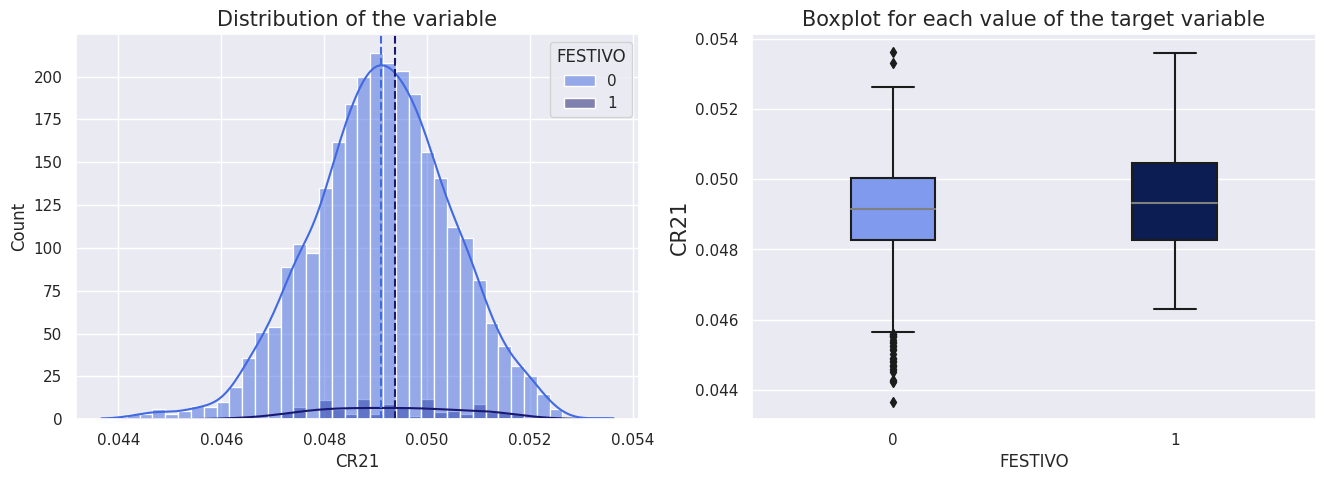

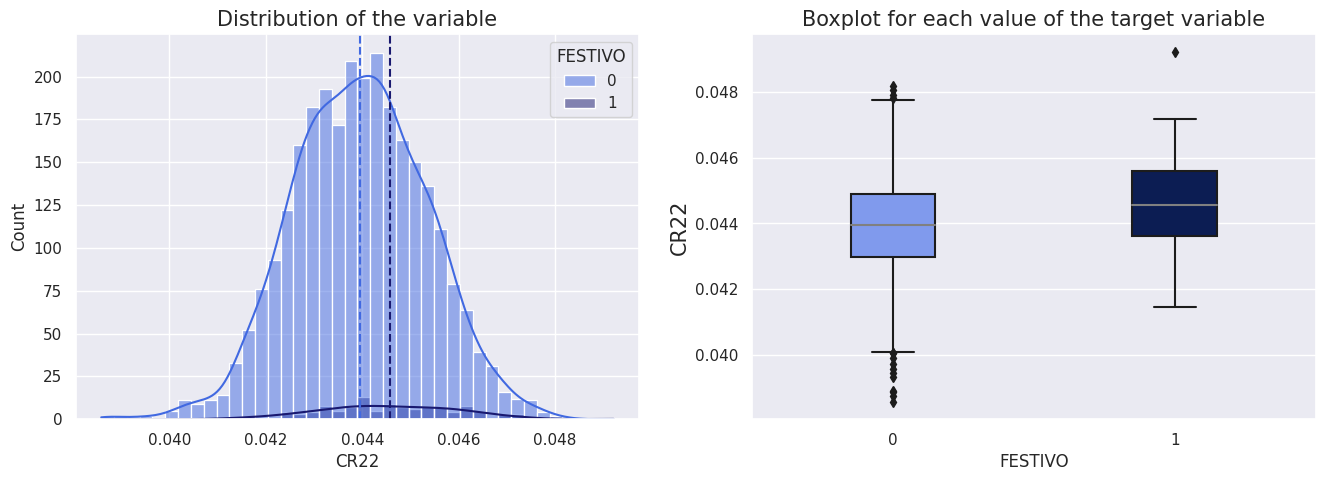

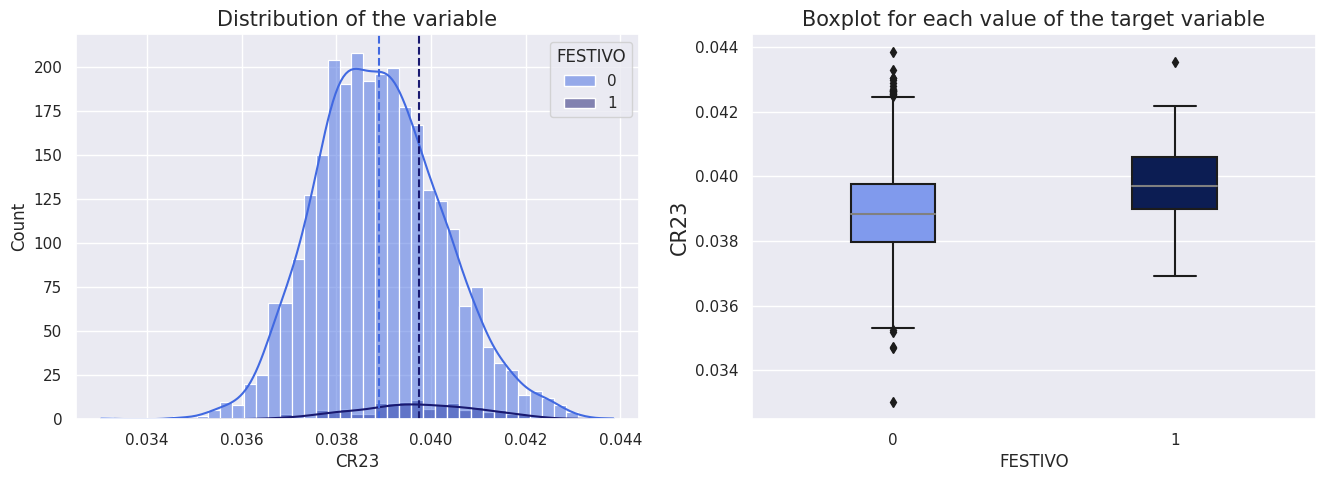

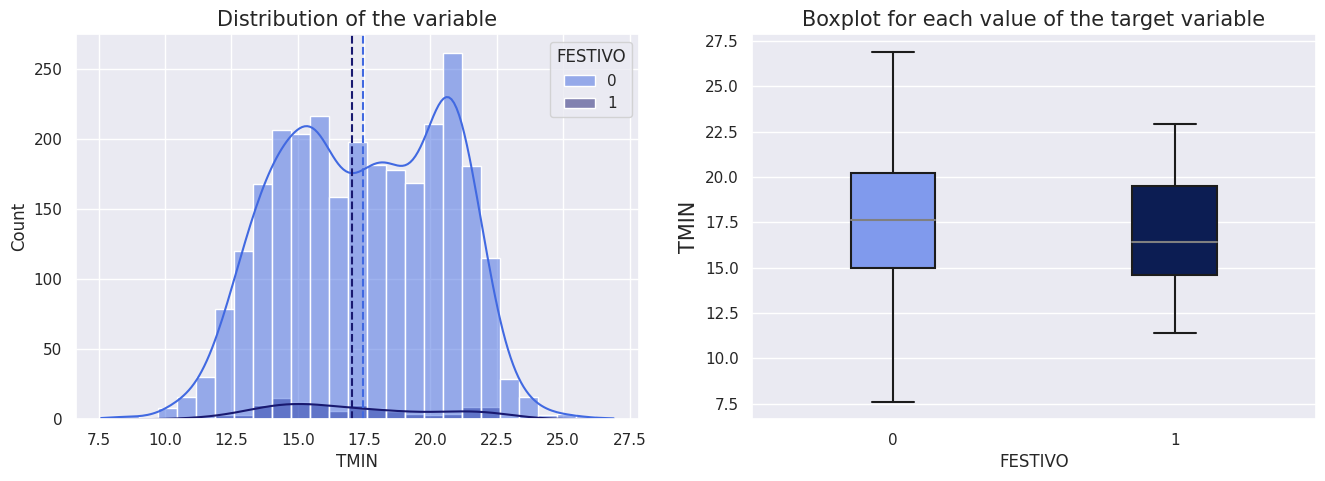

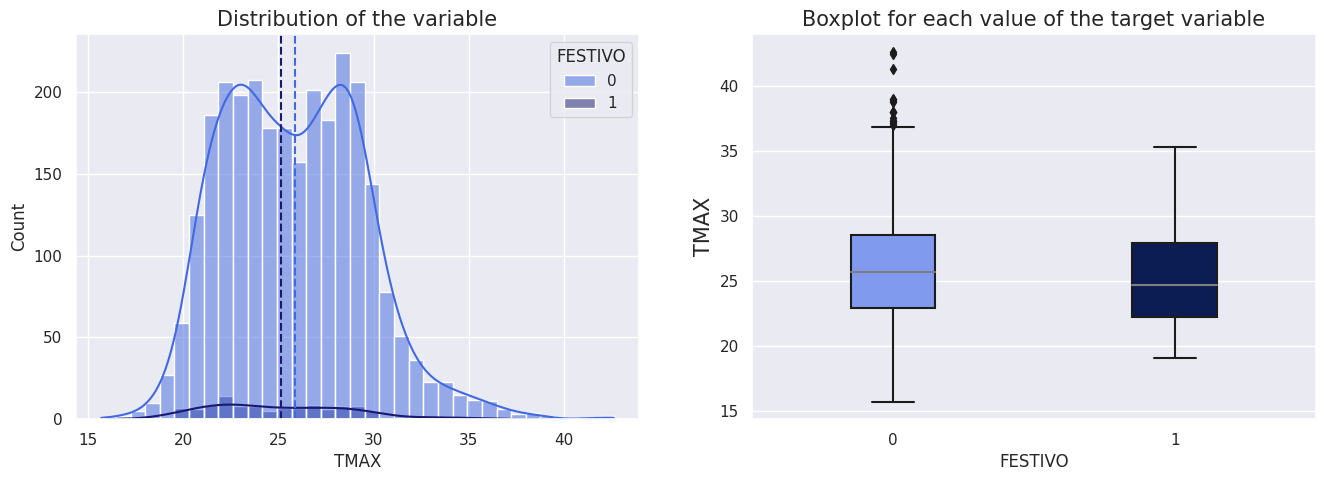

In [23]:
continuous = df_aju.select_dtypes(include=['float64', 'int64']).columns.to_list()
for variable in continuous:
    continous_graph(df_aju, variable, target)

Pese a que no se aprecia tan claramente la distribución correspondiente a los días festivos, gracias a los boxplots, así como a las medias de las distribuciones (líneas discontinuas verticales), podemos apreciar que no para todas las variables la media de ambas distribuciones son igual de parecidas. En consecuencia, podemos apreciar que algunas variables parecen ser más útiles de cara a discriminar días festivos de días no festivos, como por ejemplo:

- $CR00$
- $CR07$
- $CR08$

Asimismo, la distribución de algunas variables presenta un mayor nivel de asimetría, como por ejemplo:

- $CR01$
- $CR02$
- $CR09$

Es bastante probable que la asimetría por ejemplo que se observa a las 2 de la mañana, que podemos comprobar en los boxplots que se debe a unos pocos datos, se deba a fechas muy concretas donde la gente estaba despierta hasta más tarde de lo normal, como por ejemplo puede ser el día de Nochevieja. Si obtenemos dichos datos en detalle:

In [24]:
df_aju.loc[df_aju["CR02"]>0.035].index.to_list()

[Timestamp('2014-01-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00'),
 Timestamp('2016-01-01 00:00:00'),
 Timestamp('2018-01-01 00:00:00'),
 Timestamp('2019-01-01 00:00:00'),
 Timestamp('2020-01-01 00:00:00'),
 Timestamp('2020-04-10 00:00:00'),
 Timestamp('2020-05-03 00:00:00'),
 Timestamp('2020-05-10 00:00:00'),
 Timestamp('2020-05-17 00:00:00'),
 Timestamp('2020-05-24 00:00:00'),
 Timestamp('2020-05-30 00:00:00'),
 Timestamp('2020-05-31 00:00:00'),
 Timestamp('2020-06-06 00:00:00'),
 Timestamp('2020-06-07 00:00:00'),
 Timestamp('2020-06-14 00:00:00'),
 Timestamp('2020-06-20 00:00:00'),
 Timestamp('2020-06-21 00:00:00'),
 Timestamp('2020-06-25 00:00:00'),
 Timestamp('2020-06-28 00:00:00'),
 Timestamp('2020-07-05 00:00:00'),
 Timestamp('2020-07-12 00:00:00'),
 Timestamp('2020-07-19 00:00:00'),
 Timestamp('2020-08-09 00:00:00'),
 Timestamp('2020-08-30 00:00:00'),
 Timestamp('2020-09-27 00:00:00'),
 Timestamp('2021-01-01 00:00:00')]

Vemos que muchas de esas fechas fueron efectivamente los días de Nochevieja. El resto de fechas corresponden a la época del confinamiento durante el Covid-19, que suponen una situación anómala en cuanto a consumo energético se refiere.

Mientras que otras parecen alejarse de una distribución normal, y parecen seguir una distribución bimodal, como:

- $CR07$
- $CR19$
- $CR19$

Respecto a este último punto, es muy probable que esta distribución bimodal se deba a las diferentes épocas del año. Por ejemplo, en invierno a las 7 de la mañana, es muy probable que se produzca un aumento del consumo de energía debido a que en muchas viviendas y oficinas se empiece a usar la calefacción. Sin embargo, en verano, a esa hora no suele hacer generalmente tanto calor como para tener que hacer uso del aire acondicionado, dando lugar a un consumo menor de energía, y en consecuencia, un menor coeficiente de reparto.

Por ejemplo, si analizamos concretamente el coeficiente de reparto $CR07$:

In [25]:
df_aju.loc[df_aju["CR07"]>0.037].loc[:, "MES"].value_counts(ascending=False)

10    167
11    161
3     155
2     151
1     149
5     141
4     137
12    129
9     119
6     109
7      27
8      21
Name: MES, dtype: int64

Vemos que para valores mayores a $0.037$ (es decir, pasado el primer pico de la distribución), la mayoría de valores corresponden a meses donde hace más frío.

Si hacemos la misma comprobación pero a la inversa:

In [26]:
df_aju.loc[df_aju["CR07"]<0.037].loc[:, "MES"].value_counts(ascending=False)

8     226
7     219
6     127
9     119
12    113
5     105
4     101
1      96
3      81
10     78
11     75
2      73
Name: MES, dtype: int64

Podemos comrpobar que generalmente cuando el coeficiente de reparto es menor es para meses más cálidos, confirmando nuestra hipótesis inicial.

### Outliers

Vamos también a ver el porcentaje de outliers que tiene cada variable haciendo uso de diversos métodos de calculo univariable de outliers a través de la clase `OutlierManager` que proporciona el % Porcentaje de outliers y el índice en el que se encuentran a través de métodos como:

- Rangos intercuartílicos
- Desviación estadar: Aplica a aquellas distribuciones normales de los datos

Nos centramos en el $\text{IQR}$:

In [27]:
outliers = OutlierManager()

In [30]:
out = outliers.summary(df_aju)[["IQR_1.5", "STD_3"]]
out

IQR_1.5  \
CR00 % Percentage Outliers                                           0.937826   
     INDEX                  [2014-01-01 00:00:00, 2014-07-13 00:00:00, 201...   
CR01 % Percentage Outliers                                           1.736714   
     INDEX                  [2014-01-01 00:00:00, 2014-07-13 00:00:00, 201...   
CR02 % Percentage Outliers                                           1.563043   
     INDEX                  [2014-01-01 00:00:00, 2015-01-01 00:00:00, 201...   
CR03 % Percentage Outliers                                           1.563043   
     INDEX                  [2014-01-01 00:00:00, 2015-01-01 00:00:00, 201...   
CR04 % Percentage Outliers                                           1.389371   
     INDEX                  [2014-01-01 00:00:00, 2016-01-01 00:00:00, 201...   
CR05 % Percentage Outliers                                           1.007294   
     INDEX                  [2014-11-13 00:00:00, 2017-04-17 00:00:00, 201...   
CR06 % Percentage Outliers                                           1.424106   
     INDEX                  [2014-08-09 00:00:00, 2014-11-13 00:00:00, 201...   
CR07 % Percentage Outliers                                                0.0   
     INDEX                                                                 []   
CR08 % Percentage Outliers                                           0.312609   
     INDEX                  [2014-07-17 00:00:00, 2019-01-01 00:00:00, 202...   
CR09 % Percentage Outliers                                           2.361931   
     INDEX                  [2014-01-01 00:00:00, 2014-07-13 00:00:00, 201...   
CR10 % Percentage Outliers                                           3.924974   
     INDEX                  [2014-01-01 00:00:00, 2014-06-29 00:00:00, 201...   
CR11 % Percentage Outliers                                           1.910386   
     INDEX                  [2014-01-01 00:00:00, 2014-01-06 00:00:00, 201...   
CR12 % Percentage Outliers                                           1.840917   
     INDEX                  [2014-01-01 00:00:00, 2014-01-02 00:00:00, 201...   
CR13 % Percentage Outliers                                           2.257728   
     INDEX                  [2014-01-01 00:00:00, 2014-01-03 00:00:00, 201...   
CR14 % Percentage Outliers                                           2.222994   
     INDEX                  [2014-01-01 00:00:00, 2014-01-03 00:00:00, 201...   
CR15 % Percentage Outliers                                           1.042028   
     INDEX                  [2014-01-01 00:00:00, 2014-01-06 00:00:00, 201...   
CR16 % Percentage Outliers                                           0.555749   
     INDEX                  [2014-01-01 00:00:00, 2014-01-06 00:00:00, 201...   
CR17 % Percentage Outliers                                           2.014588   
     INDEX                  [2020-03-22 00:00:00, 2020-03-23 00:00:00, 202...   
CR18 % Percentage Outliers                                           1.319903   
     INDEX                  [2014-11-06 00:00:00, 2014-11-13 00:00:00, 201...   
CR19 % Percentage Outliers                                                0.0   
     INDEX                                                                 []   
CR20 % Percentage Outliers                                           0.277874   
     INDEX                  [2015-02-10 00:00:00, 2020-05-29 00:00:00, 202...   
CR21 % Percentage Outliers                                           1.076763   
     INDEX                  [2014-02-18 00:00:00, 2014-07-17 00:00:00, 201...   
CR22 % Percentage Outliers                                           0.590483   
     INDEX                  [2014-07-17 00:00:00, 2014-07-27 00:00:00, 201...   
CR23 % Percentage Outliers                                            0.72942   
     INDEX                  [2014-06-22 00:00:00, 2014-07-13 00:00:00, 201...   
TMIN % Percentage Outliers                                                0.0   
     INDEX          

Vemos que en ningún caso se supera el porcentaje de crítico del $5\%$ que típicamente se toma como umbral para determinar si el porcentaje de outliers es excesivo. Vemos adicionalmente que en algunos casos este porcentaje es mayor que en otros, como por ejemplo de la variable explicativa $CR10$ donde el porcentaje es prácticamente del $4\%$.

Por otro lado, se pueden estudiar los outliers con un enfoque multivariable por registro. Esto se puede hacer a través del algoritmo `Isolation Forest` que `sklearn` proporciona. Este algoritmo se basa en la construcción de un conjunto de árboles de decisión aleatorios donde objetivo del algoritmo es identificar observaciones anómalas (outliers) en un conjunto de datos que puedan diferir significativamente del resto de las observaciones. El algoritmo funciona dividiendo repetidamente el conjunto de datos en subconjuntos aleatorios mediante la selección de variables aleatorias y valores de corte aleatorios en cada iteración. Las observaciones anómalas tienden a requerir menos divisiones para ser aisladas, lo que significa que se encuentran en hojas más pequeñas de los árboles de decisión y, por lo tanto, tienen una profundidad menor. 

Este tipo de algoritmos no cuenta con una métrica estándar como pueden ser los rangos intercuartílicos o `n` número de desviaciones estándar. La definición de outliers sobre un espacio multivariable es más relativa, por lo que el algoritmo obtiene los registros más extremos según un porcentaje de registros a extraer. Hemos observado que existen $115$ festivos por lo que ajustando el parámetro de outliers a considerar 115 registros equivalen al $3,99\%$ de los registros totales, ello con la intención de observar si dichos outliers corresponden directamente con festivos o domingos. Se utiliza de nuevo la clase `OutliersManager`, que además ploteara sobre las tres componentes principales de los datos, los outliers identificados según la contaminación `-porcentaje de outliers esperados-`. Dependiendo de la cantidad de varianza representada la visualiación de los outliers será más o menos fiable. Esto no quiere decir que los outliers sean menos fiables sino que la representación sobre las tres dimensiones puede que no sea tan real.

In [31]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
iso_outliers = outliers.detect_outlier_multivariable_isolation_forest(df_aju,contaminacion=0.0399,random_state=2023)
iso_outliers = pd.to_datetime(iso_outliers[iso_outliers['MULTIVARIABLE_ISO_FOREST_0.0399']==True].index)

Nº de Outliers:  115 ,  % de Outliers:  3.9944425147620697 %
The PCA is only for plotting purposes, the model is not trained with it. The model is trained with the original data. Model arguments are: contamination=0.0399, n_estimators=500, max_samples=0.4, max_features=1.0, bootstrap=True, n_jobs=-1, random_state=2023, verbose=0, warm_start=False


In [32]:
print("Numero de outliers coincidentes con los festivos :", len(festivos.intersection(iso_outliers)), "de 115")

Numero de outliers coincidentes con los festivos : 15 de 115


El porcentaje de varianza representanda es del $72$ % por lo que la gráfica es meramente orientativa y no representa la realidad visualizada. El número de outliers detectado dado los $115$ registros más aislados del conjunto de datos coinciden con $15$ de los $115$ festivos, lo que indica que gran parte de los outliers no tienen por qué ser festivos. Es posible que sean domingos, por ello a continuación realizamos un bar plot de los 115 registros mas aislados no coincidentes con los festivos:

In [33]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
#barplot of the day of the iso_outliers value counts with plotly
iso_outliers_non_coincidence=iso_outliers.difference(festivos.intersection(iso_outliers))
fig = px.bar(x=iso_outliers_non_coincidence.day_name().value_counts(normalize=True).sort_values(ascending=False).index,
            y=iso_outliers_non_coincidence.day_name().value_counts(normalize=True).sort_values(ascending=False).values,
            labels={'x':'Dia de la semana', 'y':'Frecuencia Relativa'})
fig.update_layout(title_text='115 registros más aislados detectados por Isolation Forest no coincidentes con festivos')
fig.show()


Se observa que la mayoría de los $115$ registros más aislados son domingos y sabados. Con esto se puede concluir que hay más outliers correspondientes a domingos y sabados que a los festivos etiquetados en el modelo `-etiqueta_festivo =! domingo-` correspondientes a outliers.

#### Prepara los conjuntos de entrenamiento y test

- Divide los datos disponibles de ajuste (df_aju) en dos conjuntos diferentes (TR:80% y TS: 20%). TS lo deberías de utilizar para validar la calidad de los diferentes modelos que se creen.
- Recuerda fijar una semilla para garantizar que la separación es reproducible

Es importante en los problemas de clasificación asegurarse de que el porcentaje de datos que pertenece a cada clase es el mismo en ambos datasets (train y test), de forma que que ambos datasets son representativos de la población de salida. Para ello, usaremos la clase `StratifiedShuffleSplit` de `scikit-learn`. De esta forma, la frecuencia relativa de la variable de salida es la misma en ambos sets.

In [34]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

# Crea dos dataframes df_aju_tr y df_aju_ts y trabaja con ellos
df_aju.reset_index(inplace=True)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2023)
for train_index, test_index in split.split(df_aju, df_aju[target]):
    df_aju_tr = df_aju.loc[train_index]
    df_aju_ts = df_aju.loc[test_index]

Tras dividir los datos en training y test vamos a comprobar que efectivamente la frecuencia relativa de las dos clases de la variable de salida es prácticamente idéntico en ambos casos.

In [35]:
df_aju_tr[target].value_counts(normalize=True).sort_index()

0    0.960052
1    0.039948
Name: FESTIVO, dtype: float64

In [36]:
df_aju_ts[target].value_counts(normalize=True).sort_index()

0    0.960069
1    0.039931
Name: FESTIVO, dtype: float64

Vemos que efectivamente esa condición se cumple. Adicionalmente, podemos comprobar que las clases están totalmente desbalanceadas, lo cual se debe a que hay muchos más días festivos que no festivos. 

Si analizamos visualmente el balanceo de clases existente:

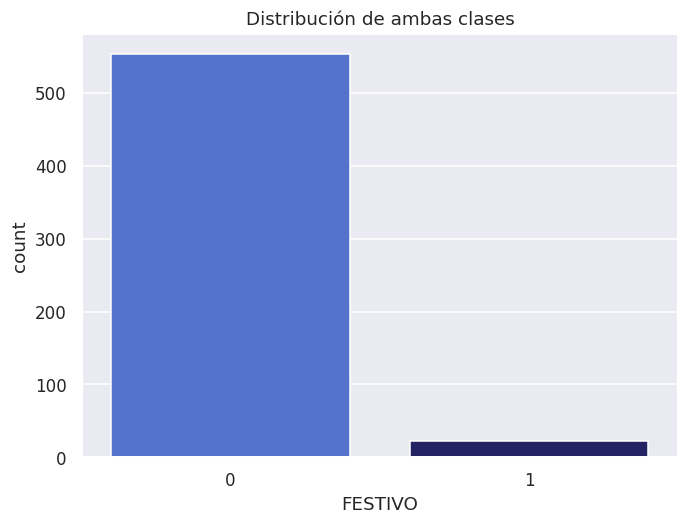

In [37]:
plt.figure(figsize=(7,5), dpi=110)
sns.countplot(x=df_aju_ts[target], palette=['royalblue', 'midnightblue'])
plt.title('Distribución de ambas clases')
plt.show()

El desbalanceo de clases genera que los modelos sufran de overfitting. Esto es muy común en problemas como por ejemplo la detección de fraude, donde se disponen de mucho más datos de la clase negativa que de la clase positiva. Por ello, para obtener un modelo que produzca buenos resultados, tenemos que aplicar técnicas de upsampling, como es el caso de `SMOTE`, las cuales nos permite aumentar el tamaño de observaciones correspondientes a la clase positiva. Más adelante se explicará en detalle la técnica usada para corregir el desbalanceo de clases, así como el código asociado a ello.

### Pipeline

Vamos a definir el Pipeline de procesado de datos, el cual nos servirá tanto para el training set como para el test set:

In [38]:
numeric_columns = continuous
categorical_columns = discrete
attributes = numeric_columns + categorical_columns
attributes

['CR00',
 'CR01',
 'CR02',
 'CR03',
 'CR04',
 'CR05',
 'CR06',
 'CR07',
 'CR08',
 'CR09',
 'CR10',
 'CR11',
 'CR12',
 'CR13',
 'CR14',
 'CR15',
 'CR16',
 'CR17',
 'CR18',
 'CR19',
 'CR20',
 'CR21',
 'CR22',
 'CR23',
 'TMIN',
 'TMAX',
 'DIASEM',
 'MES']

Definimos el Pipeline:

In [39]:
std_scaler = StandardScaler()
one_hot = OneHotEncoder(handle_unknown='ignore', drop='first')

In [40]:
# Define individual Pipelines
# 1. Numeric
numeric_pipeline = Pipeline([
    ('std_scaler', std_scaler),
    ])
# 2. Categorical
categorical_pipeline = Pipeline([
    ('one_hot', one_hot)
    ])

In [41]:
# Define Full Pipeline
full_pipeline = ColumnTransformer([
    ('numeric', numeric_pipeline, numeric_columns),
    ('categorical', categorical_pipeline, categorical_columns)
])

Aplicamos el Pipeline sobre el dataset de entrenamiento:

In [42]:
# Get the attributes we're interested in
train_to_pipeline = df_aju_tr.loc[:, attributes]
# Apply the transformations
train_tr = full_pipeline.fit_transform(train_to_pipeline)
columns = full_pipeline.get_feature_names_out(attributes).tolist()
columns = [col.split("__")[-1] for col in columns]
train_tr = pd.DataFrame(train_tr, columns=columns, index=df_aju_tr.index)
# Check the result
train_tr.head()

CR00      CR01      CR02      CR03      CR04      CR05      CR06  \
1952  1.260620  0.840060  1.256808  1.254556  1.177775  1.273398 -0.607102   
867   1.979130  1.076802  1.544708  1.551933  1.362950  1.146030 -0.087718   
920   0.400844 -0.043932 -0.156253 -0.375729 -0.534319 -0.652836 -1.259200   
2625  0.401176  0.319584  0.776867  1.049959  1.185049  1.543243  3.166940   
110  -0.041790 -0.340944 -0.434710 -0.552819 -0.357232 -0.314428  0.416619   

          CR07      CR08      CR09      CR10      CR11      CR12      CR13  \
1952 -1.300114 -1.326258 -1.464415 -1.317827 -0.476111 -0.671572 -0.385874   
867  -1.391622 -1.173894 -1.106891 -1.257942 -0.573893 -0.092207 -0.238981   
920  -0.970462 -0.745990 -0.971855 -1.082277 -1.319322 -0.090163  0.854643   
2625  1.747399  1.069887  0.713100  0.535377  0.596710  0.759972  0.274569   
110   0.851661  0.419652 -0.020352 -0.123040 -0.203892 -0.415075 -1.100732   

          CR14      CR15      CR16      CR17      CR18      CR19      CR20  \
1952 -0.756295 -0.949312 -0.498416  1.005680  0.161977 -0.383408 -0.465072   
867  -0.127680 -0.121233 -0.329764 -0.267640 -0.690048 -0.945220 -1.245433   
920   1.316271  1.981976  2.403357  1.788500  0.363447 -0.183306 -0.959068   
2625 -0.747176 -0.906941 -1.173299 -1.669594 -1.691954 -1.767388 -1.496223   
110  -0.437724 -0.235252 -0.102054 -0.323254 -0.452030 -0.659298  0.111060   

          CR21      CR22      CR23      TMIN      TMAX  DIASEM_2  DIASEM_3  \
1952  1.232740  1.040251  0.800751  1.113249  2.511752       0.0       0.0   
867   0.459735  1.263953  1.881582 -0.089031  0.065744       0.0       0.0   
920   0.079709  0.547272  0.865637  1.210731  1.261570       0.0       0.0   
2625 -0.775390 -0.259226  0.249131 -0.056537 -0.124501       0.0       0.0   
110   2.296877  1.375521  0.630672 -0.219007 -0.042968       0.0       0.0   

      DIASEM_4  DIASEM_5  DIASEM_6  DIASEM_7  MES_2  MES_3  MES_4  MES_5  \
1952       0.0       0.0       0.0       1.0    0.0    0.0    0.0    0.0   
867        0.0       0.0       0.0       1.0    0.0    0.0    0.0    1.0   
920        0.0       1.0       0.0       0.0    0.0    0.0    0.0    0.0   
2625       0.0       1.0       0.0       0.0    0.0    0.0    1.0    0.0   
110        1.0       0.0       0.0       0.0    0.0    0.0    1.0    0.0   

      MES_6  MES_7  MES_8  MES_9  MES_10  MES_11  MES_12  
1952    1.0    0.0    0.0    0.0     0.0     0.0     0.0  
867     0.0    0.0    0.0    0.0     0.0     0.0     0.0  
920     0.0    1.0    0.0    0.0     0.0     0.0     0.0  
2625    0.0    0.0    0.0    0.0     0.0     0.0     0.0  
110     0.0    0.0    0.0    0.0     0.0     0.0     0.0

Finalmente obtenemos $X_{train}$ y $y_{train}$:

In [43]:
X_train = train_tr.copy()
y_train = df_aju_tr[target]

### Desbalanceo de clases

Cómo resolver el desequilibrio de clases

Existen dos posibilidades para solucionar el problema del desequilibrio de clases:

- Reducir los datos de la clase más grande, también conocido como ***downsampling***. Esta opción funciona bien cuando se tiene una gran cantidad de datos ya que aún se cuenta con un número significativo de instancias en cada clase luego de eliminar los datos de la clase más grande.

- Crear datos sintéticos para la clase más pequeña, conocido como ***upsampling***. Con esta técnica, la clase más pequeña tendrá el mismo número de instancias que la clase más grande.

En este caso, el submuestreo no es la mejor opción debido a la falta de datos, por lo que utilizaremos la técnica de ***downsampling***, específicamente la técnica **[SMOTE](https://towardsdatascience.com/smote-fdce2f605729)**. Esta técnica funciona de la siguiente manera:

1. Se toma una muestra aleatoria de la clase más pequeña.
2. Se buscan los $k$ vecinos más cercanos a esa muestra.
3. Se elige al azar una instancia de esos $k$ vecinos más cercanos.
4. Se obtiene un vector entre la muestra aleatoria y el vecino seleccionado anteriormente.
5. Se multiplica ese vector por un número aleatorio entre $0$ y $1$.
6. Se obtiene una nueva muestra sintética.


<figure>
  <img src="https://editor.analyticsvidhya.com/uploads/77417image1.png" alt="alt text">
  <figcaption><a href="[website URL](https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/)">Overcoming Class Imbalance, Analytics Vidhya</a></figcaption>
</figure>


Este proceso se repite $n$ veces hasta que la clase más pequeña tenga el mismo número de instancias que la clase más grande. Un problema consecuente de aplicar **SMOTE** es que debido a que generamos un mayor número de muestras correspondientes a la clase positiva, generalmente se obtiene como resultado un aumento del Recall a costa de una disminución en el Precision ya que, si recordamos las fórmulas de ambas:

$$
\text{Precision} = \frac{\text{TP}}{\text{TP}+\text{FP}}
$$

$$
\text{Recall} = \frac{\text{TP}}{\text{TP}+\text{FN}}
$$

Al introducir nuevas observaciones correspondientes a la clase positiva se produce un aumento del número de verdaderos positivos $\text{TP}$ (y como consecuencia una disminución del Recall), pero también un aumento del número de falsos positivos $\text{FP}$ (y como consecuencia una disminución del Precision).

En algunos casos, combinar ambas técnicas, submuestreo y sobremuestreo, puede dar mejores resultados, especialmente si utilizar solo sobremuestreo resulta en una cantidad mayor de datos sintéticos que reales en la clase minoritaria, lo que podría generar un gran sesgo en el modelo.

Por lo tanto, aplicaremos la técnica **SMOTE** al conjunto de entrenamiento:

In [44]:
SMOTE_ = SMOTE(random_state=2023)
X_train, y_train = SMOTE_.fit_resample(X_train, y_train)

Comprobamos que tras aplicar `SMOTE` ambas clases están balanceadas:

In [45]:
y_train.value_counts(normalize=True).sort_index()

0    0.5
1    0.5
Name: FESTIVO, dtype: float64

Generamos de nuevo el mismo histograma que en caso anterior, de forma que se aprecia visualmente la diferencia tras haber aplicado **SMOTE**:

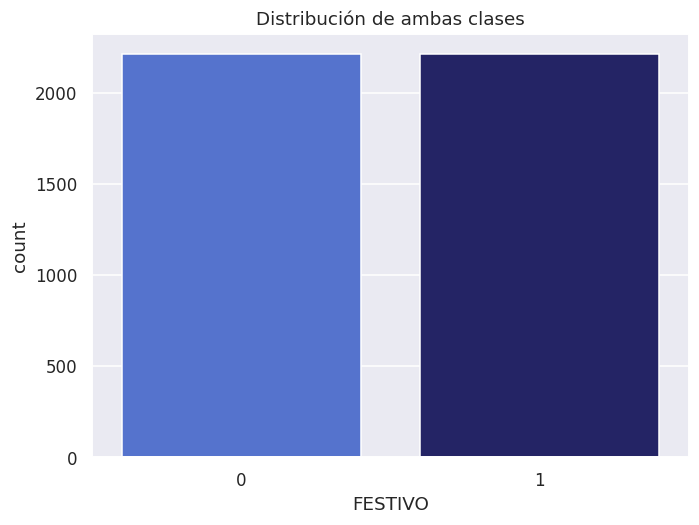

In [46]:
plt.figure(figsize=(7,5), dpi=110)
sns.countplot(x=y_train, palette=['royalblue', 'midnightblue'])
plt.title('Distribución de ambas clases')
plt.show()

Se puede apreciar que ahora se tiene el mismo número de observaciones de ambas clases.

A continuación aplicamos las mismas transformaciones que aplicamos en el Pipeline al dataset de test.

In [47]:
# Get the attributes we're interested in
test_to_pipeline = df_aju_ts.loc[:, attributes]
# Apply the transformations
test_tr = full_pipeline.transform(test_to_pipeline)
test_tr = pd.DataFrame(test_tr, columns=columns, index=df_aju_ts.index)
# Check the result
test_tr.head()

CR00      CR01      CR02      CR03      CR04      CR05      CR06  \
139   0.962051  0.694993  0.835203  0.966244  0.827941  0.936723 -0.232629   
1371  0.486880  0.142927  0.211116  0.230165  0.192324  0.102861 -0.800682   
984   0.494631  0.305878  0.602950  0.480042  0.466479  0.489823 -0.527704   
2660  0.314115  0.411898  0.716906  1.092873  1.042821  1.250062  2.156379   
2437  2.205074  1.781726  2.616072  2.730372  2.745224  2.625796  1.188138   

          CR07      CR08      CR09      CR10      CR11      CR12      CR13  \
139  -1.320206 -1.034886 -0.119785  1.214670  1.796358  1.616485  1.215648   
1371 -0.278844 -0.470154  0.557020  0.965996  1.169250  0.709468  0.225697   
984  -0.809990 -0.875445 -0.254074  0.578744  0.644214  0.450817  0.372039   
2660  1.255250  0.849776  0.230605 -0.126044  0.824117  1.819163  0.807679   
2437 -0.625514 -1.827572 -1.999935 -0.969032  0.560038  1.149231  0.393526   

          CR14      CR15      CR16      CR17      CR18      CR19      CR20  \
139   0.623004  0.101568 -0.986295 -1.015749 -0.764630 -1.037853 -1.625560   
1371 -0.501650 -0.660198 -0.118167 -0.196035 -0.472071  0.102282  0.350450   
984   0.042964  0.010918  0.333211  0.303760 -0.278587 -0.553229  0.082627   
2660  0.703852  0.582676  0.100885 -0.840100 -1.572701 -1.918428 -2.290811   
2437 -0.550654 -1.073934 -1.707760 -2.179907 -1.781437 -1.301160  0.360599   

          CR21      CR22      CR23      TMIN      TMAX  DIASEM_2  DIASEM_3  \
139  -0.766747  0.483242  1.547206  0.300898 -0.423458       0.0       0.0   
1371 -0.592322 -0.621364 -0.188407  1.015767  0.310345       0.0       0.0   
984  -0.901424 -0.061734  0.665596  0.950779  0.582123       0.0       0.0   
2660 -1.365547 -0.549809 -0.066334  0.625838  1.315926       0.0       0.0   
2437 -0.487342 -0.288327  0.181026  0.788308  0.337522       0.0       0.0   

      DIASEM_4  DIASEM_5  DIASEM_6  DIASEM_7  MES_2  MES_3  MES_4  MES_5  \
139        0.0       0.0       1.0       0.0    0.0    0.0    0.0    1.0   
1371       0.0       0.0       1.0       0.0    0.0    0.0    0.0    0.0   
984        0.0       0.0       1.0       0.0    0.0    0.0    0.0    0.0   
2660       0.0       1.0       0.0       0.0    0.0    0.0    0.0    1.0   
2437       0.0       0.0       0.0       1.0    0.0    0.0    0.0    0.0   

      MES_6  MES_7  MES_8  MES_9  MES_10  MES_11  MES_12  
139     0.0    0.0    0.0    0.0     0.0     0.0     0.0  
1371    0.0    0.0    0.0    0.0     1.0     0.0     0.0  
984     0.0    0.0    0.0    1.0     0.0     0.0     0.0  
2660    0.0    0.0    0.0    0.0     0.0     0.0     0.0  
2437    0.0    0.0    0.0    0.0     1.0     0.0     0.0

Tras ello obtenemo $X_{test}$ y $y_{test}$:

In [48]:
X_test = test_tr.copy()
y_test = df_aju_ts[target]

Finalmente, para ver el performance el cada modelo, definimos la siguiente función que nos permite visualizar diferentes métricas de cara a evaluar el performance del modelo, además de reutilizar código:

In [49]:
def metrics_summary(model, X, Y, threshold=0.5):
    predictions_proba = model.predict_proba(X)[:, 1]
    predictions = np.array([1 if i>threshold else 0 for i in predictions_proba])

    cm = metrics.confusion_matrix(Y, predictions)
    print('=========================\nConfusion matrix\n{}'.format(cm))

    cm_relative = np.round(metrics.confusion_matrix(Y, predictions, normalize='true'), 2)
    print('======================================\nConfusion matrix with percentages\n{}'.format(cm_relative))

    accuracy = metrics.accuracy_score(Y, predictions)
    print('=========================\nAccuracy\n{}'.format(accuracy))

    balanced_accuracy = metrics.balanced_accuracy_score(Y, predictions)
    print('=========================\nBalanced accuracy\n{}'.format(balanced_accuracy))

    precision = metrics.precision_score(Y, predictions)
    print('=========================\nPrecision\n{}'.format(precision))

    recall = metrics.recall_score(Y, predictions)
    print('=========================\nRecall\n{}'.format(recall))

    f1 = metrics.f1_score(Y, predictions)
    print('=========================\nF1\n{}'.format(f1))

    roc_auc = metrics.roc_auc_score(Y, predictions_proba)
    print('=========================\nROC_AUC_SCORE\n{}'.format(roc_auc))
    print('=========================')

#### 1.2. Ajusta un modelo de clasificación sencillo que sea robusto y que pueda servir de referencia de comparación con otros modelos más complejos.

- Optimiza la complejidad
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación
- Analiza la lógica que emplea para determinar si es festivo
- Revisa la importancia de las variables

***Nota***: *se ha probado diferentes combinaciones de hiperparámetros hasta obtener un árbol que sea robusto, de forma que pueda ser utilizado como punto de referencia a la hora de compararlo con otros modelos más complejos. No se muestra toda la experimentación realizada en esta sección ya que no es el objetivo de la práctica, y solamente sirve como modelo base.*

En este caso entrenaremos un árbol de decisión simple:

In [50]:
INPUTS_DT = columns

A continuación procedemos a aplicar ***Cross-Validation*** en el árbol para encontrar la mejor combinación de hiperparámetros. Se puede observar que se elige una profundidad pequeña para que el árbol no sufra de overfitting, ya que este es un problema bastante común en este tipo de modelos:

In [51]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

param_DT = {
    'DT__max_depth': [2,3,5],
    'DT__min_impurity_decrease': np.arange(0, 0.1, 0.005),
    'DT__min_samples_split': [75,125],
    'DT__min_samples_leaf': [25,50]
}

pipe_DT = Pipeline(steps=[ ('DT', DecisionTreeClassifier(criterion='gini',
                                                         max_depth=5, # controlamos la profundidad del árbol para que no sufra overfitting
                                                         random_state=2023))])

nFolds = 10
tree_fit = GridSearchCV(
    estimator=pipe_DT, # Structure of the model to use
    param_grid=param_DT, # Defined grid to search in
    n_jobs=-1, # Number of cores to use (parallelize)
    scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
    cv=nFolds # Number of Folds 
    )
                        
tree_fit.fit(X_train[INPUTS_DT], y_train) # Search in grid
print("Decision Tree Trained")

Decision Tree Trained


Ahora vemos la mejor combinación de hiperparámetros obtenida:

In [52]:
tree_fit.best_estimator_['DT'].get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 25,
 'min_samples_split': 75,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 2023,
 'splitter': 'best'}

Podemos comprobar que la mejor combinación de hiperparámetros es:

- `min_impurity_decrease` = 0
- `min_samples_leaf` = 25
- `min_samples_split` = 75

Tras ello obtenemos el CV score para este modelo:

Mostramos la estructura del árbol de decisión, de forma que podamos obtener mejor el proceso de toma de decisiones del modelo:

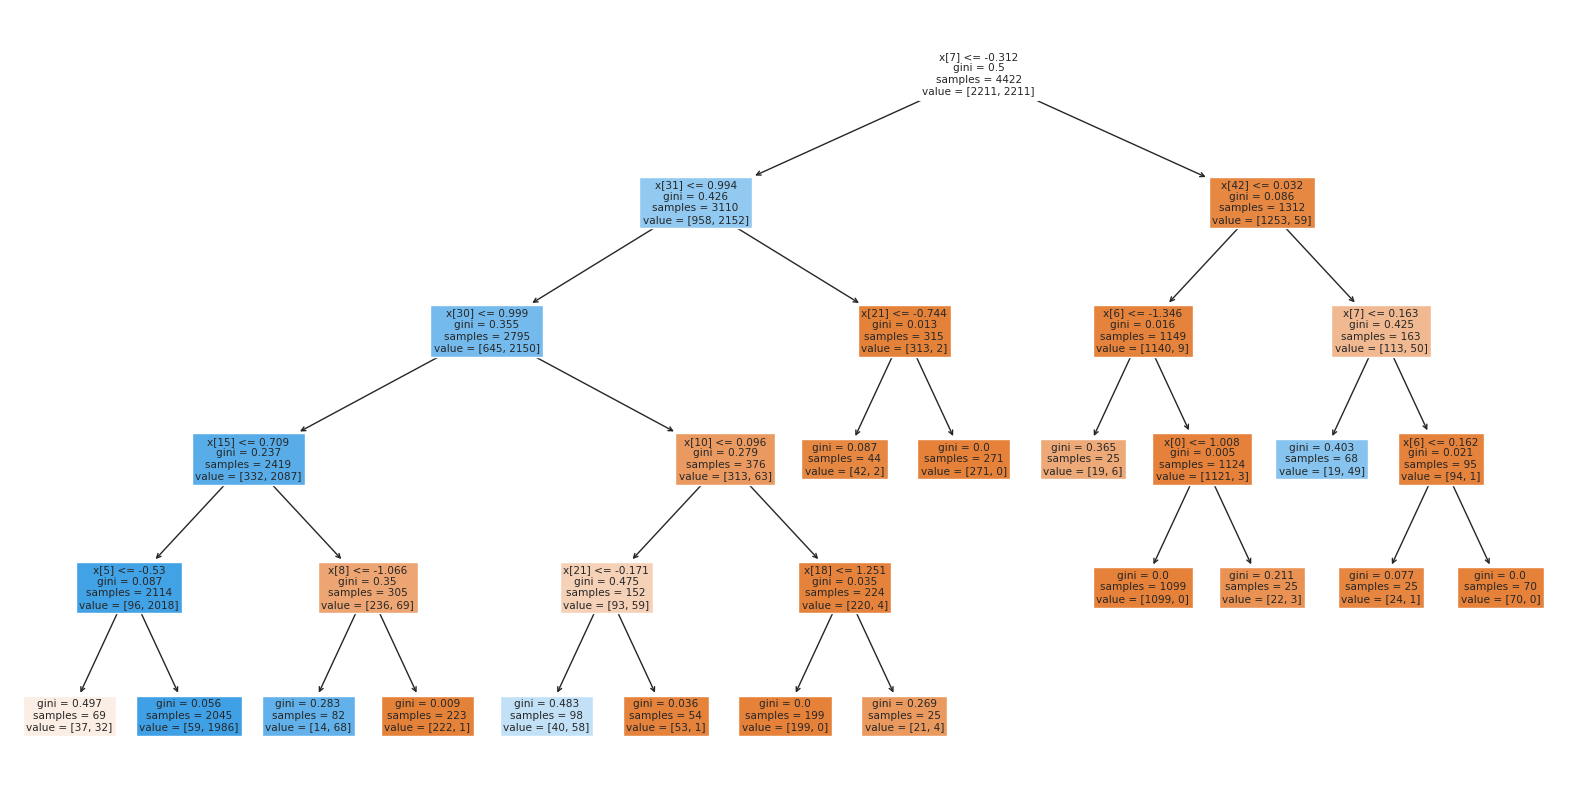

In [53]:
plt.figure(figsize=(20, 10))
plot_tree(tree_fit.best_estimator_['DT'], filled=True)
plt.show()

Se observa que el primer corte que realiza el modelo es para la séptima variable, que corresponde al coeficiente de reparto $CR07$, que como podemos comprobar en la siguiente gráfica, es la variable más importante de todas para el árbol. Tras ello, para los dos siguiente cortes utiliza las variables:

- $\text{DIASEM}7$, es decir, si se trata de un domingo, que resulta ser otra de las variable más importantes para el modelo.
- Si el mes es anterior a Diciembre, que si nos fijamos en la imagen de abajo no tiene una importancia muy alta, pero sí que tiene una importancia mayor a la mayoría de variables, y además vimos en el EDA que en el mes de diciembre suele haber más festivos de los habitual, de forma que era algo que se podía esperar desde un punto de vista lógico.

Adicionalmente mostramos cuales son las variables más importantes para el árbol:

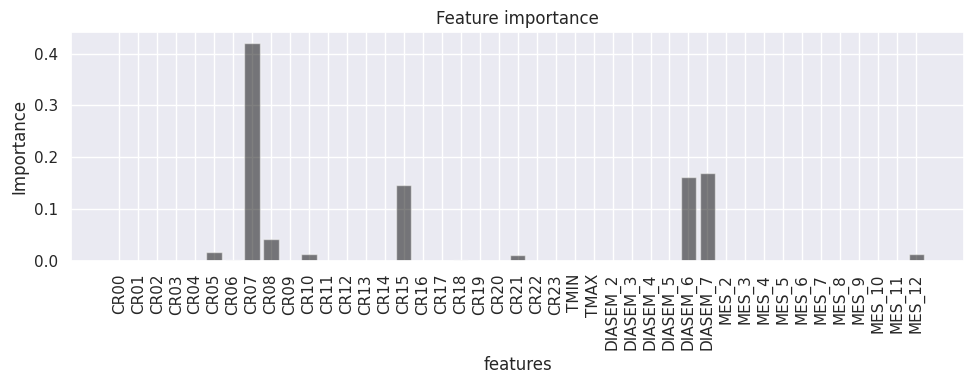

In [54]:
plt.figure(figsize=(10, 4))
index = np.arange(len(X_train[INPUTS_DT].columns))
bar_width = 0.35
plt.bar(index, tree_fit.best_estimator_['DT'].feature_importances_, color='black', alpha=0.5)
plt.xlabel('features')
plt.ylabel('Importance')
plt.title('Feature importance')
plt.xticks(index, X_train[INPUTS_DT].columns, rotation=90)
plt.tight_layout()
plt.show()

Vemos que por orden de importancia las variables más importantes para el modelo son:

1. $CR07$
2. $\text{DIASEM}7$
3. $\text{DIASEM}6$
4. $CR15$
5. $CR08$
6. $\text{MES}7$
7. $\text{MES}12$
8. $CR10$
9. $CR21$
10. $CR11$

Podría saber esperar por ejemplo que $CR07$ fuera una de las variables más importantes, ya que cuando es festivo la gente suele despertarse en promedio más tarde, lo que también conlleva un consumo energético menor en las primeras horas de la mañana.

A continuación vamos a mostrar las métricas obtenidas por el árbol en el dataset de entrenamiento:

In [55]:
metrics_summary(tree_fit, X_train[INPUTS_DT], y_train, 0.5)

Confusion matrix
[[2079  132]
 [  50 2161]]
Confusion matrix with percentages
[[0.94 0.06]
 [0.02 0.98]]
Accuracy
0.9588421528720036
Balanced accuracy
0.9588421528720037
Precision
0.9424334932402966
Recall
0.9773857982813207
F1
0.9595914742451154
ROC_AUC_SCORE
0.9831180023569501


Observamos como el modelo, pese a tratarse de un modelo sencillo, se ha aprendido en principio bastante bien los datos de entrenamiento (vemos que el *balanced accuracy* es igual al *accuracy* dado que hemos balanceado las clases). Adicionalmente, vemos que el Recall* es mayor que el *Precision*, lo cual se debe a la técnica de upsampling aplicada.

Adicionalmente, cabe destacar que el *ROC AUC score* obtenido es bastante elevado.

Mostramos estos resultados gráficamente, para hacernos una mejor idea de los resultados obtenidos por el modelo en el dataset de entrenamiento:

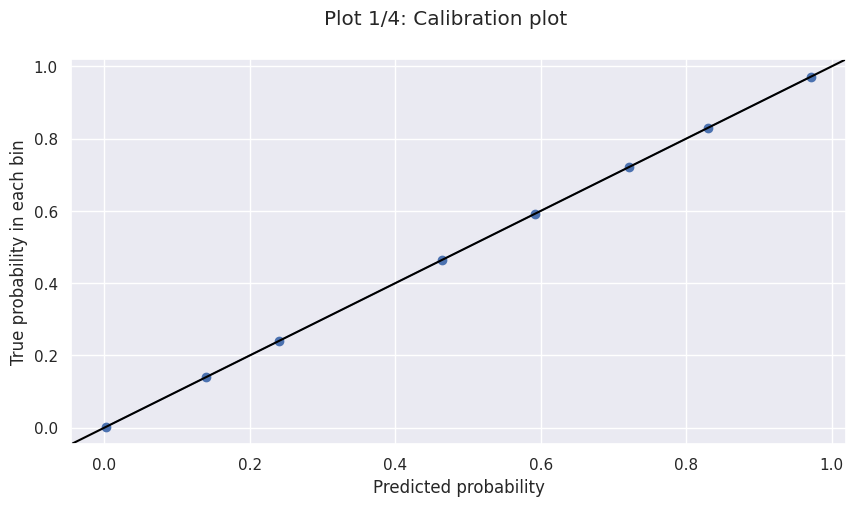

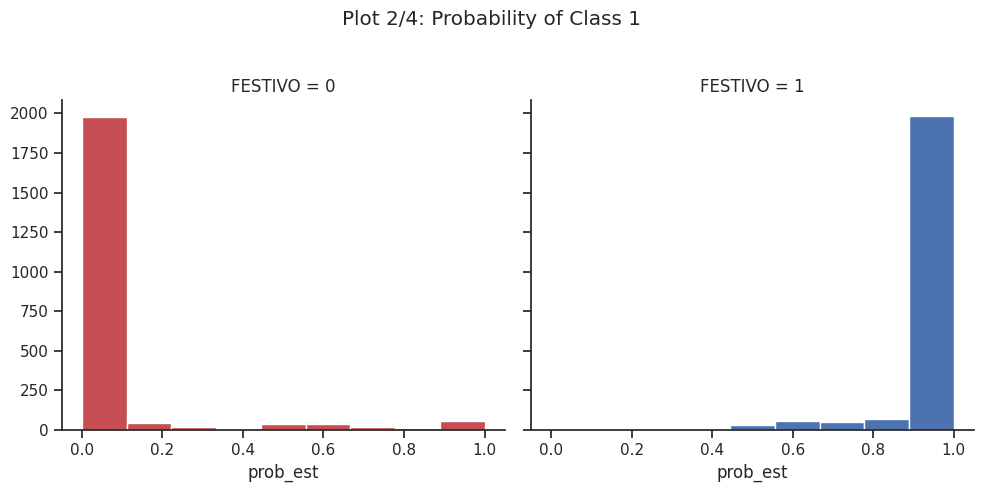

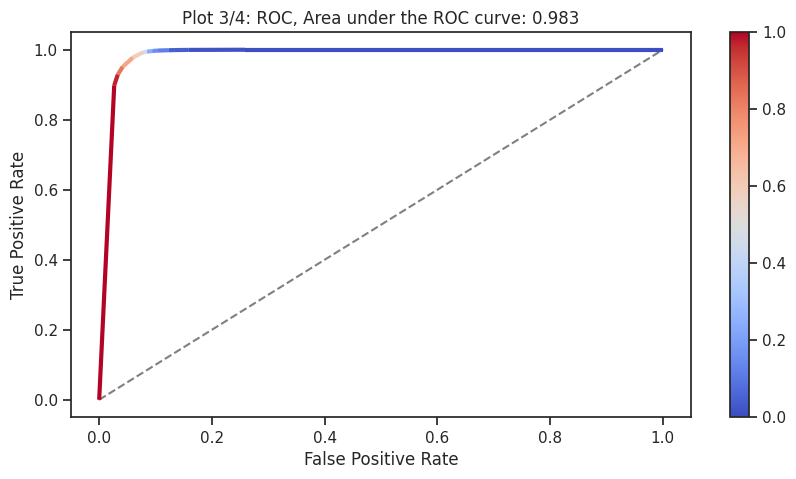

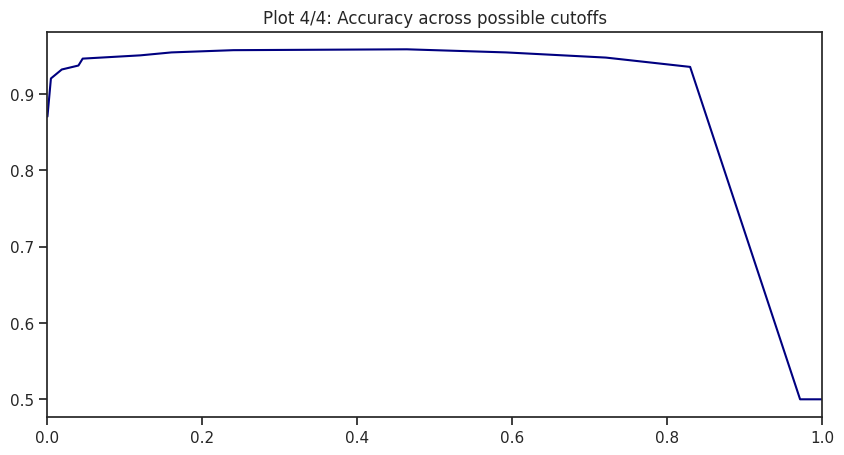

In [56]:
y_train = y_train.astype('category')
CT.plotClassPerformance(y_train, tree_fit.predict_proba(X_train[INPUTS_DT]), selClass = 1)
plt.show()

Dados los resultados obtenidos, pese a que el modelo no se ha expandido mucho (profundidad de 5 niveles), podríamos sospechar que el modelo parece sufrir de *overfitting* (esto es, los resultados en el conjunto de entrenamiento parecen demasiado buenos teniendo en cuenta que el modelo que hemos entrenado es un modelo bastante sencillo en cuanto a complejidad). Esto lo podremos comprobar analizando los resultados del modelo en el dataset de test.

A continuación observamos esas mismas métricas, pero sobre el dataset de test:

In [57]:
metrics_summary(tree_fit, X_test[INPUTS_DT], y_test, 0.5)

Confusion matrix
[[520  33]
 [  3  20]]
Confusion matrix with percentages
[[0.94 0.06]
 [0.13 0.87]]
Accuracy
0.9375
Balanced accuracy
0.9049453573394135
Precision
0.37735849056603776
Recall
0.8695652173913043
F1
0.5263157894736843
ROC_AUC_SCORE
0.972796603506565


Vemos que efectivamente el modelo obtiene resultados significativamente peores sobre el dataset de test. Vemos que el *accuracy* ha caído de $0.968$ a $0.939$, mientras que el *balanced accuracy* ha caído de ese mismo valor a $0.927$. 

Además, vemos una caída especialmente brusca en el *precision*, pasando de $0.94$ a $0.39$. Esto, como se ha explicado anteriormente, es debido a la técnica de upsampling empleada, que tiene como consecuencia un aumento del *recall* (es decir, una disminución de la tasa de falsos negativos) a costa de perjudicar al *precision* (es decir, un aumento de la tasa de falsos positivos), siendo este efecto mayor cuando las clases están más desbalanceadas.

Mostramos los resultados en el dataset de test también gráficamente:

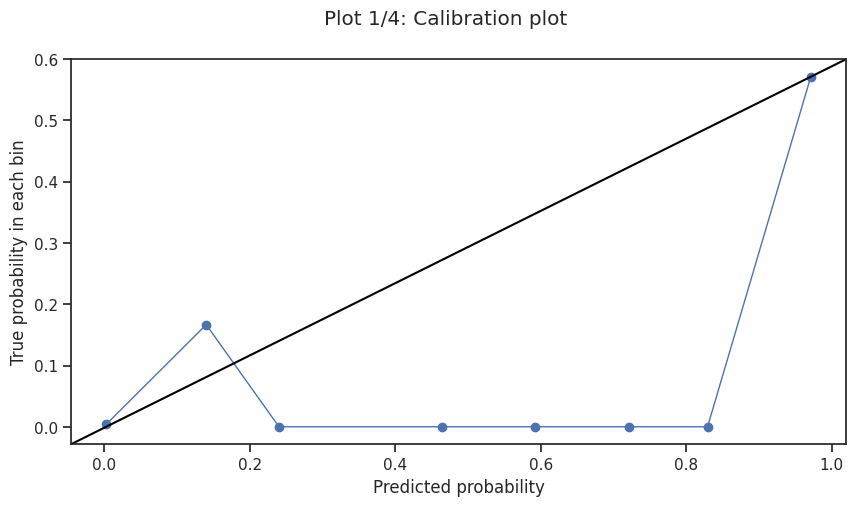

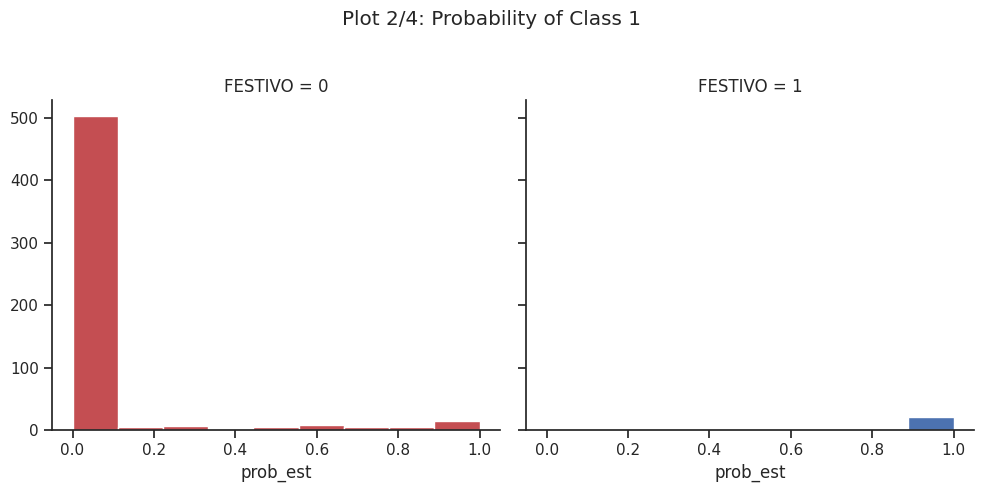

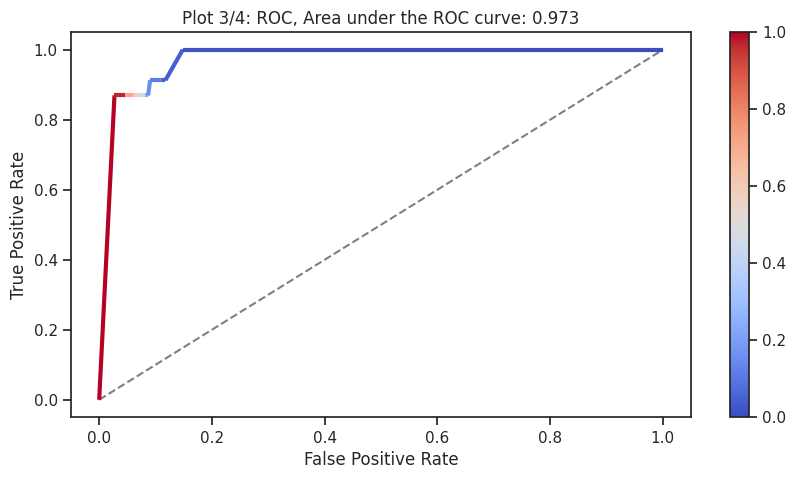

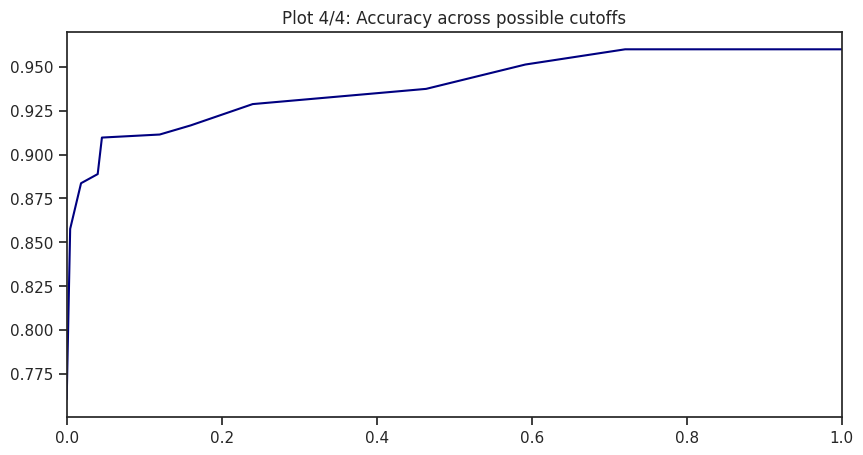

In [58]:
y_test = y_test.astype('category')
CT.plotClassPerformance(y_test, tree_fit.predict_proba(X_test[INPUTS_DT]), selClass = 1)
plt.show()

Comprobamos de forma visual que los nuevos resultados son considerablemente peores en el dataset de test. 

En el segundo plot que el modelo da una probabilidad de muy alta de pertenecer a la clase positiva a observaciones que pertenecen a la clase negativa. En consecuencia, ni modificando el threshold seríamos capaces de aumentar el *precision* de forma significativa.

En consecuencia, podemos afirmar que el árbol de decisión sencillo, pese a servirnos como referencia para los nuevos modelos que se entrenen, no es un modelo suficientemente bueno como para ser utilizado en producción dado que sufre claramente de *overfitting*, produciéndose una pérdida de performance muy significativa cuando es expuesto a datos totalmente nuevos, especialmente en cuanto a falsos positivos se refiere.

#### 1.3. Ajusta un bagged tree para resolver el problema planteado.

- Optimiza la complejidad
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación
- Revisa la importancia de las variables

A la hora de realizar un bagged tree debemos de tener en cuenta no sólo los hiperparámetros del modelo final (como puede ser el número de estimadores empleados), sino también los hiperparámetros del estimador que empleamos.

In [62]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
INPUTS_BT = INPUTS_DT
param_BT = {
    'estimator__min_impurity_decrease': np.arange(0.01, 0.1, 0.005),
    'estimator__min_samples_split': [75, 125],
    'estimator__min_samples_leaf': [25, 50],
    'n_estimators': np.arange(2, 50, 10)
}
                                                           
bag_class_estim = BaggingClassifier(estimator = DecisionTreeClassifier( criterion='gini',
                                                                        random_state=2023 ),
                                    random_state=2023)

nFolds=10
bag_tree_fit=GridSearchCV(
                        estimator=bag_class_estim,
                        param_grid=param_BT,
                        cv=nFolds,
                        scoring='accuracy',
                        n_jobs=-1)
# fit the bagged trees                 
bag_tree_fit.fit(X_train[INPUTS_BT], y_train)

KeyboardInterrupt: 

Con el fin de encontrar las variables más significativas para el bagging classifier podemos utilizar `permutation_importance`. El método se base en cuantificar cómo variaciones aleatorias en una variable impactan se encuentra en cuantificar cómo se ve afectada la performance del modelo, manteniendo el resto de variables sin alterar. Las variables que más afecten al modelo al ser modificadas obtienen un mayor score, lo cual se traduce en una mayor importancia para el modelo. 

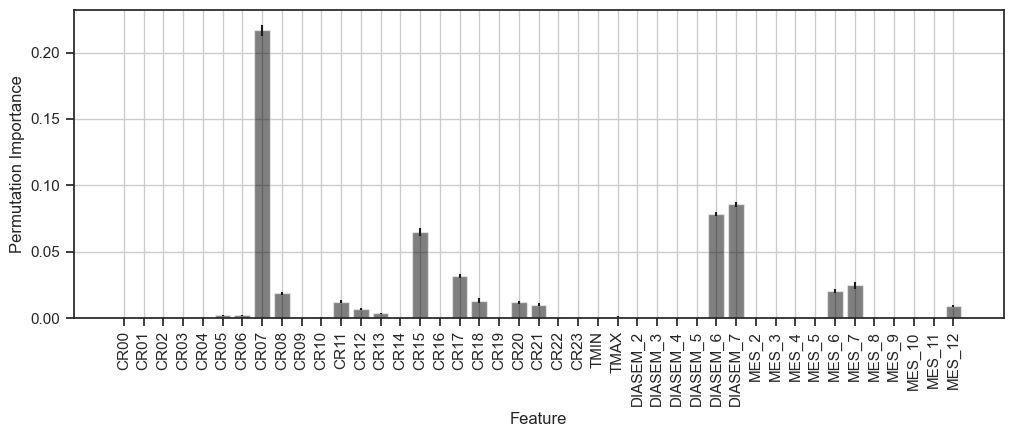

In [ ]:
importances_bag_class_estim = permutation_importance(bag_tree_fit, 
                                    X_train[INPUTS_BT], y_train,
                                    n_repeats=10,
                                    random_state=0)
fig = plt.figure(2, figsize=(12, 4)) 
plt.bar(INPUTS_BT, importances_bag_class_estim.importances_mean, yerr=importances_bag_class_estim.importances_std,color='black', alpha=0.5)
plt.xlabel('Feature')
plt.ylabel('Permutation Importance')
plt.xticks(rotation=90)
plt.grid()
plt.show()

In [ ]:
metrics_summary(bag_tree_fit, X_train[INPUTS_DT], y_train, 0.5)

Confusion matrix
[[2211    0]
 [   0 2211]]
Confusion matrix with percentages
[[1. 0.]
 [0. 1.]]
Accuracy
1.0
Balanced accuracy
1.0
Precision
1.0
Recall
1.0
F1
1.0
ROC_AUC_SCORE
1.0


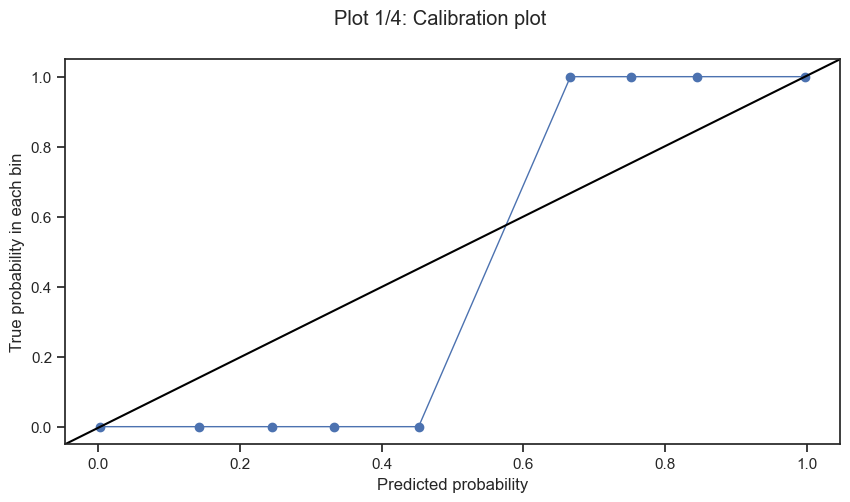

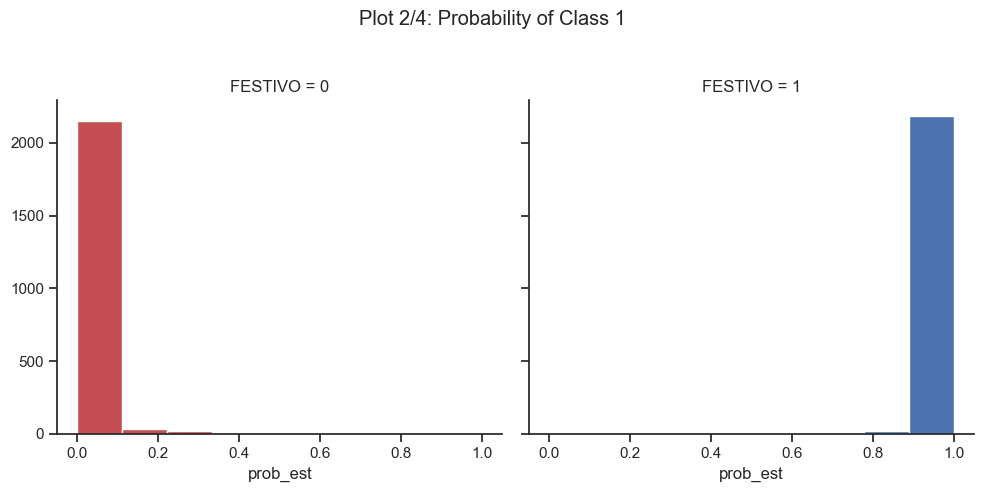

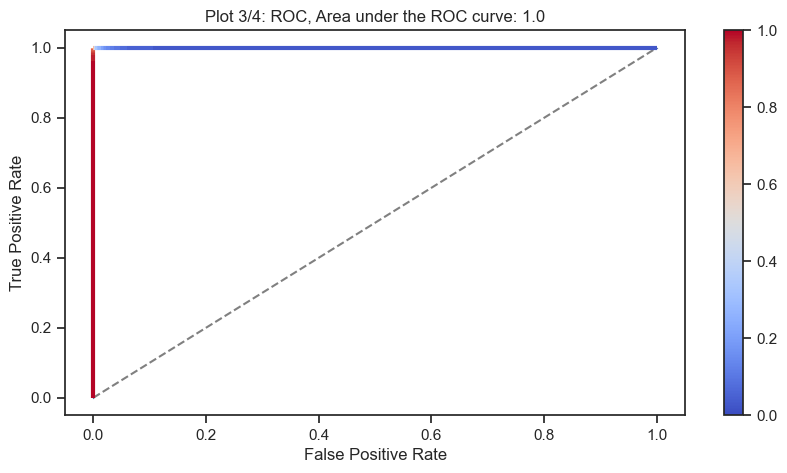

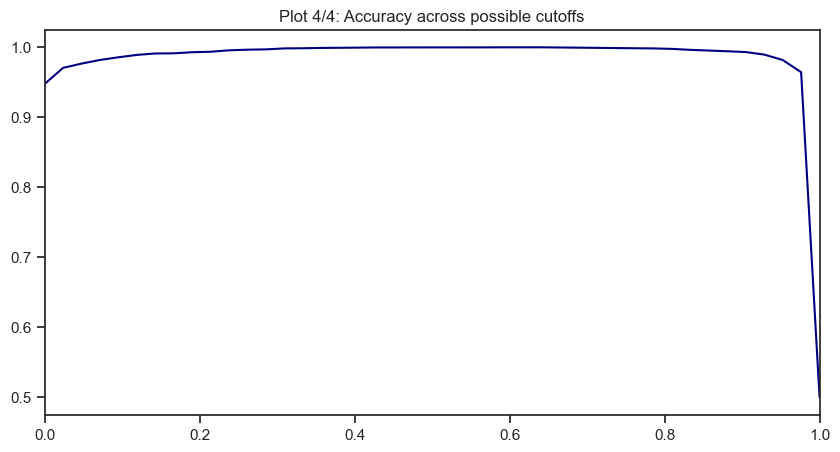

In [ ]:
y_train = y_train.astype('category')
CT.plotClassPerformance(y_train, bag_tree_fit.predict_proba(X_train[INPUTS_BT]), selClass = 1)
plt.show()

In [ ]:
metrics_summary(bag_tree_fit, X_test[INPUTS_DT], y_test, 0.5)

Confusion matrix
[[545   8]
 [  7  16]]
Confusion matrix with percentages
[[0.99 0.01]
 [0.3  0.7 ]]
Accuracy
0.9739583333333334
Balanced accuracy
0.8405928139004639
Precision
0.6666666666666666
Recall
0.6956521739130435
F1
0.6808510638297872
ROC_AUC_SCORE
0.961160468590298


In [ ]:
y_train = y_train.astype('category')
# CT.plotClassPerformance(y_test, bag_tree_fit.predict_proba(X_test[INPUTS_BT]), selClass = 1)
plt.show()

#### 1.4. Ajusta un random forest para resolver el problema planteado.

- Optimiza la complejidad
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación
- Revisa la importancia de las variables

Los modelos de bagging utilizan múltiples modelos de aprendizaje débiles con alta varianza y bajo sesgo para mejorar la generalización a nuevos datos y reducir la varianza. Sin embargo, es importante tener cuidado de no generar un modelo final que sufra de sobreajuste, ya que esto puede llevar a un peor rendimiento en datos nuevos.

En nuestra elección de hiperparámetros seguimos esta filosofía, tratando de crear modelos de aprendizaje débiles con alta varianza para evitar un ajuste excesivo a los datos de entrenamiento y lograr una mejor generalización. Para ello, aumentamos la profundidad de los árboles y el número de árboles y características utilizados en cada árbol, buscando un equilibrio adecuado entre la complejidad y la capacidad de generalización del modelo final

Adicionalmente, utilizaremos una aproximación algo diferente a la optimización de hiperparámetros. Dado que la búsqueda de la complejidad óptima mediante GridSearch es computacionalmente intensiva, queremos explorar la opción de emplear algoritmos basado en una búsqueda guiada, que permitan una exploración eficiente del espacio de soluciones. Esto es especialmente crítico cuando queremos encontrar combinaciones de varios hiperparámetros, donde podemos vernos significativamente limitados si queremos realizar una búsqueda por GridSearch (debido al problema combinatorio que supone). Con modelos simples como Decision Tree esto no suele ser un problema, pero en modelo más complejos como los que utilizaremos a continuación es necesario implementar métodos más avanzados si queremos hacer un tuning detallado de los hiperparámetros

La opción que hemos escogido es la optimización bayesiana. Esta técnica se basa en la construcción de un modelo probabilístico sobre la función a optimimizar. Dicho modelo define una distribución *a posteriori* de la función objetivo a través de un muestreo aleatorio de puntos en el espacio de búsqueda definido. Dichos puntos son evaluados sobre la función objetivo, lo cual permite actualizar el modelo probabilístico y usarlo para predecir cómo se comportará la función objetivo en puntos inexplorados del espacio. De esta forma, podemos dirigir la búsqueda a las zonas donde es más probable que se encuentren los máximos de la función, lo que permite reducir el número de veces que se evalúe la función objetivo, 

El algoritmo se encuentra implementado en la clase `ModelOptimizer`, importada desde el módulo `bayesian_optimizer`. Esta clase utiliza los métodos de la librería `bayes_opt` mediante una implementación que permite una aplicación flexible a cualquier modelo, con independencia de si se emplean hiperparámetros `int` o `float`.

Dentro de la clase definimos una `black_box_function`, que será la función a optimizar. En este caso, puesto que se trata de un problema de clasificación, podemos escoger métricas como el accuracy, el ROC-AUC, cross-val score, etc. En este caso, emplearemos como métrica el `cross_val_score` a la hora de determinar la complejidad óptima del árbol, de manera similar a como lo hace GridSearch. La métrica de scoring empleada dentro de la función de `cross_val_score` será el `accuracy`.

A continuación, se define la función que optimiza el modelo (`optimize_model`). La función incluye:

+ *wrapper* para la función de objetivo anteriormente descrita
+ optimizador bayesiano (`optimizer`)
+ función de adquisición (`utility function`), que se encarga de realizar el muestreo de nuevos puntos dentro del espacio de búsqueda. La razón para el uso de esta función es que la implementación simple del optimizador bayesiano dentro de la librería sugiere combinaciones de parámetros escogidos dentro de un espectro continuo, por lo que parámetros que necesiten ser discretos (como por ejemplo el número de estimadores empleados en Random Forest o Gradient Boosting) no podrían ser optimizados. Es por ello que se utiliza una implementación que permite un mayor control sobre la búsqueda, donde cada uno de los nuevos puntos es sugerido por la `utility_function` y los parámetros definidos como `int` pueden ser transformados manualmente.

Para más información sobre el algoritmo y su implementación, referirse a los siguientes enlaces:

+ https://github.com/fmfn/BayesianOptimization
+ https://towardsdatascience.com/bayesian-optimization-with-python-85c66df711ec
+ https://machinelearningmastery.com/what-is-bayesian-optimization/#:~:text=with%20sample%20code.-,What%20Is%20Bayesian%20Optimization,and%2For%20expensive%20to%20evaluate.

In [65]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
# define basic model structure
INPUTS_RF = INPUTS_DT
model_rf = RandomForestClassifier( criterion='gini', random_state=2023)

# set bounds for parameter search
pbound_rf = {"n_estimators": (100, 160),
             "max_depth": (9, 11),
             "max_features": (6, 10),
             "min_samples_split": (15, 25),
             "min_samples_leaf": (5, 10),
             }

# specify which parameters need to be treated as int
int_params_rf = ["n_estimators", "max_depth", "max_features", "min_samples_split", "min_samples_leaf"]

# initialize optimizer
optimizer = ModelOptimizer(scoring="accuracy")

# optimize model
params_rf = optimizer.optimize_model(pbounds=pbound_rf, X_train_scale=X_train[INPUTS_RF], 
                                      y_train=y_train, model=model_rf, 
                                      int_params=int_params_rf)

# transform hyperparameters to int if needed
hyper_params = { (k):(int(np.round(v, 0)) if k in int_params_rf else round(v, 2)) for k, v in params_rf.items()}

# fit model using hyperparameters
random_forest_fit = model_rf.set_params(**hyper_params)
random_forest_fit.fit(X_train[INPUTS_RF], y_train)

Best result: {'max_depth': 10.0, 'max_features': 6.0, 'min_samples_leaf': 5.0, 'min_samples_split': 15.0, 'n_estimators': 141.0}.


RandomForestClassifier(max_depth=10, max_features=6, min_samples_leaf=5,
                       min_samples_split=15, n_estimators=141,
                       random_state=2023)

In [66]:
random_forest_fit.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 6,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 15,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 141,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 2023,
 'verbose': 0,
 'warm_start': False}

In [ ]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
# INPUTS_RF=INPUTS_DT
# param_RF = { 'RF__n_estimators': np.arange(100, 160, 10),
#              'RF__max_features': np.arange(6, 10, 1), 
#              'RF__max_depth': [9, 11],
#              'RF__min_samples_split': [15, 25], 
#              'RF__min_samples_leaf': [5, 10]
# }

# base_estimator =  Pipeline(steps=[('RF', 
#                                     RandomForestClassifier( criterion='gini',  # impurity measure
#                                                             random_state=2023))]) # For replication
                                                            
# nFolds=5
# random_forest_fit=GridSearchCV(
#     estimator=base_estimator,
#     param_grid=param_RF,
#     cv=nFolds,
#     scoring='accuracy',
#     n_jobs=-1
# )
# # fit the bagged trees                 
# random_forest_fit.fit(X_train[INPUTS_RF], y_train)

# # Get the parameters of the best model
# random_forest_fit.best_estimator_['RF'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 11,
 'max_features': 6,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 15,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 120,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 2023,
 'verbose': 0,
 'warm_start': False}

De manera similar a la aproximación empleada para evaluar el bagging classifier, empleamos la aproximación de permutación de variables para poder evaluar la importancia de las mismas para el modelo.

In [67]:
importances_random_forest = permutation_importance(random_forest_fit,
                                    X_train[INPUTS_RF], y_train,
                                    n_repeats=10,
                                    random_state=0)
fig = plt.figure(2, figsize=(12, 4))
plt.bar(INPUTS_RF, importances_random_forest.importances_mean, yerr=importances_random_forest.importances_std,color='black', alpha=0.5)
plt.xlabel('Feature')
plt.ylabel('Permutation Importance')
plt.xticks(rotation=90)
plt.grid()
plt.show()

KeyboardInterrupt: 

In [68]:
metrics_summary(random_forest_fit, X_train[INPUTS_RF], y_train, 0.5)

Confusion matrix
[[2206    5]
 [   4 2207]]
Confusion matrix with percentages
[[1. 0.]
 [0. 1.]]
Accuracy
0.9979647218453188
Balanced accuracy
0.9979647218453189
Precision
0.9977396021699819
Recall
0.9981908638625057
F1
0.9979651820031652
ROC_AUC_SCORE
0.9999762709416611


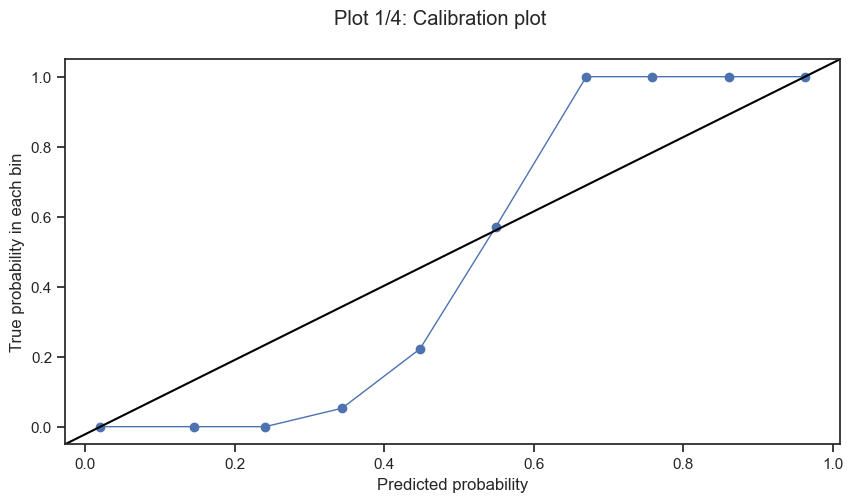

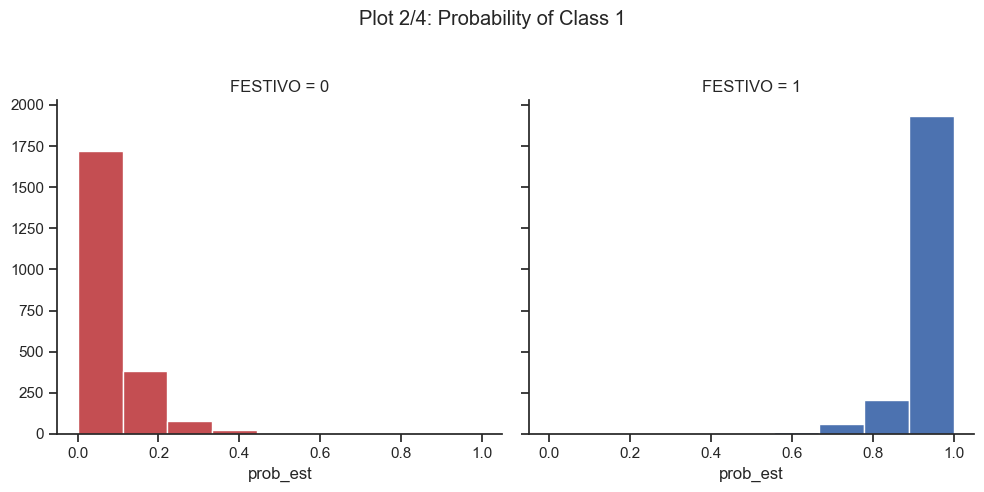

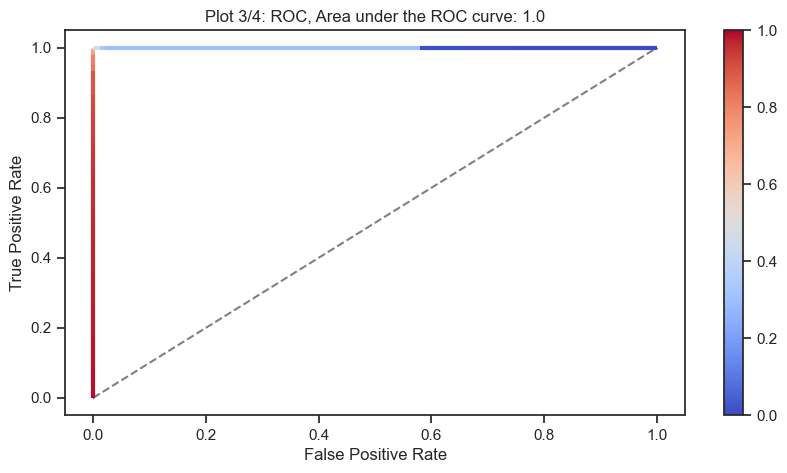

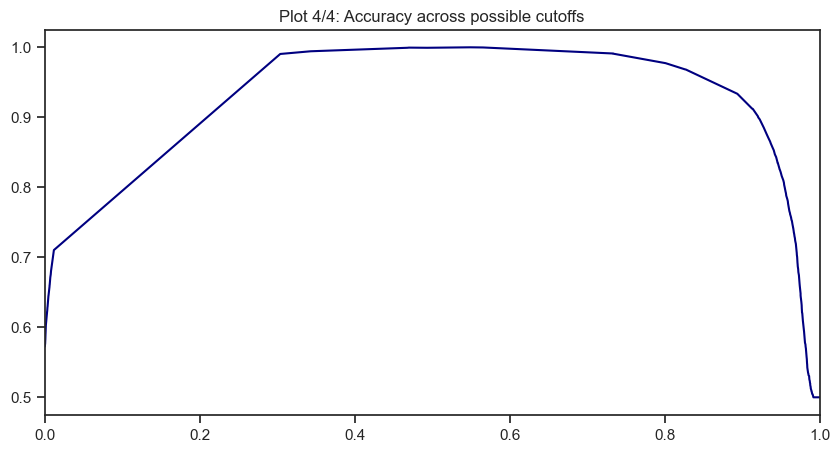

In [ ]:
y_train = y_train.astype('category')
CT.plotClassPerformance(y_train, random_forest_fit.predict_proba(X_train[INPUTS_BT]), selClass = 1)
plt.show()

In [69]:
metrics_summary(random_forest_fit, X_test[INPUTS_RF], y_test, 0.5)

Confusion matrix
[[552   1]
 [  4  19]]
Confusion matrix with percentages
[[1.   0.  ]
 [0.17 0.83]]
Accuracy
0.9913194444444444
Balanced accuracy
0.9121393191288623
Precision
0.95
Recall
0.8260869565217391
F1
0.8837209302325583
ROC_AUC_SCORE
0.9878921298844249


In [70]:
y_test = y_test.astype('category')
CT.plotClassPerformance(y_test, bag_tree_fit.predict_proba(X_test[INPUTS_BT]), selClass = 1)
plt.show()

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

En general, los resultados obtenidos en el conjunto de entrenamiento son sobresalientes, lo que indica que el modelo ha aprendido adecuadamente de los datos de entrenamiento. La precisión, el recall y el F1-score son excepcionalmente altos, todos por encima del 0.99, y la matriz de confusión muestra muy pocos errores de clasificación. Además, el área bajo la curva ROC (ROC_AUC_SCORE) es excelente (de nuevo superior a 0.99), lo que sugiere que el modelo tiene un poder discriminativo muy bueno.

En cuanto al conjunto de prueba, los resultados también son muy buenos, aunque no alcanzan el nivel del conjunto de entrenamiento. La precisión sigue siendo alta (0.95), lo que indica que la mayoría de las predicciones positivas son correctas. Sin embargo, el recall es menor (0.83), lo que sugiere que el modelo no ha detectado algunos casos positivos. El F1-score de 0.88 indica que el modelo tiene un equilibrio adecuado entre la precisión y el recall. Además, el área bajo la curva ROC es alta (0.99), lo que indica que el modelo también presenta un gran poder discriminativo en el conjunto de prueba.

En resumen, los resultados sugieren que el modelo es muy efectivo en la clasificación de datos de entrenamiento y generaliza correctamente en datos nuevos. Aunque todavía hay margen de mejora en la clasificación de algunos casos positivos en el conjunto de prueba, en general el modelo se desempeña de manera satisfactoria en ambos conjuntos de datos. 

#### 1.5. Ajusta un gradient boosting para resolver el problema planteado.

- Optimiza la complejidad
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación
- Revisa la importancia de las variables

Con el fin de ampliar el rango de modelos empleados para resolver el problema proponemos la implementación de dos técnicas diferentes basadas en boosting:

+ En primer lugar, emplearemos el paquete `lightgbm`, con una implementación ligera del algoritmo de gradient boosting que presenta ventajas en cuanto a la optimización del uso de memoria y velocidad de computación

+ En segundo lugar, emplearemos adicionalmente el paquete `xgboost`, que a pesar de ser algo más lento se encuentra entre los paquetes más populares para implementar la técnica de Gradient Boosting.

De manera similar a lo realizado para Random Forest, emplearemos el método de optimización bayesiana para el ajuste de hiperparámetros. Además, incluimos en la parte de LGBM una comparación entre la optimización bayesiana y el empleo de GridSearch, con el fin de comprobar si ambos métodos llegan a soluciones similares. 

##### LGBM

In [ ]:
# define basic model structure
model_lgbm = lgb.LGBMClassifier(objective="binary",
                                random_state=2022)

# set bounds for parameter search
pbounds_lgbm = {"n_estimators": (100, 200),
                "learning_rate": (0.01, 0.1),
                "max_depth": (1, 3)}

# specify which parameters need to be treated as int
int_params_lgbm = ["n_estimators", "max_depth"]

# initialize optimizer
optimizer = ModelOptimizer(scoring="accuracy")

# optimize model
params_lgbm = optimizer.optimize_model(pbounds=pbounds_lgbm, X_train_scale=X_train, 
                                      y_train=y_train, model=model_lgbm, 
                                      int_params=int_params_lgbm)

# transform hyperparameters to int if needed
hyper_params = { (k):(int(np.round(v, 0)) if k in int_params_lgbm else round(v, 2)) for k, v in params_lgbm.items()}

# fit model using hyperparameters
lgbm_fit = model_lgbm.set_params(**hyper_params)
lgbm_fit.fit(X_train, y_train)

Best result: {'learning_rate': 0.1, 'max_depth': 3.0, 'n_estimators': 97.0}.


LGBMClassifier(max_depth=3, n_estimators=97, objective='binary',
               random_state=2022)

In [ ]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
# check model

lgbm_fit.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 97,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': 'binary',
 'random_state': 2022,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

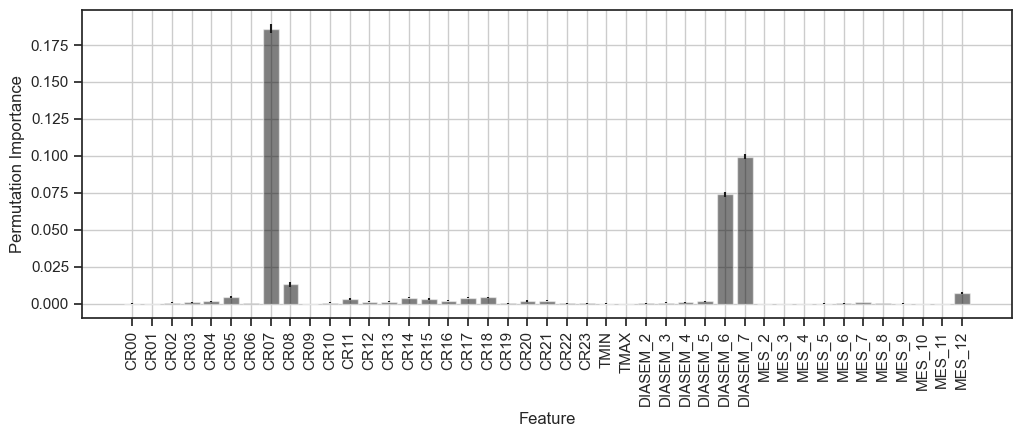

In [ ]:
importance_lgbm = permutation_importance(lgbm, X_train, y_train, n_repeats=10, random_state=0)
fig = plt.figure(2, figsize=(12, 4)) 
plt.bar(INPUTS_BT, importance_lgbm.importances_mean, yerr=importance_lgbm.importances_std,color='black', alpha=0.5)
plt.xlabel('Feature')
plt.ylabel('Permutation Importance')
plt.xticks(rotation=90)
plt.grid()
plt.show()

Podemos comprobar que la importancia de las variables empleadas es similar a lo que observamos con los algoritmos anteriores, sindo el coeficiente de reparto $CR07$ y los días de la semana $Sábado$ y $Domingo$ las variables más importantes. 

In [ ]:
metrics_summary(lgbm_fit, X_train, y_train, 0.5)

Confusion matrix
[[2204    7]
 [   9 2202]]
Confusion matrix with percentages
[[1. 0.]
 [0. 1.]]
Accuracy
0.9963817277250113
Balanced accuracy
0.9963817277250113
Precision
0.996831145314622
Recall
0.9959294436906377
F1
0.9963800904977376
ROC_AUC_SCORE
0.9999079476185129


Podemos observar que la performance del modelo en el dataset de training es casi perfecta. Sin embargo, esto no garantiza los mismos resultados en el dataset de testing, y de hecho es posible que nos estemos enfrentando a un problema de overfitting.

In [ ]:
y_train = y_train.astype('category')
# CT.plotClassPerformance(y_train, bag_tree_fit.predict_proba(X_train[INPUTS_BT]), selClass = 1)
plt.show()

In [ ]:
metrics_summary(lgbm_fit, X_test, y_test, 0.5)

Confusion matrix
[[548   5]
 [  4  19]]
Confusion matrix with percentages
[[0.99 0.01]
 [0.17 0.83]]
Accuracy
0.984375
Balanced accuracy
0.9085226826008335
Precision
0.7916666666666666
Recall
0.8260869565217391
F1
0.8085106382978724
ROC_AUC_SCORE
0.9784574258982625


Podemos realizar una comparación del modelo obtenido mediante el método de optimización bayesiana modelo obtenido por GridSearch:

In [ ]:
params_lgbm_search = {
    'lgbm__n_estimators': np.arange(100, 150, 5),
    'lgbm__learning_rate': np.arange(0.01, 0.1, 0.005),
    'lgbm__max_depth': np.arange(1, 3, 1)
}

pipe_lgbm = Pipeline(steps=[('lgbm', lgb.LGBMClassifier(objective="binary", random_state=2022))])

nFolds = 10
lgbm_search = GridSearchCV(
    estimator=pipe_lgbm, # Structure of the model to use
    param_grid=params_lgbm_search, # Defined grid to search in
    n_jobs=-1, # Number of cores to use (parallelize)
    scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
    cv=nFolds
    ) # Number of Folds 
                        
lgbm_search.fit(X_train, y_train) # Search in grid
print("LGBM Search Trained")

LGBM Search Trained


In [ ]:
lgbm_search.best_estimator_['lgbm'].get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.08999999999999998,
 'max_depth': 2,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 95,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': 'binary',
 'random_state': 2022,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

Podemos ver que los parámetros obtenidos son bastante similares:

+ n_estimators: 97 vs 95
+ learning_rate: 0.1 vs 0.09
+ max_depth: 3 vs 2

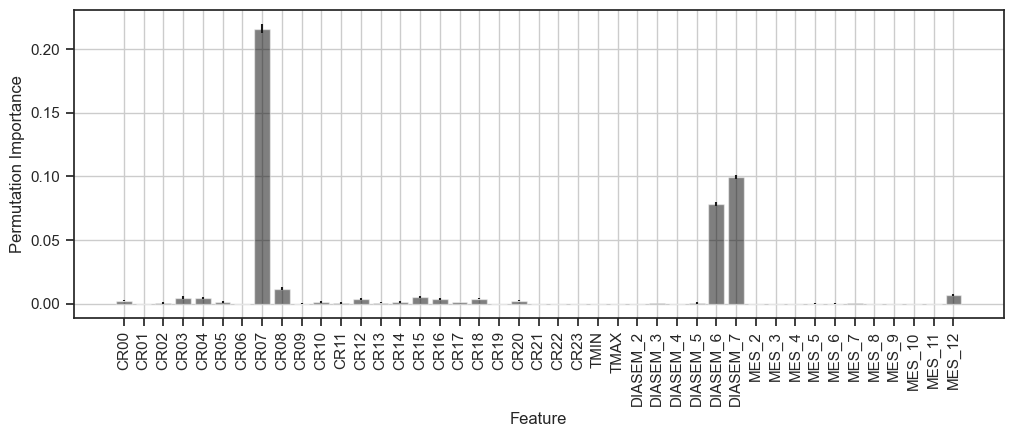

In [ ]:
importance_lgbm_search = permutation_importance(lgbm_search.best_estimator_['lgbm'], X_train, y_train, n_repeats=10, random_state=0)
fig = plt.figure(2, figsize=(12, 4)) 
plt.bar(INPUTS_BT, importance_lgbm_search.importances_mean, yerr=importance_lgbm_search.importances_std,color='black', alpha=0.5)
plt.xlabel('Feature')
plt.ylabel('Permutation Importance')
plt.xticks(rotation=90)
plt.grid()
plt.show()

Del mismo modo, el perfil general de importance de las variables parece similar

In [ ]:
metrics_summary(lgbm_search, X_train, y_train, 0.5)

Confusion matrix
[[2204    7]
 [   9 2202]]
Confusion matrix with percentages
[[1. 0.]
 [0. 1.]]
Accuracy
0.9963817277250113
Balanced accuracy
0.9963817277250113
Precision
0.996831145314622
Recall
0.9959294436906377
F1
0.9963800904977376
ROC_AUC_SCORE
0.9999079476185129


In [ ]:
metrics_summary(lgbm_search, X_test, y_test, 0.5)

Confusion matrix
[[548   5]
 [  4  19]]
Confusion matrix with percentages
[[0.99 0.01]
 [0.17 0.83]]
Accuracy
0.984375
Balanced accuracy
0.9085226826008335
Precision
0.7916666666666666
Recall
0.8260869565217391
F1
0.8085106382978724
ROC_AUC_SCORE
0.9784574258982625


Finalmente, observamos que el desempeño del modelo en los conjuntos de train y test es muy parecido. Con este experimento hemos podido comprobar que el método de optimización bayesiana es una buena alternativa a GridSearch a la hora de escoger la complejidad del modelo, que además permite iteraciones mucho más rápidas y ligeras y amplia significativamente el rango de hiperparámetros que podemos optimizar.

#### 1.5.2 Ajusta un Extreme gradient boosting para resolver el problema planteado.

- Optimiza la complejidad
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación
- Revisa la importancia de las variables

A continuación procedemos a entrenar un modelo XGBoost, empleando optimización bayesiana para la búsqueda de los hiperparámetros óptimos.

In [ ]:
# define basic model structure
INPUTS_XGB = INPUTS_DT
model_xgb = XGBClassifier(objective='binary:logistic', 
                          random_state=2022)

# set bounds for parameter search
pbounds_xgb =  {"n_estimators": (100, 200),
                "learning_rate": (0.01, 0.1),
                "max_depth": (1, 3),
                "subsample": (0.1, 0.8),
                "gamma": (0, 1),
                "reg_alpha": (0, 1),
                "reg_lambda": (0, 1),
                "colsample_bytree": (0, 1)
                }

# specify which parameters need to be treated as int
int_params_xgb = ["n_estimators", "max_depth"]

# initialize optimizer
optimizer = ModelOptimizer(scoring="accuracy")

# optimize model
params_xgb = optimizer.optimize_model(pbounds=pbounds_xgb, X_train_scale=X_train[INPUTS_XGB], 
                                      y_train=y_train, model=model_xgb, 
                                      int_params=int_params_xgb)

# transform hyperparameters to int if needed
hyper_params = { (k):(int(np.round(v, 0)) if k in int_params_xgb else round(v, 2)) for k, v in params_xgb.items()}

# fit model using hyperparameters
XGB_fit = model_xgb.set_params(**hyper_params)
XGB_fit.fit(X_train[INPUTS_XGB], y_train)

In [1]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
# param_XGB = {
#     'XGB__n_estimators': np.arange(10, 200, 50),
#     'XGB__max_depth': np.arange(1, 3, 1),
#     'XGB__min_samples_split': np.arange(2, 10, 2),
#     'XGB__min_samples_leaf': np.arange(1, 5, 1),
#     'XGB__objective': ['binary:logistic'],
#     'XGB__learning_rate': np.arange(0.01, 0.1, 0.005),
#     'XGB__subsample': np.arange(0.1, 1, 0.3),
#     'XGB__colsample_bytree': np.arange(0.1, 1, 0.1),
#     'XGB__gamma': np.arange(0, 1, 0.1),
#     'XGB__reg_alpha': np.arange(0, 1, 0.1),
#     'XGB__reg_lambda': np.arange(0, 1, 0.1)
# }

# pipe_XGB = Pipeline(steps=[ ('XGB', XGBClassifier(random_state=2023)) ])

# #random grid search
# XGB_fit = RandomizedSearchCV(
#     estimator=pipe_XGB, # Structure of the model to use
#     param_distributions=param_XGB, # Defined grid to search in
#     n_iter=50, # Number of iterations
#     n_jobs=-1, # Number of cores to use (parallelize)
#     scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
#     cv=10,
#     verbose=1
#     ) # Number of Folds
                        
# XGB_fit.fit(X_train[INPUTS_DT], y_train) # Search in grid
# print("XGBoost Trained")



XGBoost Trained


In [ ]:
metrics_summary(XGB_fit, X_test[INPUTS_DT], y_test, 0.5)

Confusion matrix
[[549   4]
 [  4  19]]
Confusion matrix with percentages
[[0.99 0.01]
 [0.17 0.83]]
Accuracy
0.9861111111111112
Balanced accuracy
0.9094268417328406
Precision
0.8260869565217391
Recall
0.8260869565217391
F1
0.8260869565217391
ROC_AUC_SCORE
0.9780643132321724


In [ ]:
#best parameters
print(XGB_fit.best_params_)
metrics_summary(XGB_fit, X_train[INPUTS_DT], y_train, 0.5)


{'XGB__n_estimators': 110, 'XGB__min_samples_split': 6, 'XGB__min_samples_leaf': 2, 'XGB__max_depth': 2, 'XGB__learning_rate': 0.05999999999999999}
Confusion matrix
[[2151   60]
 [  34 2177]]
Confusion matrix with percentages
[[0.97 0.03]
 [0.02 0.98]]
Accuracy
0.9787426503844414
Balanced accuracy
0.9787426503844414
Precision
0.9731783638801967
Recall
0.984622342831298
F1
0.9788669064748201
ROC_AUC_SCORE
0.9983924585779625


In [ ]:
metrics_summary(XGB_fit, X_test[INPUTS_DT], y_test, 0.5)

Confusion matrix
[[533  20]
 [  2  21]]
Confusion matrix with percentages
[[0.96 0.04]
 [0.09 0.91]]
Accuracy
0.9618055555555556
Balanced accuracy
0.9384385564902901
Precision
0.5121951219512195
Recall
0.9130434782608695
F1
0.6562499999999999
ROC_AUC_SCORE
0.9795581413633148


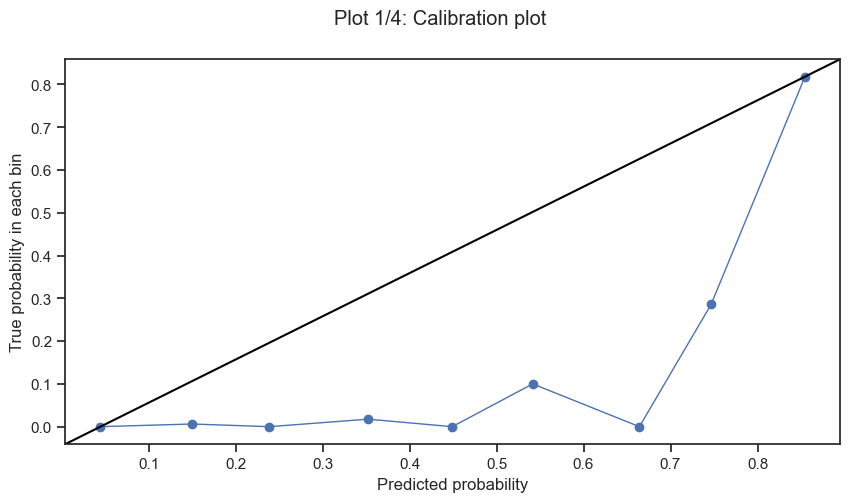

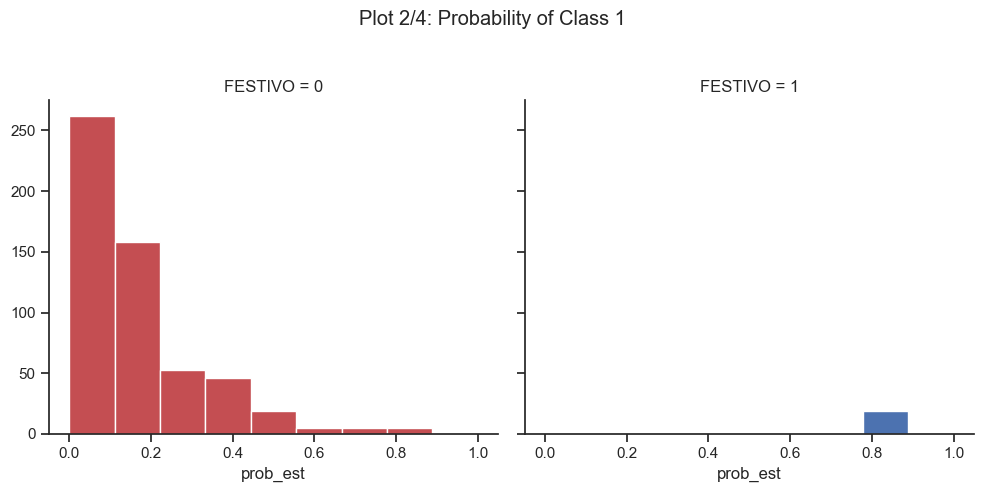

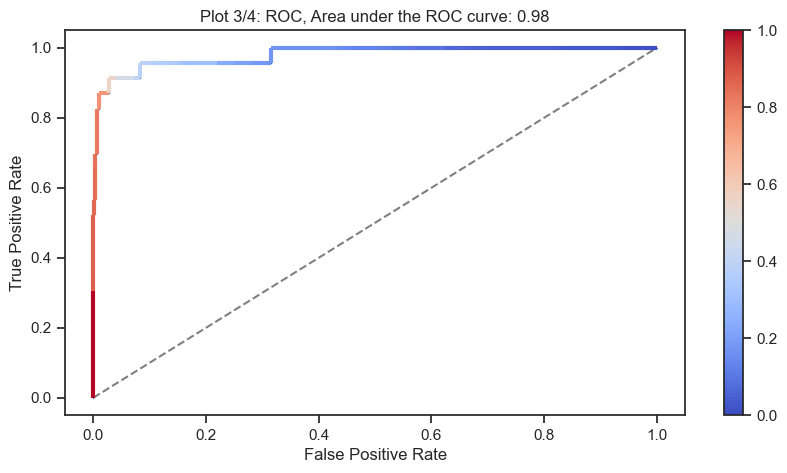

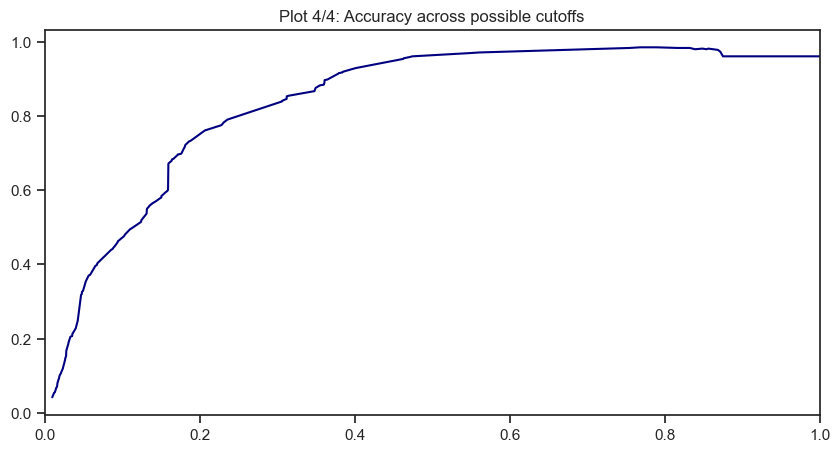

In [ ]:
y_train = y_train.astype('category')
CT.plotClassPerformance(y_test, XGB_fit.predict_proba(X_test[INPUTS_BT]), selClass = 1)
plt.show()

In [ ]:
#lets make a fuction with all this code
#the function will save the N worst predictions of each class in a dataframe
#the it will plot the waterfall of each of them if plot = True
def worst_predictions(model, X_test, y_test, N, plot = False):
    df_results = pd.DataFrame({'Real': y_test, 'Predicted': model.predict(X_test[INPUTS_DT]), 'Prob': model.predict_proba(X_test[INPUTS_DT])[:,1]})
    #lets keep the 5 worts of each class
    classes = df_results['Real'].unique()
    #lets keep the ones the model could not predict properly
    df_results = df_results[df_results['Real'] != df_results['Predicted']]
    #lets keep the 5 worst of each class
    worst_predictions_class_0 = df_results[df_results['Real'] == classes[0]].sort_values(by='Prob', ascending=False).head(N)
    worst_predictions_class_1 = df_results[df_results['Real'] == classes[1]].sort_values(by='Prob', ascending=False).head(N)
    #lets concatenate them
    worst_predictions = pd.concat([worst_predictions_class_0, worst_predictions_class_1])
    print('The worst predictions are:')
    print(worst_predictions)
    if plot == True:
        #make a new test set and make a new index saving the old one in a column
        df_test_shap = X_test[INPUTS_DT].copy()
        df_test_shap['old_index'] = df_test_shap.index
        df_test_shap = df_test_shap.reset_index(drop=True)
        #keep only the old_index
        df_test_shap = df_test_shap[['old_index']]
        #make the shap.plots._waterfall.waterfall_legacy for the worst predictions
        explainer = shap.TreeExplainer(model.best_estimator_['XGB'])
        shap_values = explainer.shap_values(X_test[INPUTS_DT])
        #lets do this for all the worst predictions
        for old_index in worst_predictions.index:
            new_index = df_test_shap[df_test_shap['old_index'] == old_index].index[0]
            shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[new_index], X_test[INPUTS_DT].iloc[new_index], max_display=5)
            #force plot 



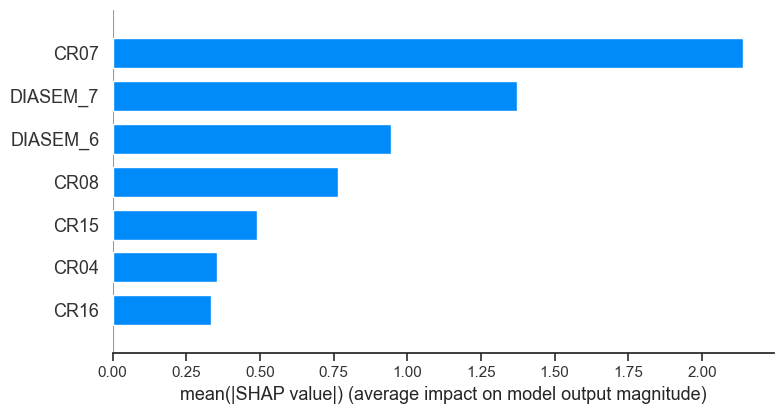

In [ ]:
#plot the xgboost shap importance
# explainer = shap.TreeExplainer(XGB_fit.best_estimator_['XGB'])
explainer = shap.TreeExplainer(XGB_fit)
shap_values = explainer.shap_values(X_test[INPUTS_DT])
shap.summary_plot(shap_values, X_test[INPUTS_DT], plot_type="bar", max_display=7)

The worst predictions are:
     Real  Predicted      Prob
2256    0          1  0.856447
2289    0          1  0.848793
504     1          0  0.384293
192     1          0  0.173219


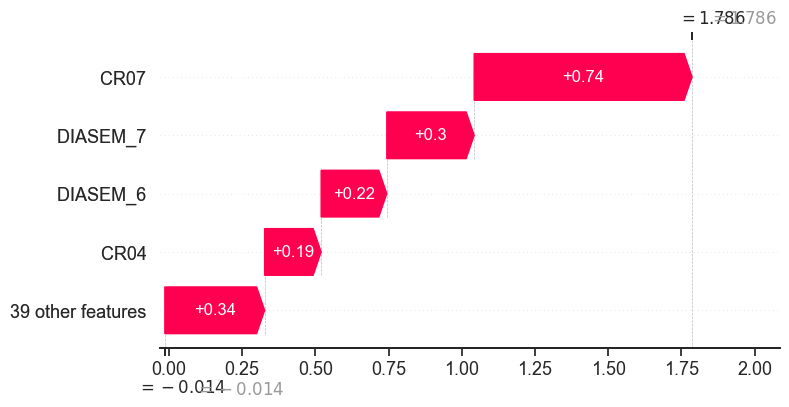

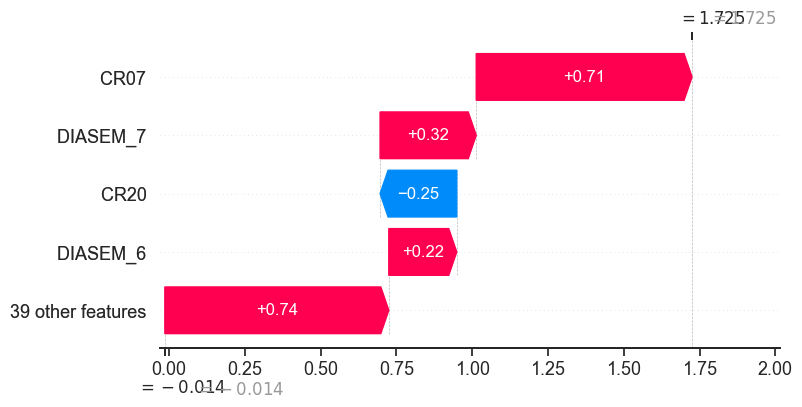

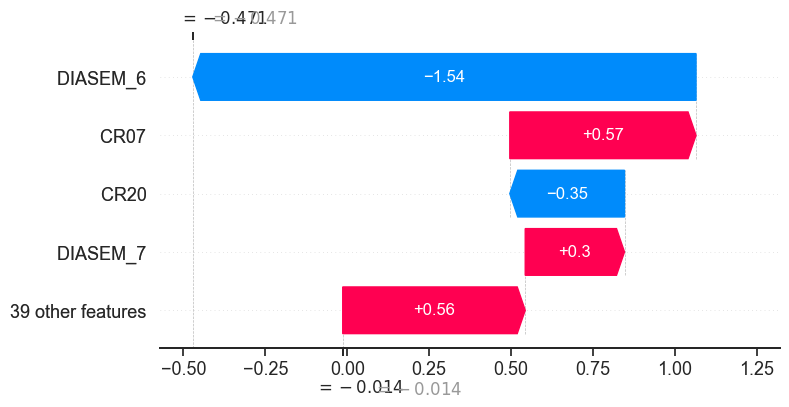

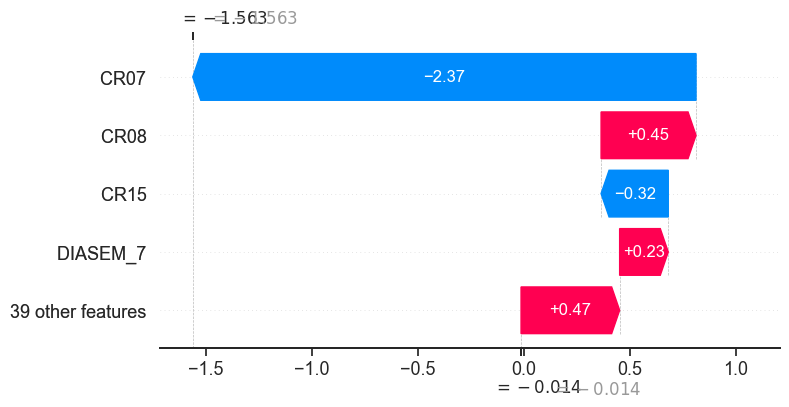

In [ ]:
worst_predictions(XGB_fit, X_test, y_test, 2, plot = True)

#### 1.6. Utiliza stacking con tus mejores tres modelos para intentar mejorar la soluciones obtenidas.
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación

Con el fin de combinar las capacidades de los modelos y conseguir reducir el error de generalización, podemos realizar un modelo de stacking. En primer lugar, es necesaario definir los modelos a utilizar dentro del stacking. En este caso, escogeremos los mejores candidatos dentro de los modelos entrenados: Random Forest y Gradient Boosting. Por el momento, no añadiremos pesos a los modelos. Dado que ya hemos hecho un proceso de entrenamiento de los modelos y únicamente queremos encontrar la forma óptima de combinarlos, emplearemos el parámetro `cv = "prefit"` al instanciar la clase `StackingClassifier`. 

In [ ]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
estimators = [
    ('RF', random_forest_fit.best_estimator_['RF']),
    ('LGBM', lgbm_fit),
    ('XGB', XGB_fit)
]

stacked_classification = StackingClassifier(estimators = estimators, cv = "prefit")
stacked_classification_fit = stacked_classification.fit(X_train, y_train)
stacked_classification_fit.get_params()

In [ ]:
metrics_summary(stacked_classification_fit, X_train[INPUTS_DT], y_train, 0.5)

In [ ]:
metrics_summary(stacked_classification_fit, X_test[INPUTS_DT], y_test, 0.5)

In [ ]:
CT.plotClassPerformance(y_train, stacked_classification_fit.predict_proba(X_train[INPUTS_BT]), selClass = 1)
plt.show()

In [ ]:
CT.plotClassPerformance(y_test, stacked_classification_fit.predict_proba(X_test[INPUTS_BT]), selClass = 1)
plt.show()

#### 1.7. Crea un número de variables reducido que contengan la información recogida en las variables CR00 a CR23 y crea un árbol sencillo basado en estas variables.
- El conjunto de variables creado tienen que ser una combinación lineal de CR00, ..., CR23
- Optimiza la complejidad del árbol
- Revisa los errores en TR y TS, la matrices de confusión, y verifica la capacidad de generación
- Analiza la lógica que emplea para determinar si es festivo
- Revisa la importancia de las variables, explicando el significado físico de las variables más importantes
- Compara los errores en TR y TS y la lógica del modelo con el creado anteriormente en el apartado 1.2.


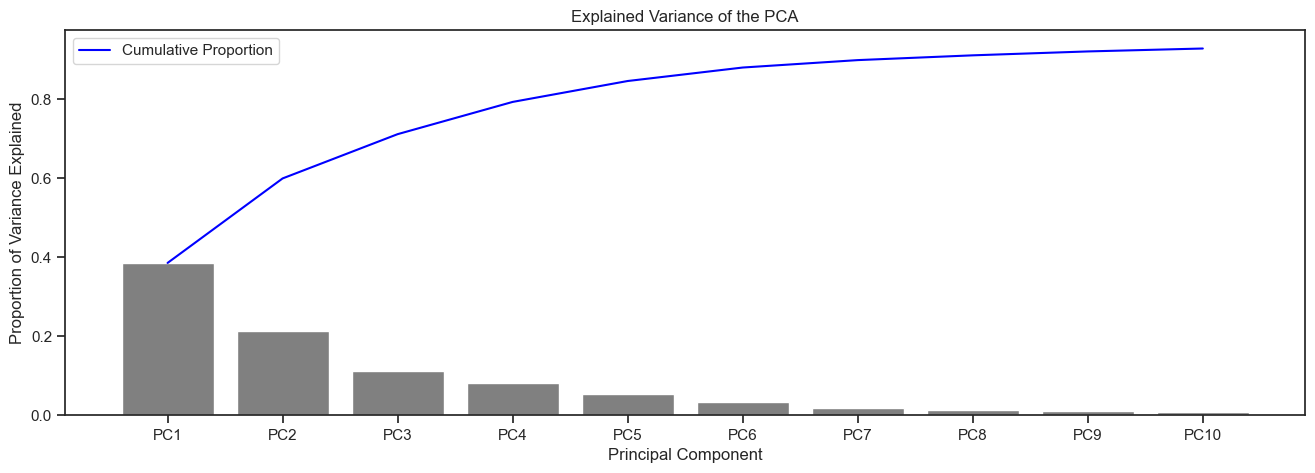

Number of components that explain 90% of the variance: 8
Number of components that explain 80% of the variance: 5


In [ ]:
# Get the PCA model and the PCA transformed data
pca, _ = fit_pca(X_train, n_components=10)

# Get the explained variance of the PCA
exp_variance = get_explained_variance(pca)
exp_variance.head()

# Get the number of components that explain 90% of the variance
n_components = get_n_components(exp_variance, 0.9)
print(f'Number of components that explain 90% of the variance: {n_components}')
# Get the number of components that explain 80% of the variance
n_components = get_n_components(exp_variance, 0.8)
print(f'Number of components that explain 80% of the variance: {n_components}')

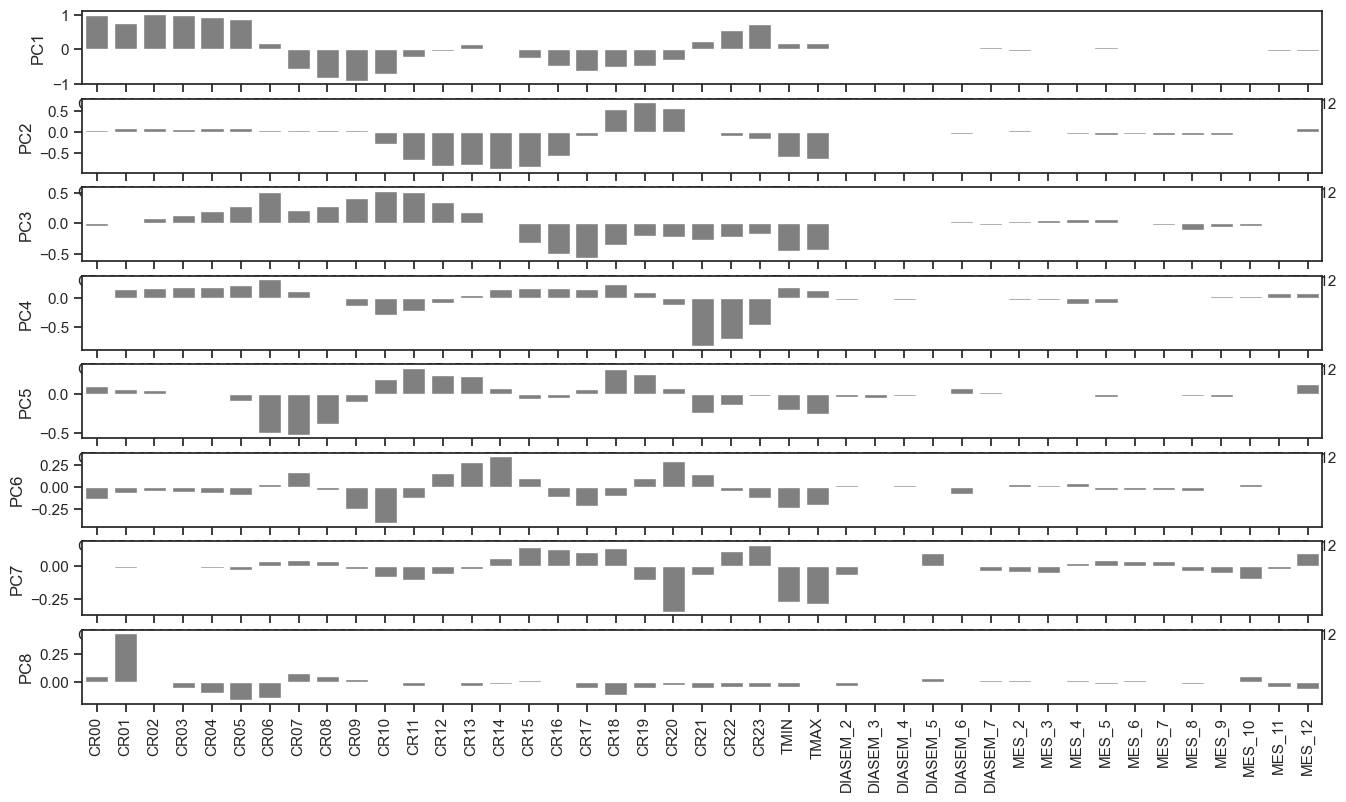

In [ ]:
# Get the loadings of the PCA
loadings = get_loadings(pca, X_train.columns)

# Plot the loadings of the PCA
plot_loadings(loadings, ['PC'+str(n) for n in range(1, 9)])

In [ ]:
# Get the train and test data with the PCA
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
# Fit a simple Decision Tree classifier to the PCA transformed data
param_DT_PCA = {
    'DT__max_depth': [5,7,9],
    'DT__min_impurity_decrease': np.arange(0, 0.1, 0.005),
    'DT__min_samples_split': [175,250], 
    'DT__min_samples_leaf': [75,125]
}

pipe_DT_PCA = Pipeline(steps=[ ('DT', DecisionTreeClassifier(criterion='gini',
                                                         random_state=2023))])

nFolds = 10
tree_fit_pca = GridSearchCV(
    estimator=pipe_DT_PCA, # Structure of the model to use
    param_grid=param_DT_PCA, # Defined grid to search in
    n_jobs=-1, # Number of cores to use (parallelize)
    scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
    cv=nFolds # Number of Folds
) 
                        
tree_fit_pca.fit(X_train_pca, y_train) # Search in grid
print("Decision Tree Trained")

# Get the best parameters of the Decision Tree
tree_fit_pca.best_params_

Decision Tree Trained


{'DT__max_depth': 7,
 'DT__min_impurity_decrease': 0.0,
 'DT__min_samples_leaf': 75,
 'DT__min_samples_split': 175}

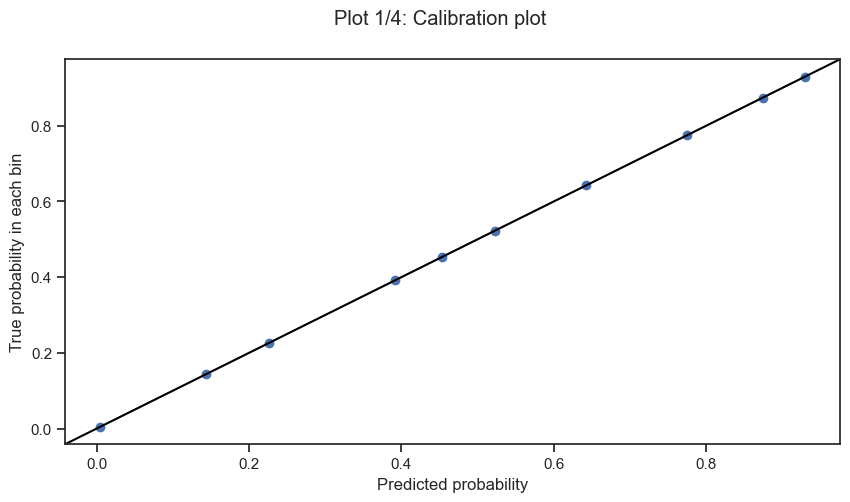

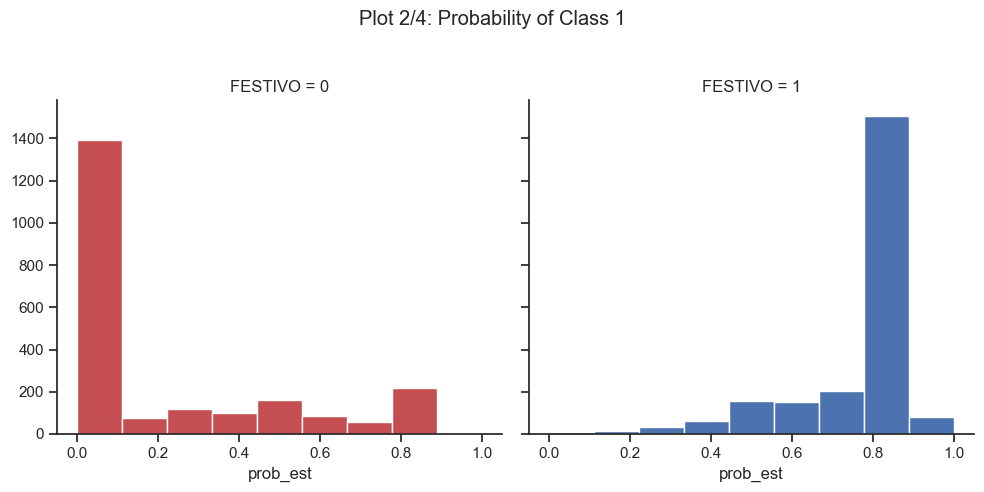

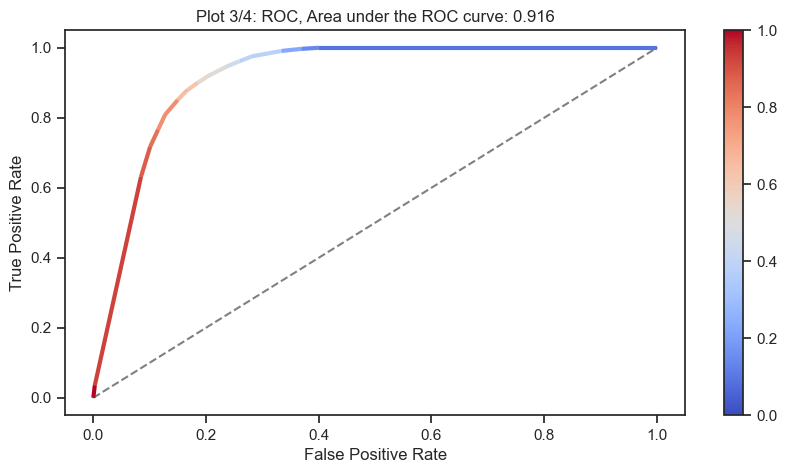

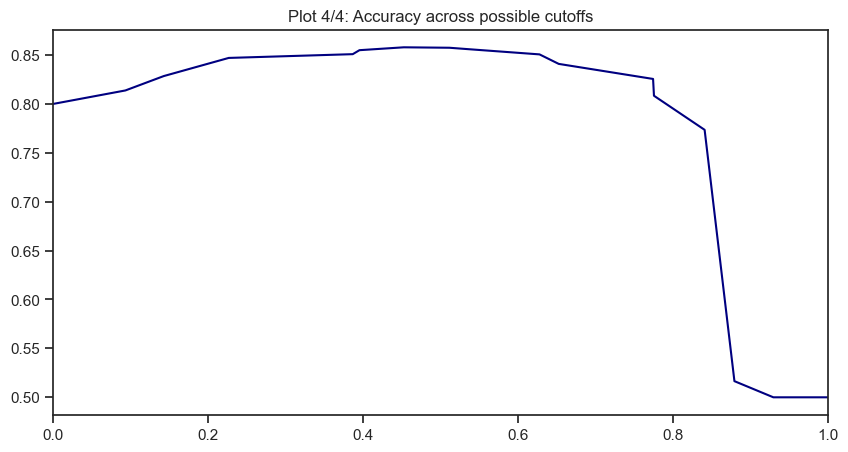

In [ ]:
y_train = y_train.astype('category')
CT.plotClassPerformance(y_train, tree_fit_pca.predict_proba(X_train_pca), selClass = 1)
plt.show()

In [ ]:
metrics_summary(tree_fit_pca, X_train_pca, y_train, 0.5)

Confusion matrix
[[1761  450]
 [ 179 2032]]
Confusion matrix with percentages
[[0.8  0.2 ]
 [0.08 0.92]]
Accuracy
0.857756671189507
Balanced accuracy
0.857756671189507
Precision
0.8186946011281225
Recall
0.919041157847128
F1
0.8659705945024505
ROC_AUC_SCORE
0.916269869762245


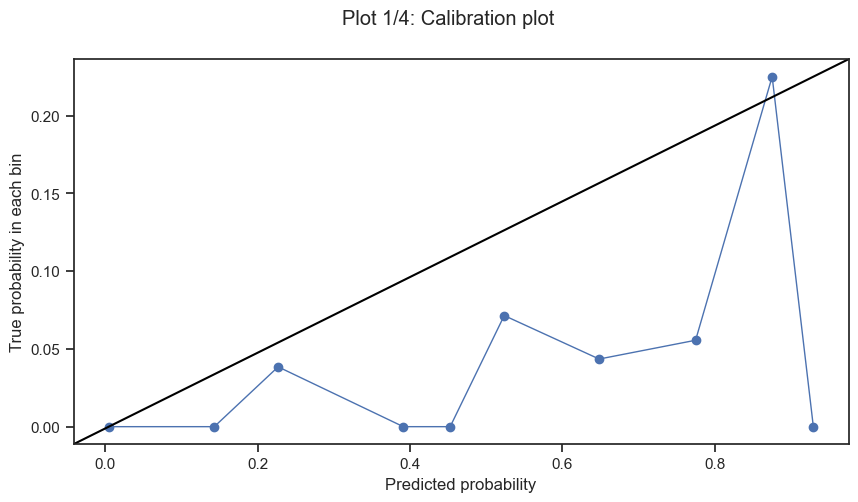

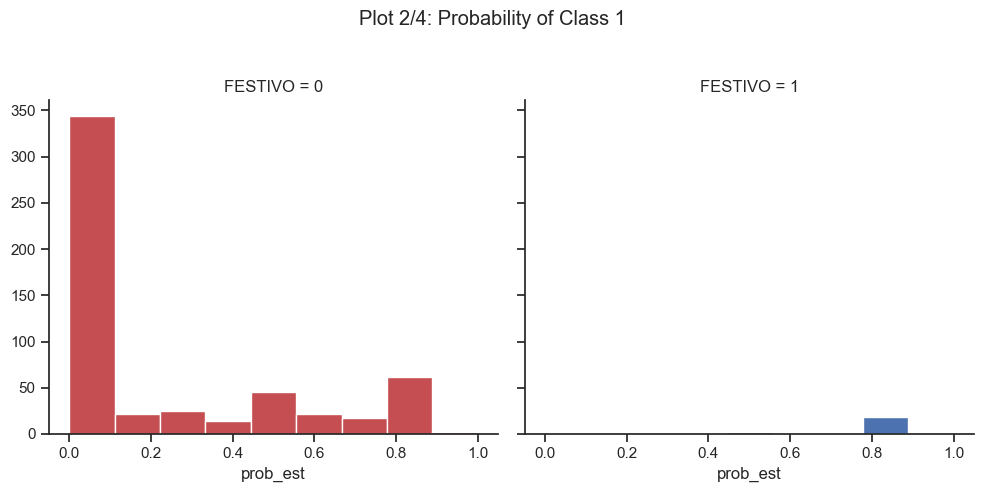

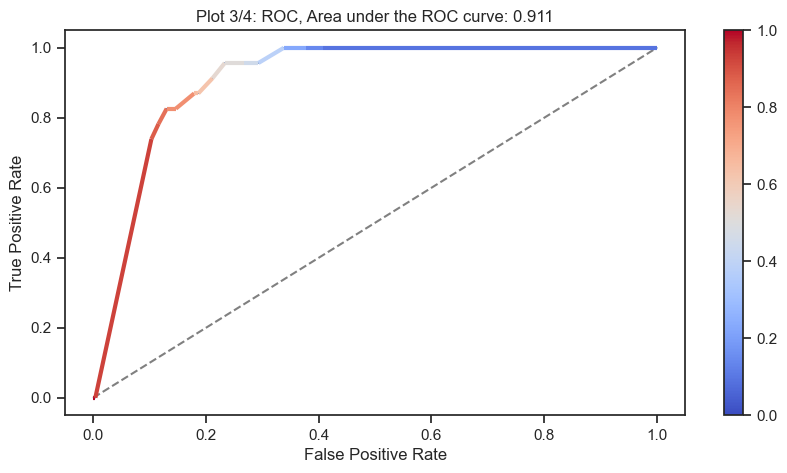

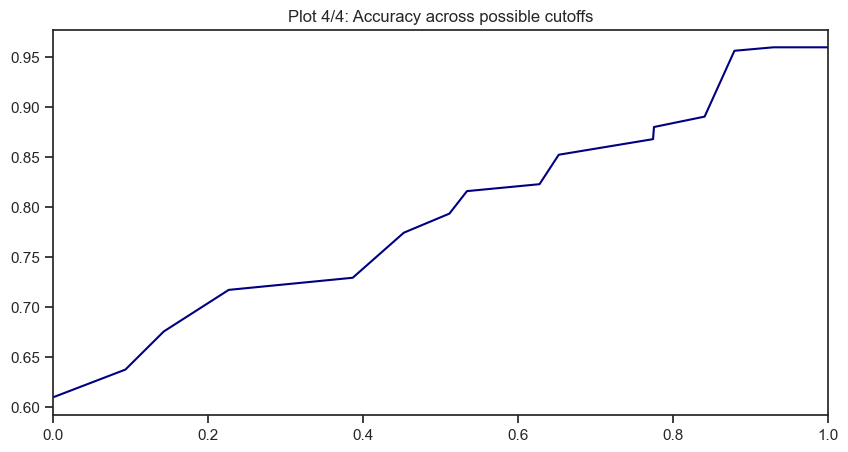

In [ ]:
y_test = y_test.astype('category')
CT.plotClassPerformance(y_test, tree_fit_pca.predict_proba(X_test_pca), selClass = 1)
plt.show()

In [ ]:
metrics_summary(tree_fit_pca, X_test_pca, y_test, 0.5)

Confusion matrix
[[424 129]
 [  1  22]]
Confusion matrix with percentages
[[0.77 0.23]
 [0.04 0.96]]
Accuracy
0.7743055555555556
Balanced accuracy
0.8616243415362843
Precision
0.1456953642384106
Recall
0.9565217391304348
F1
0.2528735632183908
ROC_AUC_SCORE
0.9113530937966822


En general, se puede observar que el modelo está teniendo dificultades para generalizar a nuevos datos, como se puede ver por la diferencia en la precisión y el accuracy entre los conjuntos de entrenamiento y prueba.

En el conjunto de entrenamiento, el modelo parece tener un desempeño aceptable, con un accuracy del 85,7% y un F1-score de 0,87. Sin embargo, la matriz de confusión sugiere que el modelo está clasificando incorrectamente una cantidad significativa de instancias, con un número de falsos positivos y falsos negativos. Por otro lado, en el conjunto de prueba, el modelo tiene un recall muy alto (95,7%) lo que significa que es capaz de identificar la gran mayoría de las instancias positivas, pero su precisión es extremadamente baja (14,5%). Esto sugiere que el modelo está clasificando muchas instancias como positivas cuando en realidad no lo son, lo que se refleja en la matriz de confusión y en el bajo F1-score de 0,25.

En resumen, el modelo parece estar sufriendo de overfitting, ya que se desempeña bien en el conjunto de entrenamiento pero no generaliza adecuadamente a nuevos datos.

#### 1.8 Compara todos los modelos creados en términos de complejidad, interpretabilidad y errores
- Discute el posible impacto que tiene en los modelos el que existan menos festivos que laborables
- Compara la complejidad en términos de nº de parámetros y estructura del modelo, variables utilizadas, importancia de las mismas
- Compara la capacidad de generalización de los modelos utilizando TS y las diferencias en las matrices de confusión
- Estudia la tasa de fallos de los modelos dependiendo del día de la semana
- Indica qué modelo o modelos son los más prometedores para poner en producción, justificando la selección

In [ ]:
from collections import defaultdict
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import (
    mean_squared_error, 
    r2_score, mean_absolute_error, 
    silhouette_score, 
    classification_report, 
    RocCurveDisplay,
    f1_score,
    brier_score_loss,
    log_loss,
    precision_score,
    recall_score,
    accuracy_score
)

In [ ]:
#-------------------------- NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
models = {
    'Basic Decision Tree': tree_fit,
    'Decision Tree with PCA': tree_fit_pca,
    'Bagging': bag_tree_fit,
    'Random Forest': random_forest_fit,
    'LightGBM': lgbm_fit,
    'XGBoost': XGB_fit,
    'Stacking': stacked_classification_fit
}

# Get the metrics of the models
metrics = get_classification_metrics(models, X_test, y_test, ['precision', 'recall', 'f1_score', 'accuracy'], X_train, y_train, X_test_pca, X_train_pca)
metrics

Precision  Precision (Train)    Recall  \
Classifier                                                       
Basic Decision Tree      0.377358           0.942433  0.869565   
Decision Tree with PCA   0.145695           0.818695  0.956522   
Bagging                  0.666667           1.000000  0.695652   
Random Forest            0.950000           0.998643  0.826087   
LightGBM                 0.791667           0.996831  0.826087   
XGBoost                  0.148649           0.791407  0.956522   

                        Recall (Train)  F1 score  F1 score (Train)  Accuracy  \
Classifier                                                                     
Basic Decision Tree           0.977386  0.526316          0.959591  0.937500   
Decision Tree with PCA        0.919041  0.252874          0.865971  0.774306   
Bagging                       1.000000  0.680851          1.000000  0.973958   
Random Forest                 0.998191  0.883721          0.998417  0.991319   
LightGBM                      0.995929  0.808511          0.996380  0.984375   
XGBoost                       0.974672  0.257310          0.873531  0.779514   

                        Accuracy (Train)  
Classifier                                
Basic Decision Tree             0.958842  
Decision Tree with PCA          0.857757  
Bagging                         1.000000  
Random Forest                   0.998417  
LightGBM                        0.996382  
XGBoost                         0.858887

---
### 2. VALIDACIÓN FINAL DE LOS MODELOS CON EL DATASET VAL_DATOS_DEM_C3

Se correpondería como si los todos los modelos creados anteriormente se ponen en producción el 1 enero de 2022 y se tienen estimando la festividad durante todo el año para ver qué tal funcionan.

Recuerda, no se debería ver ningún resultado sobre este dataset hasta haber completado todos los apartados anteriores.

Carga datos de validación

In [ ]:
#--------------------------NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|

df_val = pd.read_csv('data/input/VAL_DATOS_DEM_C3.csv')

# parseamos la fecha (cadena) para que sea un datetime con formato dd/mm/yyyy 
# esta variable NO se puede utilizar como entrada en los modelos
df_val.FECHA = pd.to_datetime(df_val.FECHA, format='%d/%m/%Y') 
s=df_val.loc[:,'FECHA']
df_val['FECHA'] =  s.dt.date

# eliminamos las variables que no se pueden usar como entradas en los modelos
del df_val['ANNO']
del df_val['DIA']

print('Tamaño de df_val con los datos cargados:', df_val.shape)
print('Dataframe con todos los datos leidos (filas: días, columnas: variables):')
df_val

Tamaño de df_val con los datos cargados: (357, 30)
Dataframe con todos los datos leidos (filas: días, columnas: variables):


FECHA      CR00      CR01      CR02      CR03      CR04      CR05  \
0    2022-01-01  0.038935  0.037313  0.035291  0.033673  0.032924  0.033235   
1    2022-01-02  0.035271  0.033313  0.031889  0.031411  0.031302  0.031975   
2    2022-01-03  0.033756  0.032003  0.030669  0.030051  0.030199  0.031280   
3    2022-01-04  0.034484  0.032505  0.031375  0.030540  0.030431  0.031324   
4    2022-01-05  0.034669  0.032213  0.030933  0.030382  0.030527  0.031611   
..          ...       ...       ...       ...       ...       ...       ...   
352  2022-12-27  0.033279  0.031139  0.029907  0.029433  0.029757  0.030972   
353  2022-12-28  0.033250  0.031186  0.029934  0.029447  0.029821  0.030942   
354  2022-12-29  0.033718  0.031695  0.030290  0.029717  0.030014  0.031075   
355  2022-12-30  0.033673  0.031494  0.030124  0.029639  0.029629  0.030732   
356  2022-12-31  0.034661  0.032394  0.031029  0.030202  0.030263  0.031111   

         CR06      CR07      CR08      CR09      CR10      CR11      CR12  \
0    0.034250  0.035303  0.037974  0.042279  0.044804  0.045335  0.045389   
1    0.033854  0.035571  0.039449  0.045056  0.047360  0.046811  0.046341   
2    0.034230  0.037862  0.042149  0.046176  0.047058  0.046823  0.046718   
3    0.034787  0.038767  0.042558  0.045922  0.046807  0.045896  0.045911   
4    0.034651  0.038108  0.041891  0.046432  0.046798  0.046766  0.046954   
..        ...       ...       ...       ...       ...       ...       ...   
352  0.034595  0.038379  0.042911  0.046451  0.046788  0.046235  0.046082   
353  0.033929  0.037831  0.042330  0.046626  0.048313  0.046441  0.046173   
354  0.034526  0.038393  0.043134  0.046748  0.047216  0.047560  0.046632   
355  0.033926  0.037799  0.042977  0.046871  0.047329  0.046171  0.046530   
356  0.033522  0.036211  0.040875  0.045728  0.047349  0.046385  0.045862   

         CR13      CR14      CR15      CR16      CR17      CR18      CR19  \
0    0.046126  0.046057  0.043594  0.042798  0.044205  0.048990  0.051431   
1    0.047375  0.047082  0.044797  0.043696  0.045041  0.049475  0.052162   
2    0.047477  0.047473  0.044874  0.043920  0.045243  0.050025  0.052212   
3    0.046669  0.046458  0.044271  0.043534  0.045018  0.049658  0.052198   
4    0.046846  0.046164  0.044510  0.043944  0.044861  0.048728  0.051285   
..        ...       ...       ...       ...       ...       ...       ...   
352  0.046746  0.046461  0.045921  0.046095  0.047279  0.051045  0.052135   
353  0.048032  0.048392  0.046012  0.045069  0.046976  0.050641  0.051762   
354  0.047209  0.046517  0.044910  0.045497  0.047147  0.050541  0.051901   
355  0.046960  0.046082  0.045153  0.045522  0.048214  0.051428  0.052022   
356  0.045814  0.045920  0.044494  0.045222  0.047886  0.052548  0.054531   

         CR20      CR21      CR22      CR23  MES  DIASEM  FESTIVO  TMIN  TMAX  
0    0.050366  0.047399  0.043002  0.039327    1       6        1  14.1  25.3  
1    0.050877  0.047856  0.043245  0.038792    1       7        0  14.5  24.9  
2    0.051153  0.047885  0.042709  0.038054    1       1        0  11.3  23.8  
3    0.051378  0.047963  0.043061  0.038486    1       2        0  10.8  23.0  
4    0.050828  0.048133  0.043639  0.039127    1       3        0  14.7  22.2  
..        ...       ...       ...       ...  ...     ...      ...   ...   ...  
352  0.050948  0.047933  0.042347  0.037164   12       2        0  20.6  23.5  
353  0.050446  0.047250  0.042042  0.037155   12       3        0  18.7  24.1  
354  0.050019  0.046786  0.041653  0.037101   12       4        0  18.0  24.6  
355  0.050441  0.046984  0.042434  0.037864   12       5        0  15.7  24.1  
356  0.051682  0.046953  0.041553  0.037804   12       6        0  15.3  23.3  

[357 rows x 30 columns]

#### 2.1. Compara los errores obtenidos en validación con los observados previamente en ajuste/test
- Una vez terminados todos los ajustes de los modelos en el apartado 1.1., ejecuta los mismos para estimar si los días de 2022 son festivos o no (conjunto df_val)
- Muestra los resultados de clasificación obtenidos en el nuevo dataset (accuray y tablas de confusión de cada modelo)
- Discute si los errores obtenidos son coherentes con lo que se esperaba como resultado de los análisis previos para estimar la capacidad de generalización de cada uno de los modelos

In [ ]:
#--------------------------NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|


#### 2.2. Análisis de los días peor clasificados
- Indica en una tabla la lista de los días que se han clasificado incorrectamente por cada uno de los modelos considerados
- Comenta las posibles diferencias y semejanzas, intentando buscar una justificación de por qué ha ocurrido el error de clasificación
- Muestra gráficamente los perfiles de 24 horas de los 3 días más difíciles de clasificar para los modelos, comparándolos con lo esperado según el día de la semana correspondiente

In [ ]:
#--------------------------NO ESCRIBAS LÍNEAS DE CÓDIGO MÁS LARGAS QUE LO QUE OCUPA ESTA LÍNEA -----------------------------|
